## Name: Moad Saad Khorchef<br>
## ID: 200934655


## Basic Solution 


In [1]:
#from google.colab import drive

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os, sys, re, pickle, glob
import urllib.request
import zipfile
import soundfile


#from IPython.display import Audio
import IPython.display as ipd
from tqdm import tqdm
import librosa
#drive.mount('/content/drive')

### Feature Extraction 

In [2]:
def feature_chromagram(waveform, sample_rate):
    # STFT computed here explicitly; mel spectrogram and MFCC functions do this under the hood
    stft_spectrogram=np.abs(librosa.stft(waveform))
    # Produce the chromagram for all STFT frames and get the mean of each column of the resulting matrix to create a feature array
    chromagram=np.mean(librosa.feature.chroma_stft(S=stft_spectrogram, sr=sample_rate,hop_length=512,n_fft=2048).T,axis=0)
    return chromagram

def feature_melspectrogram(waveform, sample_rate):
    # Produce the mel spectrogram for all STFT frames and get the mean of each column of the resulting matrix to create a feature array
    # Using 8khz as upper frequency bound should be enough for most speech classification tasks
    melspectrogram=np.mean(librosa.feature.melspectrogram(y=waveform, sr=sample_rate, n_mels=128, fmax=sample_rate, hop_length=512,n_fft=2048).T,axis=0) ###
    return melspectrogram

def feature_mfcc(waveform, sample_rate):
    # Compute the MFCCs for all STFT frames and get the mean of each column of the resulting matrix to create a feature array
    # 40 filterbanks = 40 coefficients
    mfc_coefficients=np.mean(librosa.feature.mfcc(y=waveform, sr=sample_rate, n_mfcc=40).T, axis=0) 
    return mfc_coefficients



def getPitch(x,fs,winLen=0.02):
  #winLen = 0.02 
    p = winLen*fs
    frame_length = int(2**int(p-1).bit_length())
    hop_length = frame_length//2
    f0, voiced_flag, voiced_probs = librosa.pyin(y=x, fmin=80, fmax=450, sr=fs, frame_length=frame_length,hop_length=hop_length)
    return f0,voiced_flag



def get_features(file):
    # load an individual soundfile
     with soundfile.SoundFile(file) as audio:
        waveform = audio.read(dtype="float32")
        sample_rate = audio.samplerate
        # compute features of soundfile
        chromagram = feature_chromagram(waveform, sample_rate)
        melspectrogram = feature_melspectrogram(waveform, sample_rate)
        mfc_coefficients = feature_mfcc(waveform, sample_rate)

        # my added features
        #######
        y = waveform
        sr = sample_rate
        stft_=np.abs(librosa.stft(waveform))

        cent = np.mean( librosa.feature.spectral_centroid(y=y, sr=sr,hop_length=512,n_fft=2048).T, axis=0)
        contrast = np.mean( librosa.feature.spectral_contrast(S=stft_, sr=sr,hop_length=512,n_fft=2048).T, axis=0)
        #tonnetz = np.mean( librosa.feature.tonnetz(y=librosa.effects.harmonic(y), sr=sample_rate ,hop_length=512).T,axis=0)#
        rms = np.mean( librosa.feature.rms(y=y,frame_length=2048 ,hop_length=512).T, axis=0)
        spec_bw = np.mean( librosa.feature.spectral_bandwidth(y=y, sr=sr ,n_fft=2048, hop_length=512).T, axis=0)
        rolloff = np.mean( librosa.feature.spectral_rolloff(y=y, sr=sr ,n_fft=2048, hop_length=512).T, axis=0)
        zcr = np.mean( librosa.feature.zero_crossing_rate(y, frame_length=2048, hop_length=512).T, axis=0) 
        #######

        feature_matrix=np.array([])
        # use np.hstack to stack our feature arrays horizontally to create a feature matrix
        feature_matrix = np.hstack((chromagram, melspectrogram, mfc_coefficients , cent, contrast, rms, spec_bw, rolloff, zcr))
        
        return feature_matrix

In [3]:
#import os, glob

#def load_data():
#    X,y=[],[]
#    count = 0
#    for file in glob.glob('/content/drive/MyDrive/Data/MLEnd/training/*/*.wav'):
#        file_name=os.path.basename(file)
#        fileID = file.split('/')[-1]
#        features = get_features(file)
#        X.append(features)
       # y.append(emotion)
#        count += 1
        # '\r' + end='' results in printing over same line
#        print('\r' + f' Processed {count}/{20000} audio samples',end=' ')
    # Return arrays to plug into sklearn's cross-validation algorithms
#    return np.array(X)

In [4]:
def getXy(files,labels_file,scale_audio=False, onlySingleDigit=False):
    X,y =[],[]
    for file in tqdm(files):
        file = file.replace("\\", "/")
        fileID = file.split("/")[-1]
        #print(fileID)
        yi = list(labels_file[labels_file['File ID']==fileID]['digit_label'])[0]
        label = list(labels_file[labels_file['File ID']==fileID]['intonation'])[0]
        if onlySingleDigit and yi>9:
            continue
        else:
            fs = None # if None, fs would be 22050
            x, fs = librosa.load(file,sr=fs)
            if scale_audio: x = x/np.max(np.abs(x))
            f0, voiced_flag = getPitch(x,fs,winLen=0.02)

            power = np.sum(x**2)/len(x)
            pitch_mean = np.nanmean(f0) if np.mean(np.isnan(f0))<1 else 0
            pitch_std  = np.nanstd(f0) if np.mean(np.isnan(f0))<1 else 0
            voiced_fr = np.mean(voiced_flag)

            #added 
            features = get_features(file)

            #xi = [power,pitch_mean,pitch_std,voiced_fr]

            xi = np.hstack((power,pitch_mean,pitch_std,voiced_fr,features))

            X.append(xi)
            y.append(label)
    return np.array(X),np.array(y)

In [10]:
labels = pd.read_csv('./Data/MLEnd/trainingMLEnd.csv')
labels


,File ID,digit_label,participant,intonation
0,0000000.wav,4,S73,question
1,0000001.wav,2,S88,excited
2,0000002.wav,70,S5,neutral
3,0000003.wav,2,S85,bored
4,0000004.wav,4,S30,excited
...,...,...,...,...
19995,0019995.wav,90,S163,excited
19996,0019996.wav,10,S99,question
19997,0019997.wav,90,S46,question
19998,0019998.wav,19,S13,neutral


In [11]:
files = glob.glob("./Data/MLEnd/training/Training/*.wav" )


X,y = getXy(files[:6000],labels_file=labels,scale_audio=True, onlySingleDigit=True)

#a,b = getXy(files[:1000],labels_file=labels,scale_audio=True, onlySingleDigit=True)



  0%|                                                                                         | 0/6000 [00:00<?, ?it/s]C:\Users\Moad\anaconda3\lib\site-packages\librosa\filters.py:238: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  warnings.warn(
100%|██████████████████████████████████████████████████████████████████████████████| 6000/6000 [14:54<00:00,  6.70it/s]


In [151]:
files = glob.glob('./Data/MLEnd/training/Training/*.wav')
len(files)

20000

In [12]:
#print('The shape of X is', a.shape) 
#print('The shape of y is', b.shape)
#print('The labels vector is', y)

In [13]:
print('The shape of X is', X.shape) 
print('The shape of y is', y.shape)
#print('The labels vector is', y)

The shape of X is (1949, 196)
The shape of y is (1949,)


### Best Feature Selection

In [14]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, mutual_info_classif#

#X.shape
X_new = SelectKBest(mutual_info_classif, k=190).fit_transform(X, y)
#X_new = SelectKBest(mutual_info_classif, k=150).fit_transform(a, b)

X_new.shape


(1949, 190)

In [15]:
print(f'\nAudio samples represented: {X_new.shape[0]}')
print(f'Numerical features extracted per sample: {X_new.shape[1]}')
features_df = pd.DataFrame(X_new) # make it pretty for display
features_df


Audio samples represented: 1949
Numerical features extracted per sample: 190


,0,1,2,3,4,5,6,7,8,9,...,180,181,182,183,184,185,186,187,188,189
0,0.010129,208.882834,118.829623,0.215278,0.753131,0.766886,0.749057,0.671027,0.634170,0.670543,...,12.066502,13.726420,15.600197,15.085901,15.386061,19.041806,0.009657,2197.995732,4693.939209,0.159003
1,0.035339,157.289085,31.784415,0.293333,0.583537,0.643321,0.677088,0.669812,0.709702,0.740893,...,13.944263,15.772536,16.208509,17.446751,17.795718,27.592407,0.031027,2434.352641,5335.701069,0.155646
2,0.013676,134.964540,4.520547,0.084507,0.677341,0.748570,0.695867,0.597716,0.595714,0.726472,...,12.323731,16.377326,15.793714,20.858538,21.230001,19.016606,0.031680,1446.833328,1627.869907,0.027166
3,0.052517,181.944641,40.719889,0.494253,0.569682,0.537822,0.540425,0.537556,0.533592,0.509157,...,15.977014,20.075173,18.970150,17.982028,19.588298,25.813768,0.078083,1994.697128,3658.686967,0.105957
4,0.027461,109.742686,18.208426,0.120000,0.704168,0.769274,0.750523,0.715473,0.715584,0.750014,...,11.006136,14.597893,15.629837,15.968503,17.372982,28.002703,0.073354,1915.549197,4090.016602,0.118665
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1944,0.012427,218.320824,74.117411,0.215190,0.671424,0.675539,0.718936,0.770489,0.783567,0.700486,...,13.106332,14.723138,14.927029,16.610873,16.490449,22.097368,0.038017,2287.243290,5410.558000,0.220672
1945,0.019418,244.020822,69.803627,0.337349,0.687252,0.701269,0.734410,0.739803,0.626294,0.625772,...,15.619662,16.779178,16.662217,16.648297,15.834053,25.801179,0.064158,2398.899065,4433.504918,0.065118
1946,0.055544,205.535959,44.520564,0.508065,0.500811,0.442746,0.422549,0.392942,0.397227,0.447477,...,18.152734,22.305314,22.854587,25.405481,27.847928,33.575963,0.165468,1813.729011,3224.423513,0.081496
1947,0.022832,270.207906,77.876257,0.302632,0.584216,0.621987,0.611628,0.667121,0.762832,0.667282,...,16.730680,18.322132,17.769921,18.166319,21.190978,22.895909,0.025193,2193.073818,5535.166530,0.206826


### Class Balance Check 

In [16]:
intonation_list = np.unique(y)
intonation_list

array(['bored', 'excited', 'neutral', 'question'], dtype='<U8')

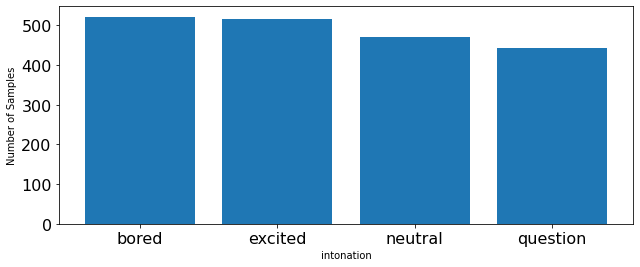

In [17]:
# plot emotions
plt.figure(figsize=(35,4))
plt.subplot(1,3,1)
#np.unique returns ordered list of unique elements and count of each element
intonation_list, count = np.unique(y, return_counts=True)
plt.bar(x=range(4), height=count)
plt.xticks(ticks=range(4), labels = [intonation for intonation in intonation_list],fontsize=10)
plt.xlabel('intonation')
plt.tick_params(labelsize=16)
plt.ylabel('Number of Samples')
plt.show()

In [18]:
# If nan sample, remove them
if np.sum(np.isnan(X)):
    idx = np.isnan(X).sum(1)>0
    X = X[~idx]
    y = y[~idx]
print(np.sum(np.isnan(X)))

0


### Normalising

In [19]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

scaler = StandardScaler()
# keep our unscaled features just in case we need to process them alternatively
#features_scaled = X
#features_scaled = a
features_scaled = X_new
features_scaled = scaler.fit_transform(features_scaled)

#scaler = MinMaxScaler()
# keep our unscaled features just in case we need to process them alternatively
#features_minmax = features
#features_minmax = scaler.fit_transform(features_minmax)

In [20]:
features_scaled_df = pd.DataFrame(features_scaled) # make it pretty for display
features_scaled_df

,0,1,2,3,4,5,6,7,8,9,...,180,181,182,183,184,185,186,187,188,189
0,-0.842976,0.400776,3.385139,-0.579043,0.799140,1.027576,0.857193,0.111030,-0.139985,0.260398,...,-1.232015,-1.458734,-0.386383,-1.335666,-1.373209,-1.175288,-0.711562,-0.066101,-0.012779,0.290658
1,0.876839,-0.247284,0.142631,-0.091997,-0.860901,-0.174619,0.164147,0.099436,0.549521,0.899578,...,-0.398668,-0.524623,-0.095913,-0.112957,-0.236553,0.978520,0.038124,0.557227,0.458210,0.248346
2,-0.600979,-0.527699,-0.872971,-1.395019,0.057287,0.849369,0.344986,-0.588274,-0.491041,0.768550,...,-1.117857,-0.248518,-0.293978,1.654044,1.383427,-1.181635,0.061036,-2.047093,-2.262965,-1.370896
3,2.048664,0.062410,0.475485,1.161689,-0.996521,-1.201049,-1.151872,-1.162142,-1.058135,-1.205914,...,0.503463,1.439656,1.222777,0.164269,0.609022,0.530499,1.688916,-0.602248,-0.772550,-0.377887
4,0.339394,-0.844506,-0.363086,-1.173552,0.319872,1.050802,0.871304,0.534995,0.603220,0.982447,...,-1.702604,-1.060881,-0.372230,-0.878557,-0.435961,1.081869,1.522988,-0.810979,-0.455997,-0.217723
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1944,-0.686187,0.519325,1.719571,-0.579592,-0.000634,0.138839,0.567138,1.059792,1.223815,0.532453,...,-0.770540,-1.003703,-0.707822,-0.545867,-0.852259,-0.405623,0.283348,0.169265,0.513147,1.067873
1945,-0.209269,0.842139,1.558879,0.182652,0.154298,0.389172,0.716143,0.767077,-0.211884,-0.146379,...,0.344871,-0.065061,0.120734,-0.526485,-1.161887,0.527328,1.200383,0.463728,-0.203912,-0.892584
1946,2.255192,0.358737,0.617064,1.247870,-1.670651,-2.126057,-2.286985,-2.541593,-2.302972,-1.766326,...,1.469044,2.457780,3.077604,4.008954,4.505159,2.485716,4.754478,-1.079503,-1.091256,-0.686173
1947,0.023606,1.171070,1.859592,-0.033978,-0.854261,-0.382188,-0.466211,0.073773,1.034530,0.230769,...,0.837939,0.639342,0.649665,0.259715,1.365020,-0.204479,-0.166559,-0.079082,0.604597,0.893364


### Dataset Spliting

In [22]:
from sklearn.model_selection import train_test_split


############# Unscaled test/train set #############
#X_train, X_val, y_train, y_val = train_test_split(
#    X, 
#    y, 
#    test_size=0.2, 
#    stratify=y
#)

############ Standard Scaled test/train set ###########
# The labels/classes (y_train, y_test) never change, keep old values 
X_train_scaled, X_test_scaled, y_train, y_val = train_test_split(
    features_scaled, 
    y, 
    test_size=0.2, 
    stratify=y
)


## Comparing Models

In [23]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

X_train_scaled, X_val_scaled, y_train, y_val = train_test_split(
    features_scaled, 
    y, 
    test_size=0.2, 
    stratify=y
)

classification_models = [
    KNeighborsClassifier(),#(3),
    #SVC(kernel='linear'),#, C=0.025),
    SVC(kernel='rbf'),
    DecisionTreeClassifier(),#max_depth=5),
    RandomForestClassifier(),#max_depth=5, n_estimators=10, max_features=1),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()]

scores = []
for model in classification_models:
    model.fit(X_train_scaled, y_train)
    score = model.score(X_val_scaled, y_val)
    model_name = type(model).__name__
    if model_name=='SVC' and model.kernel=='rbf': model_name+=' RBF kernel'
    scores.append((model_name,(f'{100*score:.2f}%')))
    
# Make it pretty
scores_df = pd.DataFrame(scores,columns=['Classifier','Accuracy Score'])
scores_df.sort_values(by='Accuracy Score',axis=0,ascending=False)

C:\Users\Moad\anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


,Classifier,Accuracy Score
3,RandomForestClassifier,62.31%
0,KNeighborsClassifier,60.26%
1,SVC RBF kernel,58.21%
4,AdaBoostClassifier,50.00%
2,DecisionTreeClassifier,48.72%
6,QuadraticDiscriminantAnalysis,43.59%
5,GaussianNB,35.64%


### GridSearchCV SVM

In [24]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.svm import SVC


param_grid = { 'C':[1,2,3,4,5,6,7,8],'kernel':['rbf'],'gamma': [ 1, 0.1, 0.01 ]}

grid = GridSearchCV(SVC(),param_grid,refit=True,verbose=2, cv= 5)
grid.fit(X_train_scaled,y_train)

# print best parameter after tuning
print(grid.best_params_)
# print how our model looks after hyper-parameter tuning
print(grid.best_estimator_)
print('Test dataset accuracy of best hyperparameter setting: {0}.'.format(grid.score(X_val_scaled, y_val)))

#grid_predictions = grid.predict(X_val)
#print(confusion_matrix(y_val,grid_predictions))
#print(classification_report(y_val,grid_predictions))#Output

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV] C=1, gamma=1, kernel=rbf ........................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ......................... C=1, gamma=1, kernel=rbf, total=   0.8s
[CV] C=1, gamma=1, kernel=rbf ........................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s


[CV] ......................... C=1, gamma=1, kernel=rbf, total=   0.8s
[CV] C=1, gamma=1, kernel=rbf ........................................
[CV] ......................... C=1, gamma=1, kernel=rbf, total=   0.8s
[CV] C=1, gamma=1, kernel=rbf ........................................
[CV] ......................... C=1, gamma=1, kernel=rbf, total=   0.8s
[CV] C=1, gamma=1, kernel=rbf ........................................
[CV] ......................... C=1, gamma=1, kernel=rbf, total=   0.8s
[CV] C=1, gamma=0.1, kernel=rbf ......................................
[CV] ....................... C=1, gamma=0.1, kernel=rbf, total=   0.8s
[CV] C=1, gamma=0.1, kernel=rbf ......................................
[CV] ....................... C=1, gamma=0.1, kernel=rbf, total=   0.8s
[CV] C=1, gamma=0.1, kernel=rbf ......................................
[CV] ....................... C=1, gamma=0.1, kernel=rbf, total=   0.8s
[CV] C=1, gamma=0.1, kernel=rbf ......................................
[CV] .

[CV] ...................... C=4, gamma=0.01, kernel=rbf, total=   0.7s
[CV] C=5, gamma=1, kernel=rbf ........................................
[CV] ......................... C=5, gamma=1, kernel=rbf, total=   0.8s
[CV] C=5, gamma=1, kernel=rbf ........................................
[CV] ......................... C=5, gamma=1, kernel=rbf, total=   0.8s
[CV] C=5, gamma=1, kernel=rbf ........................................
[CV] ......................... C=5, gamma=1, kernel=rbf, total=   0.8s
[CV] C=5, gamma=1, kernel=rbf ........................................
[CV] ......................... C=5, gamma=1, kernel=rbf, total=   0.8s
[CV] C=5, gamma=1, kernel=rbf ........................................
[CV] ......................... C=5, gamma=1, kernel=rbf, total=   0.8s
[CV] C=5, gamma=0.1, kernel=rbf ......................................
[CV] ....................... C=5, gamma=0.1, kernel=rbf, total=   0.8s
[CV] C=5, gamma=0.1, kernel=rbf ......................................
[CV] .

[CV] ...................... C=8, gamma=0.01, kernel=rbf, total=   0.7s
[CV] C=8, gamma=0.01, kernel=rbf .....................................
[CV] ...................... C=8, gamma=0.01, kernel=rbf, total=   0.7s
[CV] C=8, gamma=0.01, kernel=rbf .....................................
[CV] ...................... C=8, gamma=0.01, kernel=rbf, total=   0.7s


[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:  1.5min finished


{'C': 8, 'gamma': 0.01, 'kernel': 'rbf'}
SVC(C=8, gamma=0.01)
Test dataset accuracy of best hyperparameter setting: 0.6897435897435897.


### GridSearchCV RandomForestClassifier

In [25]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split


rfc = RandomForestClassifier(n_jobs=-1,max_features= 'sqrt' ,n_estimators=50, oob_score = True) 

param_grid = { 
    'n_estimators': [200,250,280,300,350],
    'max_features': ['sqrt']
}

grid = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
grid.fit(X_train_scaled, y_train)


print (grid.best_score_)
print (grid.best_params_)
print (grid.best_estimator_)
print('Test dataset accuracy (random forest classifier): {0}.'.format(grid.score(X_val_scaled, y_val)))

0.5791738807815979
{'max_features': 'sqrt', 'n_estimators': 200}
RandomForestClassifier(max_features='sqrt', n_estimators=200, n_jobs=-1,
                       oob_score=True)
Test dataset accuracy (random forest classifier): 0.6384615384615384.


## Advanced Solution


### RNN implementaion


tried to classify numeral unsuccessfully using pytorch RNN

In [33]:
import torch
import torchvision
import torch.nn.functional as F
import torch.nn as nn
import time
import torch.optim as optim


In [34]:
#custom dataloader
from torch.utils.data.dataset import Dataset


class CustomDataset(Dataset):
    def __init__(self, data,label ):
        """
        Args:
            csv_path (string): path to csv file
            height (int): image height
            width (int): image width
            transform: pytorch transforms for transforms and tensor conversion
        """
        self.datas = torch.tensor(data,dtype=torch.float)
        self.labels = torch.tensor(label,dtype=torch.long) 
        self.length = len(self.labels)

    def __getitem__(self, index):
        
        a = self.datas[index]
        b = self.labels[index]

        return (a, b)

    def __len__(self):
        return self.length
        




In [35]:
X = np.load('X.npy')
y = np.load('y.npy')

In [36]:
X1 = X.reshape(6533,1,40 )
X1.shape

(6533, 1, 40)

In [37]:
customData = CustomDataset( X1,y)

In [38]:
train_loader = torch.utils.data.DataLoader(dataset = customData, batch_size=1, shuffle=False)

test_loader = torch.utils.data.DataLoader(dataset = customData, batch_size=1, shuffle=True)


In [39]:
for data,label in train_loader:
    print(data)
    print(data.shape)
    print('lol')
    print(label)
    print(label.shape)
    break

tensor([[[-5.3418e+02,  6.2225e+01,  2.0558e+01,  2.2183e+01,  2.5795e+01,
           1.2348e+01,  7.7691e+00,  8.5875e+00,  4.3267e+00,  3.1053e+00,
           2.1343e+00, -2.7397e+00, -3.7493e+00, -1.2565e+00, -4.9067e-01,
           1.7763e-01,  5.0912e-01, -3.9038e-01,  9.1733e-01,  3.4233e+00,
           3.0662e+00,  1.9561e+00,  2.3518e+00,  1.4118e+00, -1.0623e+00,
          -2.0780e+00, -1.7906e+00, -1.4467e+00, -1.0500e+00, -1.2150e+00,
          -1.5825e+00, -9.7320e-01, -1.3722e-01,  1.4873e-01,  3.2827e-01,
           3.0418e-01,  5.9946e-02, -1.8714e-01, -8.4638e-01, -1.6225e+00]]])
torch.Size([1, 1, 40])
lol
tensor([4])
torch.Size([1])


In [40]:
class RNN(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers):
        super(RNN, self).__init__()
        
        self.hidden_dim=hidden_dim

        # define an RNN with specified parameters
        # batch_first means that the first dim of the input and output will be the batch_size
        self.rnn = nn.RNN(input_size, hidden_dim, n_layers, batch_first=True)
        
        # last, fully-connected layer
        self.fc = nn.Linear(hidden_dim, output_size)
        
        self.ls = nn.LogSoftmax(dim=1)

    def forward(self, x, hidden):
        # x (batch_size, seq_length, input_size)
        # hidden (n_layers, batch_size, hidden_dim)
        # r_out (batch_size, time_step, hidden_size)
        batch_size = x.size(0)
        
        # get RNN outputs
        r_out, hidden = self.rnn(x, hidden)
        # shape output to be (batch_size*seq_length, hidden_dim)
        r_out = r_out.view(-1, self.hidden_dim)  
        
        # get final output 
        output = self.ls(self.fc(r_out))
        
        return output, hidden

In [41]:
input_size = 40 
output_size = 10
hidden_dim = 256
n_layers = 3
rnn = RNN(input_size, output_size, hidden_dim, n_layers)

In [42]:
criterion = nn.NLLLoss()
optimizer = torch.optim.Adam(rnn.parameters(), lr=0.01) 

In [43]:
train_on_gpu=torch.cuda.is_available()
if train_on_gpu:
    rnn.cuda()
rnn.train()

RNN(
  (rnn): RNN(40, 256, num_layers=3, batch_first=True)
  (fc): Linear(in_features=256, out_features=10, bias=True)
  (ls): LogSoftmax(dim=1)
)

In [45]:
# train the RNN
def train(rnn, n_steps, print_every):
    
    # initialize the hidden state
         
    hidden = None 
    for data, label in train_loader:
            
        inputs = data
        labels = label       
        
#         # defining the training data 
#         time_steps = np.linspace(step * np.pi, (step+1)*np.pi, seq_length + 1)
#         data = np.sin(time_steps)
#         data.resize((seq_length + 1, 1)) # input_size=1

#         x = data[:-1]
#         y = data[1:]
        
        # convert data into Tensors
#         x_tensor = torch.Tensor(x).unsqueeze(0) # unsqueeze gives a 1, batch_size dimension
#         y_tensor = torch.Tensor(y)

        inputs = inputs#.unsqueeze(0)
        
        print(inputs.shape)
        
        if True:
            inputs, labels = inputs.cuda(), labels.cuda()
#         print(inputs)
#         print(inputs.shape)
#         print(labels.shape)

            
        
        # outputs from the rnn
        prediction, hidden = rnn(inputs, hidden)

        
#         print("yes")
        ## Representing Memory ##
        # make a new variable for hidden and detach the hidden state from its history
        # this way, we don't backpropagate through the entire history
        hidden = hidden.data

#         print(prediction)
#         print(labels.unsqueeze(0))
        # calculate the loss
        
        print(prediction)
        print(labels)
        
        loss = criterion(prediction, labels)
        
                
        # zero gradients
        optimizer.zero_grad()
        # perform backprop and update weights
        loss.backward()
               
#         rnn.to("cpu")
        
        optimizer.step()
       
               
        # display loss and predictions
                
        print('Loss: ', loss.item())
#         plt.plot(time_steps[1:], x, 'r.') # input
#         plt.plot(time_steps[1:], prediction.data.numpy().flatten(), 'b.') # predictions
#         plt.show()



    
    return rnn


In [46]:
n_steps = 75
print_every = 15

trained_rnn = train(rnn, n_steps, print_every)

torch.Size([1, 1, 40])
tensor([[-2.4502, -2.1462, -2.2434, -2.4633, -2.2896, -2.2039, -2.2474, -2.3628,
         -2.1812, -2.5117]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([4], device='cuda:0')
Loss:  2.289579391479492
torch.Size([1, 1, 40])
tensor([[-2.8502, -3.4522, -3.0067, -3.2595, -0.5192, -3.2235, -3.3929, -2.9086,
         -3.3285, -2.7519]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([2], device='cuda:0')
Loss:  3.0067389011383057
torch.Size([1, 1, 40])
tensor([[-6.2307, -6.5855, -0.0238, -5.6007, -8.3608, -5.8805, -5.8269, -5.7966,
         -5.4454, -5.7547]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([2], device='cuda:0')
Loss:  0.023820992559194565
torch.Size([1, 1, 40])
tensor([[-7.2947e+00, -7.4205e+00, -8.3279e-03, -6.4084e+00, -9.9224e+00,
         -6.9620e+00, -7.1857e+00, -6.6501e+00, -6.5865e+00, -6.9683e+00]],
       device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([4], device='cuda:0')
Loss:  9.922446250915527
torch.Size([1

Loss:  2.522555351257324
torch.Size([1, 1, 40])
tensor([[ -8.2767,  -5.6524,  -6.4082,  -1.6727,  -1.8657,  -4.3281,  -0.7856,
          -4.6949, -14.6345,  -1.7495]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
tensor([0], device='cuda:0')
Loss:  8.276700973510742
torch.Size([1, 1, 40])
tensor([[ -6.4699,  -6.0135,  -6.3621,  -2.2451,  -1.6035,  -4.5424,  -1.0933,
          -5.3008, -14.6537,  -1.0894]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
tensor([9], device='cuda:0')
Loss:  1.0893592834472656
torch.Size([1, 1, 40])
tensor([[ -5.1320,  -6.6499,  -6.6273,  -3.1544,  -1.8225,  -5.0511,  -1.9460,
          -6.1633, -14.9770,  -0.4528]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
tensor([0], device='cuda:0')
Loss:  5.132018566131592
torch.Size([1, 1, 40])
tensor([[ -3.2999,  -7.2647,  -6.9042,  -4.0503,  -2.1785,  -5.5532,  -2.8720,
          -6.9849, -15.3055,  -0.2621]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
tensor([7], device='cuda

       grad_fn=<LogSoftmaxBackward>)
tensor([9], device='cuda:0')
Loss:  7.892448425292969
torch.Size([1, 1, 40])
tensor([[ -1.8457,  -5.1266,  -0.3722,  -5.4430,  -2.1426,  -8.0193, -13.0213,
          -8.4322,  -3.7392,  -6.9625]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
tensor([3], device='cuda:0')
Loss:  5.443027019500732
torch.Size([1, 1, 40])
tensor([[ -1.0665,  -5.2751,  -1.3242,  -4.6942,  -1.1234,  -8.7413, -12.9504,
          -8.3392,  -3.0381,  -6.2061]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
tensor([6], device='cuda:0')
Loss:  12.950410842895508
torch.Size([1, 1, 40])
tensor([[ -1.0634,  -5.7648,  -2.5568,  -4.4110,  -0.6860,  -9.7088, -12.4153,
          -8.5448,  -2.8944,  -5.9061]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
tensor([2], device='cuda:0')
Loss:  2.556755542755127
torch.Size([1, 1, 40])
tensor([[ -1.2186,  -6.0986,  -2.9193,  -4.0519,  -0.5787, -10.4733, -11.8185,
          -8.6191,  -2.7194,  -5.5243]], device='cuda

Loss:  6.903388977050781
torch.Size([1, 1, 40])
tensor([[ -2.1421,  -1.6774,  -3.3766,  -3.4031,  -5.4546, -11.0191,  -0.6671,
          -6.4049,  -2.4633,  -3.7291]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
tensor([1], device='cuda:0')
Loss:  1.6773784160614014
torch.Size([1, 1, 40])
tensor([[ -2.5022,  -0.6703,  -3.6168,  -4.1701,  -4.6438, -11.6024,  -1.8296,
          -6.5686,  -1.7449,  -4.0146]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
tensor([4], device='cuda:0')
Loss:  4.6438188552856445
torch.Size([1, 1, 40])
tensor([[ -3.2064,  -0.4292,  -4.1669,  -5.1860,  -3.5472, -12.4413,  -3.3008,
          -7.0297,  -1.5572,  -4.5977]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
tensor([8], device='cuda:0')
Loss:  1.5571866035461426
torch.Size([1, 1, 40])
tensor([[ -3.9857,  -0.7691,  -4.7858,  -6.2178,  -2.6860, -13.3090,  -4.7652,
          -7.5569,  -0.8553,  -5.2419]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
tensor([3], device='cu

Loss:  9.975086212158203
torch.Size([1, 1, 40])
tensor([[ -6.6760,  -9.6542,  -9.8050,  -0.4045,  -3.7754, -11.9652,  -1.1776,
          -8.5682,  -8.7149, -10.6446]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
tensor([7], device='cuda:0')
Loss:  8.568177223205566
torch.Size([1, 1, 40])
tensor([[ -6.7659,  -9.4811,  -9.7289,  -1.1948,  -3.4935, -11.8145,  -0.4086,
          -7.0752,  -9.0584, -10.6321]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
tensor([7], device='cuda:0')
Loss:  7.075232028961182
torch.Size([1, 1, 40])
tensor([[ -6.8514,  -9.3281,  -9.6635,  -2.0989,  -3.2633, -11.6818,  -0.1860,
          -4.8906,  -9.3720, -10.6242]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
tensor([5], device='cuda:0')
Loss:  11.681835174560547
torch.Size([1, 1, 40])
tensor([[ -6.6067,  -8.8671,  -9.2817,  -2.6686,  -2.7592, -10.4742,  -0.2339,
          -2.6019,  -9.3324, -10.2942]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
tensor([7], device='cuda

torch.Size([1, 1, 40])
tensor([[ -6.0904,  -5.3795, -12.5131,  -4.6702,  -8.7700,  -2.5078,  -8.4486,
          -1.0888,  -7.8900,  -0.5710]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
tensor([6], device='cuda:0')
Loss:  8.448593139648438
torch.Size([1, 1, 40])
tensor([[ -5.8385,  -4.6178, -11.8263,  -4.0557,  -8.0012,  -1.3851,  -6.6244,
          -1.3400,  -5.5413,  -0.7937]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
tensor([7], device='cuda:0')
Loss:  1.3399608135223389
torch.Size([1, 1, 40])
tensor([[ -5.8760,  -4.2002, -11.4688,  -3.7750,  -7.5699,  -0.8107,  -5.2414,
          -1.2884,  -3.6869,  -1.5695]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
tensor([0], device='cuda:0')
Loss:  5.875997066497803
torch.Size([1, 1, 40])
tensor([[ -5.1178,  -3.9115, -11.2230,  -3.6139,  -7.2580,  -0.6822,  -4.0738,
          -1.5162,  -2.1083,  -2.4913]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
tensor([9], device='cuda:0')
Loss:  2.49125695228

Loss:  2.6782867908477783
torch.Size([1, 1, 40])
tensor([[-3.6016, -2.1426, -7.0870, -4.6714, -0.2862, -8.0371, -5.3669, -2.8292,
         -3.5756, -6.2128]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([7], device='cuda:0')
Loss:  2.8291821479797363
torch.Size([1, 1, 40])
tensor([[-3.8067, -1.4813, -7.2154, -5.2170, -0.5418, -7.5044, -5.6866, -2.0297,
         -3.6764, -6.2269]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([5], device='cuda:0')
Loss:  7.504415988922119
torch.Size([1, 1, 40])
tensor([[-3.9587, -1.0078, -7.2801, -5.6613, -1.1318, -6.3117, -5.9253, -1.3514,
         -3.7347, -6.1894]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([5], device='cuda:0')
Loss:  6.311728000640869
torch.Size([1, 1, 40])
tensor([[-4.1372, -0.8861, -7.3642, -6.0896, -1.9169, -4.6175, -6.1674, -0.9517,
         -3.8304, -6.1822]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([8], device='cuda:0')
Loss:  3.8304479122161865
torch.Size([1, 1, 40])
tensor([[-4.2

tensor([7], device='cuda:0')
Loss:  3.4339914321899414
torch.Size([1, 1, 40])
tensor([[-3.0024, -8.8194, -1.3256, -9.0344, -4.2001, -5.0417, -1.0973, -2.3777,
         -4.3737, -1.4969]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([3], device='cuda:0')
Loss:  9.034414291381836
torch.Size([1, 1, 40])
tensor([[-3.1022, -8.5328, -1.3001, -8.6067, -3.3807, -4.7380, -1.0089, -1.6478,
         -4.9550, -2.5872]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([5], device='cuda:0')
Loss:  4.738014221191406
torch.Size([1, 1, 40])
tensor([[-3.2448, -8.2896, -1.5361, -8.2364, -2.6824, -3.8309, -1.1772, -1.1496,
         -5.4995, -3.6425]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([2], device='cuda:0')
Loss:  1.5360560417175293
torch.Size([1, 1, 40])
tensor([[-3.5671, -8.2317, -1.2122, -8.0637, -2.2650, -3.1884, -1.6868, -1.0999,
         -6.1546, -4.7752]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([3], device='cuda:0')
Loss:  8.06372356414795
torch.Siz

Loss:  2.558319091796875
torch.Size([1, 1, 40])
tensor([[-1.8341, -6.8026, -1.3374, -3.0711, -0.9362, -4.0812, -3.1335, -5.3983,
         -2.6205, -7.8545]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([4], device='cuda:0')
Loss:  0.936221718788147
torch.Size([1, 1, 40])
tensor([[-1.5376, -6.5927, -1.9835, -3.5923, -0.8037, -4.4318, -2.4438, -5.0599,
         -2.7237, -8.3443]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([7], device='cuda:0')
Loss:  5.059871196746826
torch.Size([1, 1, 40])
tensor([[-1.3601, -6.3210, -2.6004, -3.9983, -0.9376, -4.6726, -1.7966, -3.9087,
         -2.7814, -8.7027]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([3], device='cuda:0')
Loss:  3.998310089111328
torch.Size([1, 1, 40])
tensor([[-1.3629, -6.0335, -3.1765, -3.6261, -1.3079, -4.8522, -1.2800, -2.8425,
         -2.8349, -8.9821]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([6], device='cuda:0')
Loss:  1.280046820640564
torch.Size([1, 1, 40])
tensor([[-1.8712

Loss:  8.813905715942383
torch.Size([1, 1, 40])
tensor([[ -7.9915, -10.6802,  -6.8154,  -5.8509,  -4.7979,  -1.7122,  -1.1144,
          -3.3443,  -0.8136,  -8.1201]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
tensor([2], device='cuda:0')
Loss:  6.815402030944824
torch.Size([1, 1, 40])
tensor([[ -7.1413, -11.0196,  -5.8568,  -5.2367,  -4.5071,  -1.6374,  -0.7457,
          -3.3907,  -1.2828,  -8.9508]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
tensor([3], device='cuda:0')
Loss:  5.236737251281738
torch.Size([1, 1, 40])
tensor([[ -6.2526, -11.2024,  -4.8720,  -3.8902,  -4.1306,  -1.5853,  -0.6075,
          -3.3357,  -1.7799,  -9.5767]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
tensor([7], device='cuda:0')
Loss:  3.3356828689575195
torch.Size([1, 1, 40])
tensor([[ -5.3501, -11.2640,  -3.8872,  -2.5872,  -3.7008,  -1.5811,  -0.7426,
          -2.4390,  -2.2452, -10.0378]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
tensor([3], device='cuda

tensor([6], device='cuda:0')
Loss:  4.408843517303467
torch.Size([1, 1, 40])
tensor([[-4.0313, -0.9100, -2.5898, -2.1876, -3.0074, -5.1116, -2.9436, -1.7911,
         -4.1184, -2.2893]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([8], device='cuda:0')
Loss:  4.118409156799316
torch.Size([1, 1, 40])
tensor([[-3.6186, -1.4506, -2.7618, -2.4767, -2.4981, -5.7488, -1.7363, -2.0292,
         -3.8499, -1.7303]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([9], device='cuda:0')
Loss:  1.7302567958831787
torch.Size([1, 1, 40])
tensor([[-3.6792, -2.5126, -3.3790, -3.2038, -2.5134, -6.7352, -1.1738, -2.7565,
         -4.0332, -1.0601]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([0], device='cuda:0')
Loss:  3.679215908050537
torch.Size([1, 1, 40])
tensor([[-3.0635, -3.6750, -4.1117, -4.0345, -2.7388, -7.7732, -1.0185, -3.6098,
         -4.3595, -0.8491]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([6], device='cuda:0')
Loss:  1.0184667110443115
torch.Si

         -5.0713, -4.3695]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([7], device='cuda:0')
Loss:  1.3605118989944458
torch.Size([1, 1, 40])
tensor([[-1.9812, -0.8609, -9.4050, -5.7390, -7.7467, -3.5829, -5.7708, -0.9443,
         -5.0858, -4.6510]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([4], device='cuda:0')
Loss:  7.746707916259766
torch.Size([1, 1, 40])
tensor([[-2.8648, -0.7465, -9.8727, -6.2290, -7.8772, -4.5527, -6.5133, -0.8201,
         -5.0481, -4.8564]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([2], device='cuda:0')
Loss:  9.872686386108398
torch.Size([1, 1, 40])
tensor([[-3.4423, -0.7199, -9.1859, -6.4052, -7.7283, -5.1677, -6.9167, -0.7868,
         -4.7519, -4.7802]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([2], device='cuda:0')
Loss:  9.18591022491455
torch.Size([1, 1, 40])
tensor([[-3.6677, -0.7250, -7.4249, -6.2430, -7.2723, -5.4040, -6.9587, -0.7904,
         -4.1688, -4.3954]], device='cuda:0', grad_fn=<LogSoftma

Loss:  8.55589771270752
torch.Size([1, 1, 40])
tensor([[-1.4246, -3.9653, -3.0882, -9.1599, -4.0565, -1.1271, -1.9161, -7.8301,
         -1.5837, -7.2768]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([1], device='cuda:0')
Loss:  3.9653046131134033
torch.Size([1, 1, 40])
tensor([[-2.1012, -3.7414, -2.9521, -9.1166, -4.4000, -1.0957, -1.7069, -7.4048,
         -1.3064, -6.1009]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([0], device='cuda:0')
Loss:  2.101201057434082
torch.Size([1, 1, 40])
tensor([[-1.9566, -3.5459, -2.8613, -9.0674, -4.7086, -1.3058, -1.6330, -7.0118,
         -1.2387, -5.0324]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([1], device='cuda:0')
Loss:  3.545914649963379
torch.Size([1, 1, 40])
tensor([[-1.8522, -2.6030, -2.7330, -8.9304, -4.9009, -1.6040, -1.6080, -6.5656,
         -1.2909, -3.9815]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([4], device='cuda:0')
Loss:  4.9008588790893555
torch.Size([1, 1, 40])
tensor([[-1.864

Loss:  2.3686656951904297
torch.Size([1, 1, 40])
tensor([[ -6.2725, -10.4877,  -4.4527,  -6.1718,  -7.6955,  -4.7779,  -0.9997,
          -7.7860,  -1.3417,  -1.0623]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
tensor([9], device='cuda:0')
Loss:  1.0623340606689453
torch.Size([1, 1, 40])
tensor([[ -7.6716, -11.6590,  -6.2856,  -7.7082,  -8.8498,  -6.2236,  -1.6584,
          -9.0086,  -3.1446,  -0.2725]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
tensor([2], device='cuda:0')
Loss:  6.28564453125
torch.Size([1, 1, 40])
tensor([[ -8.9368, -12.7185,  -7.1646,  -9.0970,  -9.8941,  -7.5319,  -2.3871,
         -10.1144,  -4.8037,  -0.1073]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
tensor([5], device='cuda:0')
Loss:  7.531899452209473
torch.Size([1, 1, 40])
tensor([[ -9.5674, -13.1637,  -7.4477,  -9.8391, -10.3256,  -7.4476,  -2.5974,
         -10.6013,  -5.7949,  -0.0821]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
tensor([3], device='cuda:0'

tensor([8], device='cuda:0')
Loss:  1.4273052215576172
torch.Size([1, 1, 40])
tensor([[ -1.7309,  -4.9497,  -5.3870, -12.0125,  -2.2391,  -8.9198,  -1.3565,
          -7.6883,  -0.9134,  -3.0940]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
tensor([9], device='cuda:0')
Loss:  3.0940308570861816
torch.Size([1, 1, 40])
tensor([[ -1.6842,  -4.8478,  -5.8651, -12.2507,  -2.3280,  -9.1341,  -1.7623,
          -8.1568,  -0.6937,  -3.3678]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
tensor([9], device='cuda:0')
Loss:  3.3677866458892822
torch.Size([1, 1, 40])
tensor([[ -1.6227,  -4.5938,  -6.1304, -12.2975,  -2.3175,  -9.1595,  -2.0761,
          -8.4114,  -0.6829,  -2.7982]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
tensor([8], device='cuda:0')
Loss:  0.6828721761703491
torch.Size([1, 1, 40])
tensor([[ -1.9020,  -4.5492,  -6.5479, -12.5165,  -2.5628,  -9.3593,  -2.6206,
          -8.8177,  -0.4996,  -2.5028]], device='cuda:0',
       grad_fn=<LogSoftmaxBac

Loss:  9.580763816833496
torch.Size([1, 1, 40])
tensor([[-14.2169,  -0.1395,  -4.6534,  -2.4637,  -7.8842,  -8.6563,  -3.3826,
          -9.2285,  -7.1921,  -8.3454]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
tensor([1], device='cuda:0')
Loss:  0.13954783976078033
torch.Size([1, 1, 40])
tensor([[-14.1957,  -0.1258,  -4.2090,  -2.4614,  -7.5105,  -7.9216,  -4.1746,
          -9.3468,  -6.5799,  -8.3574]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
tensor([4], device='cuda:0')
Loss:  7.51048469543457
torch.Size([1, 1, 40])
tensor([[-13.6567,  -0.2146,  -3.3008,  -2.0010,  -5.8752,  -6.7400,  -4.3787,
          -8.9336,  -5.5095,  -7.8484]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
tensor([0], device='cuda:0')
Loss:  13.656658172607422
torch.Size([1, 1, 40])
tensor([[-12.0543,  -0.5406,  -2.1952,  -1.3668,  -4.0868,  -5.3591,  -4.2537,
          -8.2442,  -4.2307,  -7.0729]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
tensor([5], device='cud

Loss:  0.6600407361984253
torch.Size([1, 1, 40])
tensor([[-5.2350, -2.9313, -0.4140, -1.2946, -7.0345, -9.9477, -5.6118, -6.9119,
         -9.3355, -7.3120]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([1], device='cuda:0')
Loss:  2.931281805038452
torch.Size([1, 1, 40])
tensor([[ -4.9138,  -2.2983,  -0.4135,  -1.4910,  -7.8695, -10.1196,  -5.5542,
          -7.0687, -10.0229,  -7.5139]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
tensor([6], device='cuda:0')
Loss:  5.554189205169678
torch.Size([1, 1, 40])
tensor([[ -4.3204,  -1.4897,  -0.6349,  -1.5209,  -8.3123,  -9.9648,  -4.5255,
          -6.9010, -10.3324,  -7.3866]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
tensor([3], device='cuda:0')
Loss:  1.5209224224090576
torch.Size([1, 1, 40])
tensor([[ -3.8985,  -1.0234,  -1.3604,  -1.0865,  -8.8135,  -9.9274,  -3.7081,
          -6.8527, -10.7134,  -7.3743]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
tensor([8], device='cuda:0')
Loss:  10.7

Loss:  2.984499454498291
torch.Size([1, 1, 40])
tensor([[-2.0688, -4.8253, -3.1035, -2.3737, -2.7942, -6.9772, -2.8999, -4.0654,
         -0.5362, -4.7815]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([5], device='cuda:0')
Loss:  6.977160930633545
torch.Size([1, 1, 40])
tensor([[-2.3382, -5.3829, -3.3489, -1.0544, -2.6728, -6.4627, -3.0740, -4.4425,
         -0.9576, -5.8320]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([6], device='cuda:0')
Loss:  3.0740175247192383
torch.Size([1, 1, 40])
tensor([[-2.9584, -6.1874, -3.8972, -0.4190, -2.9142, -6.2993, -2.8819, -5.0905,
         -1.9042, -7.0793]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([3], device='cuda:0')
Loss:  0.41901129484176636
torch.Size([1, 1, 40])
tensor([[-4.0925, -7.4467, -4.9407, -0.1320, -3.7057, -6.6867, -3.2800, -6.2123,
         -3.3944, -8.7366]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([4], device='cuda:0')
Loss:  3.7056515216827393
torch.Size([1, 1, 40])
tensor([[-4.

Loss:  7.106904983520508
torch.Size([1, 1, 40])
tensor([[-3.6616, -5.6135, -2.3379, -1.0252, -1.2876, -2.3456, -2.0104, -6.6446,
         -7.4577, -4.8455]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([8], device='cuda:0')
Loss:  7.457674026489258
torch.Size([1, 1, 40])
tensor([[-3.3221, -5.3114, -2.6584, -1.1481, -1.2231, -1.6888, -2.4960, -6.1532,
         -6.4724, -5.0332]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([6], device='cuda:0')
Loss:  2.4959664344787598
torch.Size([1, 1, 40])
tensor([[-3.0250, -5.0219, -2.9834, -1.4682, -1.3660, -1.2190, -2.2983, -5.6914,
         -5.5651, -5.1860]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([9], device='cuda:0')
Loss:  5.186024188995361
torch.Size([1, 1, 40])
tensor([[-2.7266, -4.6952, -3.2468, -1.8531, -1.6164, -0.9532, -2.1166, -5.2075,
         -4.6798, -4.5606]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([6], device='cuda:0')
Loss:  2.1165642738342285
torch.Size([1, 1, 40])
tensor([[-2.53

torch.Size([1, 1, 40])
tensor([[ -7.5497,  -3.6725, -11.6994,  -2.5280,  -7.8062,  -2.6795,  -7.3667,
          -3.0524,  -6.0456,  -0.2549]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
tensor([5], device='cuda:0')
Loss:  2.679548740386963
torch.Size([1, 1, 40])
tensor([[ -7.4247,  -3.3344, -11.2154,  -2.4078,  -7.7029,  -1.3863,  -7.2165,
          -3.0813,  -6.0570,  -0.5546]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
tensor([6], device='cuda:0')
Loss:  7.216462135314941
torch.Size([1, 1, 40])
tensor([[ -7.4474,  -3.1908, -10.9144,  -2.4998,  -7.7452,  -0.5512,  -6.5411,
          -3.2787,  -6.2039,  -1.3535]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
tensor([8], device='cuda:0')
Loss:  6.20393705368042
torch.Size([1, 1, 40])
tensor([[ -7.5077,  -3.1310, -10.6826,  -2.6817,  -7.8229,  -0.2875,  -5.9730,
          -3.5256,  -5.6523,  -2.2899]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
tensor([3], device='cuda:0')
Loss:  2.6816525459289

Loss:  2.5752124786376953
torch.Size([1, 1, 40])
tensor([[ -0.6781, -10.8791,  -2.1292,  -2.3077,  -6.0281, -16.8963,  -8.5185,
         -11.0114,  -4.0085,  -1.3735]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
tensor([7], device='cuda:0')
Loss:  11.011425018310547
torch.Size([1, 1, 40])
tensor([[ -1.7184, -10.7244,  -1.8050,  -2.0273,  -5.4047, -17.0187,  -8.3381,
         -10.0389,  -3.9174,  -0.6936]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
tensor([1], device='cuda:0')
Loss:  10.724361419677734
torch.Size([1, 1, 40])
tensor([[ -2.8832,  -9.9253,  -1.7303,  -1.9540,  -4.9307, -17.2131,  -8.2599,
          -9.2471,  -3.9335,  -0.5143]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
tensor([0], device='cuda:0')
Loss:  2.8831515312194824
torch.Size([1, 1, 40])
tensor([[ -2.9932,  -9.0274,  -1.6286,  -1.8121,  -4.3308, -17.2099,  -8.0115,
          -8.3557,  -3.7835,  -0.5910]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
tensor([6], device='c

Loss:  3.390955686569214
torch.Size([1, 1, 40])
tensor([[-5.2778, -1.2587, -2.4560, -5.0994, -2.8750, -3.1132, -2.9207, -1.1317,
         -3.3243, -2.2467]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([4], device='cuda:0')
Loss:  2.8749728202819824
torch.Size([1, 1, 40])
tensor([[-5.6128, -1.1412, -1.7923, -5.7917, -2.0214, -2.8393, -3.3902, -1.8636,
         -3.8096, -2.2504]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([3], device='cuda:0')
Loss:  5.791686058044434
torch.Size([1, 1, 40])
tensor([[-6.0014, -1.3500, -1.4121, -5.7856, -1.4356, -2.7196, -3.9209, -2.7289,
         -4.3467, -2.4120]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([5], device='cuda:0')
Loss:  2.719574451446533
torch.Size([1, 1, 40])
tensor([[-6.4198, -1.7919, -1.3320, -5.8488, -1.1532, -1.9962, -4.4794, -3.6259,
         -4.9056, -2.6873]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([6], device='cuda:0')
Loss:  4.479357719421387
torch.Size([1, 1, 40])
tensor([[-6.767

Loss:  1.0702778100967407
torch.Size([1, 1, 40])
tensor([[ -0.8060,  -1.4819,  -2.9560, -10.2052,  -3.2960,  -6.1216,  -2.0857,
          -6.8986, -11.0151,  -2.2108]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
tensor([0], device='cuda:0')
Loss:  0.805993914604187
torch.Size([1, 1, 40])
tensor([[ -0.4451,  -1.6519,  -3.5643, -10.1465,  -3.2052,  -6.4792,  -3.1308,
          -6.9180, -11.2799,  -2.9477]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
tensor([2], device='cuda:0')
Loss:  3.5642507076263428
torch.Size([1, 1, 40])
tensor([[ -0.4114,  -1.7095,  -3.0861,  -9.8575,  -2.9178,  -6.5662,  -3.8666,
          -6.7001, -11.2823,  -3.4131]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
tensor([9], device='cuda:0')
Loss:  3.4131076335906982
torch.Size([1, 1, 40])
tensor([[ -0.6216,  -1.5926,  -2.3909,  -9.2956,  -2.3980,  -6.3441,  -4.2425,
          -6.2031, -10.9828,  -2.8331]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
tensor([2], device='cu

Loss:  2.07733154296875
torch.Size([1, 1, 40])
tensor([[-6.4405, -0.7983, -1.9806, -1.6571, -2.0935, -3.8838, -3.2557, -3.9968,
         -9.5280, -3.9741]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([8], device='cuda:0')
Loss:  9.52801513671875
torch.Size([1, 1, 40])
tensor([[-7.0331, -0.9209, -2.6542, -1.3428, -1.8404, -3.8974, -2.7095, -4.6726,
         -8.6678, -4.2420]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([0], device='cuda:0')
Loss:  7.033144950866699
torch.Size([1, 1, 40])
tensor([[-6.6795, -1.2267, -3.2201, -1.1513, -1.6360, -3.8279, -2.1671, -5.1914,
         -7.7961, -4.3968]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([0], device='cuda:0')
Loss:  6.679491996765137
torch.Size([1, 1, 40])
tensor([[-5.4956, -1.6313, -3.6756, -1.1211, -1.5139, -3.6956, -1.6728, -5.5771,
         -6.9253, -4.4592]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([5], device='cuda:0')
Loss:  3.695554256439209
torch.Size([1, 1, 40])
tensor([[-4.3803, 

Loss:  3.596647024154663
torch.Size([1, 1, 40])
tensor([[-6.6491, -2.7155, -2.9080, -4.6500, -8.5237, -2.1282, -0.5100, -3.8232,
         -2.7128, -2.8060]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([2], device='cuda:0')
Loss:  2.907959222793579
torch.Size([1, 1, 40])
tensor([[-6.9086, -2.8617, -2.2322, -4.3830, -8.7748, -2.3465, -0.5217, -3.8654,
         -2.8427, -2.9289]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([9], device='cuda:0')
Loss:  2.9288928508758545
torch.Size([1, 1, 40])
tensor([[-7.0073, -2.9005, -1.5711, -4.0156, -8.8651, -2.4783, -0.8122, -3.7835,
         -2.8663, -2.2010]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([5], device='cuda:0')
Loss:  2.478259801864624
torch.Size([1, 1, 40])
tensor([[-7.1632, -3.0431, -1.2035, -3.7639, -9.0130, -1.9852, -1.4508, -3.7934,
         -2.9952, -1.6939]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([2], device='cuda:0')
Loss:  1.2034910917282104
torch.Size([1, 1, 40])
tensor([[-7.64

Loss:  6.4098944664001465
torch.Size([1, 1, 40])
tensor([[ -5.4843,  -4.0147,  -3.4503,  -5.3467,  -2.8819,  -2.5892, -10.5289,
          -5.8512,  -0.6698,  -1.2192]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
tensor([4], device='cuda:0')
Loss:  2.881937026977539
torch.Size([1, 1, 40])
tensor([[ -4.5059,  -4.0818,  -3.3614,  -5.0592,  -2.0314,  -2.5166, -10.4933,
          -6.2738,  -0.9957,  -1.0562]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
tensor([0], device='cuda:0')
Loss:  4.505865573883057
torch.Size([1, 1, 40])
tensor([[ -2.8427,  -4.1303,  -3.2839,  -4.7806,  -1.3421,  -2.4858, -10.4371,
          -6.6317,  -1.5355,  -1.1441]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
tensor([7], device='cuda:0')
Loss:  6.6316986083984375
torch.Size([1, 1, 40])
tensor([[ -1.5203,  -4.3165,  -3.3737,  -4.6664,  -1.0532,  -2.6493, -10.5171,
          -6.3132,  -2.3099,  -1.5910]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
tensor([9], device='cud

       grad_fn=<LogSoftmaxBackward>)
tensor([8], device='cuda:0')
Loss:  6.220460414886475
torch.Size([1, 1, 40])
tensor([[ -3.0179,  -6.8418,  -1.9509,  -0.2313,  -5.6725,  -5.4740,  -7.8058,
          -5.5610,  -5.9980, -15.5548]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
tensor([2], device='cuda:0')
Loss:  1.9509339332580566
torch.Size([1, 1, 40])
tensor([[ -2.8012,  -6.1084,  -1.3501,  -0.4151,  -4.9616,  -6.2241,  -7.6731,
          -5.5030,  -5.5053, -15.5640]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
tensor([9], device='cuda:0')
Loss:  15.564005851745605
torch.Size([1, 1, 40])
tensor([[ -2.4453,  -5.2414,  -0.8020,  -0.8478,  -4.1184,  -6.6930,  -7.3457,
          -5.2458,  -4.8563, -14.6242]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
tensor([2], device='cuda:0')
Loss:  0.8020043969154358
torch.Size([1, 1, 40])
tensor([[ -2.6101,  -4.8823,  -0.2994,  -1.9632,  -3.7892,  -7.5341,  -7.4692,
          -5.4361,  -4.6953, -14.1956]], device='cu

Loss:  7.520430564880371
torch.Size([1, 1, 40])
tensor([[ -6.6731,  -8.6738, -11.3563,  -6.5536,  -4.0991,  -8.8422, -10.0870,
          -0.0227,  -8.1514,  -5.9891]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
tensor([3], device='cuda:0')
Loss:  6.55355978012085
torch.Size([1, 1, 40])
tensor([[ -5.5537,  -7.6835, -10.5726,  -4.2892,  -3.1033,  -7.5939,  -9.6601,
          -0.0749,  -6.6339,  -4.9253]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
tensor([8], device='cuda:0')
Loss:  6.633904457092285
torch.Size([1, 1, 40])
tensor([[-4.1917, -6.4349, -9.5098, -1.9026, -1.8840, -6.1130, -8.9187, -0.4498,
         -4.1967, -3.6157]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([3], device='cuda:0')
Loss:  1.9025945663452148
torch.Size([1, 1, 40])
tensor([[-4.1744, -6.5091, -9.7501, -0.3482, -2.1006, -5.9784, -9.4485, -2.4548,
         -3.2099, -3.6541]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([8], device='cuda:0')
Loss:  3.209852457046509
torch

Loss:  1.0178401470184326
torch.Size([1, 1, 40])
tensor([[-2.9853, -0.4874, -4.4435, -5.7714, -6.6422, -1.2897, -6.6531, -6.2297,
         -3.3371, -5.3128]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([7], device='cuda:0')
Loss:  6.22972297668457
torch.Size([1, 1, 40])
tensor([[-2.7698, -0.4314, -4.4720, -5.7819, -6.1136, -1.4369, -6.6538, -5.3834,
         -3.7161, -5.7524]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([7], device='cuda:0')
Loss:  5.383417129516602
torch.Size([1, 1, 40])
tensor([[-2.3021, -0.5514, -4.1831, -5.4703, -5.3159, -1.4159, -6.3320, -3.5577,
         -3.7516, -5.8275]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([4], device='cuda:0')
Loss:  5.315925598144531
torch.Size([1, 1, 40])
tensor([[-1.8572, -0.9926, -3.8316, -5.0895, -3.7211, -1.4670, -5.9402, -1.8317,
         -3.6973, -5.7942]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([7], device='cuda:0')
Loss:  1.8316798210144043
torch.Size([1, 1, 40])
tensor([[-2.351

Loss:  3.4645180702209473
torch.Size([1, 1, 40])
tensor([[ -4.7443,  -7.4227,  -3.8543,  -2.8004,  -0.8669,  -2.1221,  -2.7221,
          -1.2012, -12.6104,  -6.1574]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
tensor([7], device='cuda:0')
Loss:  1.2012434005737305
torch.Size([1, 1, 40])
tensor([[ -5.1479,  -6.7431,  -4.3295,  -3.5627,  -1.1063,  -2.8357,  -2.2502,
          -0.7868, -13.4835,  -6.6049]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
tensor([3], device='cuda:0')
Loss:  3.562697410583496
torch.Size([1, 1, 40])
tensor([[ -5.4132,  -6.0290,  -4.6649,  -3.4384,  -1.4775,  -3.4169,  -1.7960,
          -0.6470, -14.1669,  -6.9061]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
tensor([1], device='cuda:0')
Loss:  6.029047966003418
torch.Size([1, 1, 40])
tensor([[ -5.4788,  -4.4477,  -4.7976,  -3.1729,  -1.8133,  -3.7865,  -1.3262,
          -0.7302, -14.6056,  -7.0013]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
tensor([8], device='cud

tensor([[ -7.6023,  -2.0911, -13.0052,  -3.0108,  -4.6432,  -2.2721,  -4.2007,
          -0.5427,  -2.1385, -13.9523]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
tensor([6], device='cuda:0')
Loss:  4.200715065002441
torch.Size([1, 1, 40])
tensor([[ -8.0065,  -2.8222, -13.4822,  -2.7074,  -6.2986,  -2.0230,  -3.9894,
          -0.4516,  -2.4739, -14.9585]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
tensor([6], device='cuda:0')
Loss:  3.9893593788146973
torch.Size([1, 1, 40])
tensor([[ -8.1453,  -3.2990, -13.6863,  -2.2564,  -7.5655,  -1.6682,  -2.8880,
          -0.6165,  -2.6113, -15.6392]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
tensor([1], device='cuda:0')
Loss:  3.298980474472046
torch.Size([1, 1, 40])
tensor([[ -8.2084,  -2.9583, -13.8081,  -1.8631,  -8.6447,  -1.4221,  -1.8730,
          -1.1023,  -2.7261, -16.1901]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
tensor([5], device='cuda:0')
Loss:  1.422052025794983
torch.Size([1, 1, 

       grad_fn=<LogSoftmaxBackward>)
tensor([8], device='cuda:0')
Loss:  7.154517650604248
torch.Size([1, 1, 40])
tensor([[ -1.7169,  -3.7549,  -6.0076,  -3.4489,  -5.4445,  -0.7874, -10.5121,
          -1.2089,  -6.3296,  -5.7909]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
tensor([6], device='cuda:0')
Loss:  10.512104988098145
torch.Size([1, 1, 40])
tensor([[-1.1874, -3.6873, -5.4870, -3.8296, -5.0335, -1.5142, -9.5847, -0.8926,
         -5.6188, -5.4466]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([1], device='cuda:0')
Loss:  3.687288284301758
torch.Size([1, 1, 40])
tensor([[-0.9352, -2.9110, -5.0011, -4.1679, -4.6481, -2.3061, -8.7292, -0.8953,
         -4.9612, -5.1196]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([5], device='cuda:0')
Loss:  2.3060593605041504
torch.Size([1, 1, 40])
tensor([[-0.9331, -2.1609, -4.4788, -4.3941, -4.2184, -2.2821, -7.8692, -1.1145,
         -4.2842, -4.7398]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([

Loss:  3.7847530841827393
torch.Size([1, 1, 40])
tensor([[-6.1658, -4.0652, -1.0107, -4.9005, -2.0084, -2.5063, -3.7807, -2.8849,
         -1.4914, -2.4097]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([3], device='cuda:0')
Loss:  4.9005045890808105
torch.Size([1, 1, 40])
tensor([[-5.9718, -3.4870, -1.8273, -4.3402, -1.4084, -2.2250, -3.5481, -2.2978,
         -1.2912, -3.3192]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([8], device='cuda:0')
Loss:  1.2912261486053467
torch.Size([1, 1, 40])
tensor([[-6.1296, -3.3185, -3.0161, -4.1757, -1.3788, -2.3811, -3.6896, -2.1745,
         -0.9085, -4.4953]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([1], device='cuda:0')
Loss:  3.318511486053467
torch.Size([1, 1, 40])
tensor([[-6.2471, -2.4585, -4.0978, -4.0125, -1.5114, -2.5629, -3.8086, -2.1219,
         -0.8343, -5.5364]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([0], device='cuda:0')
Loss:  6.247118949890137
torch.Size([1, 1, 40])
tensor([[-5.4

tensor([[-10.6011,  -7.8529,  -2.7245,  -1.3229,  -1.2962,  -0.9664,  -8.2928,
          -4.6666,  -5.8742,  -6.7455]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
tensor([8], device='cuda:0')
Loss:  5.874183177947998
torch.Size([1, 1, 40])
tensor([[-10.2063,  -7.8286,  -2.4754,  -1.0954,  -1.8336,  -0.8950,  -7.8669,
          -5.1996,  -5.1785,  -6.8512]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
tensor([4], device='cuda:0')
Loss:  1.8335940837860107
torch.Size([1, 1, 40])
tensor([[-9.7862, -7.7423, -2.2498, -1.0727, -1.6480, -1.0697, -7.4190, -5.6189,
         -4.4915, -6.8824]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([5], device='cuda:0')
Loss:  1.0697171688079834
torch.Size([1, 1, 40])
tensor([[-9.4957, -7.7529, -2.2139, -1.3925, -1.7069, -0.8268, -7.1039, -6.0872,
         -3.9690, -6.9991]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([8], device='cuda:0')
Loss:  3.9690043926239014
torch.Size([1, 1, 40])
tensor([[-9.0946, -7.6231, 

tensor([[-1.6489, -2.5148, -2.7716, -3.5280, -4.4426, -4.0824, -1.5451, -3.6484,
         -1.3161, -2.3147]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([3], device='cuda:0')
Loss:  3.5280280113220215
torch.Size([1, 1, 40])
tensor([[-2.3160, -2.7026, -2.9789, -2.3607, -4.5057, -3.1675, -1.9694, -4.4778,
         -0.9970, -2.1536]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([7], device='cuda:0')
Loss:  4.477827072143555
torch.Size([1, 1, 40])
tensor([[-3.0838, -3.0116, -3.2952, -1.4698, -4.6611, -2.4651, -2.5435, -4.6108,
         -1.0711, -2.1863]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([3], device='cuda:0')
Loss:  1.4697513580322266
torch.Size([1, 1, 40])
tensor([[-4.2485, -3.7637, -4.0461, -0.5398, -5.2455, -2.3330, -3.5553, -5.1752,
         -1.8267, -2.7380]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([9], device='cuda:0')
Loss:  2.7379941940307617
torch.Size([1, 1, 40])
tensor([[-5.4664, -4.6161, -4.8938, -0.2920, -5.9335, -2.4435

Loss:  10.59256362915039
torch.Size([1, 1, 40])
tensor([[-13.8603,  -4.0671,  -2.9595,  -6.3600,  -5.8860, -11.6737,  -2.4410,
          -1.0445,  -9.4911,  -0.7185]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
tensor([3], device='cuda:0')
Loss:  6.360030651092529
torch.Size([1, 1, 40])
tensor([[-13.4794,  -2.8827,  -3.0874,  -4.7682,  -6.1514, -11.2974,  -1.3265,
          -1.2445,  -8.4215,  -1.0964]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
tensor([6], device='cuda:0')
Loss:  1.326542854309082
torch.Size([1, 1, 40])
tensor([[-13.7490,  -2.4698,  -3.8503,  -3.9534,  -7.0046, -11.5713,  -0.4047,
          -2.2434,  -8.0711,  -2.2984]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
tensor([7], device='cuda:0')
Loss:  2.243393659591675
torch.Size([1, 1, 40])
tensor([[-14.1923,  -2.3603,  -4.7541,  -3.4340,  -7.9740, -12.0183,  -0.2599,
          -2.7023,  -7.9562,  -3.6563]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
tensor([5], device='cuda:

         -5.3940, -4.9669]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([1], device='cuda:0')
Loss:  2.9157705307006836
torch.Size([1, 1, 40])
tensor([[-0.7379, -1.9974, -5.2955, -2.8652, -6.6486, -4.8279, -1.2142, -6.7955,
         -4.6568, -4.9164]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([4], device='cuda:0')
Loss:  6.648613452911377
torch.Size([1, 1, 40])
tensor([[-1.7366, -1.4701, -5.5026, -2.0284, -6.7631, -5.0755, -0.8465, -7.1740,
         -4.1989, -5.0754]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([6], device='cuda:0')
Loss:  0.846514105796814
torch.Size([1, 1, 40])
tensor([[-3.2200, -1.6154, -6.1417, -1.8211, -7.3165, -5.7526, -0.5529, -7.9649,
         -4.2469, -5.6725]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([8], device='cuda:0')
Loss:  4.246870994567871
torch.Size([1, 1, 40])
tensor([[-4.4377, -1.7452, -6.5701, -1.6051, -7.6664, -6.2159, -0.5558, -8.5286,
         -3.4210, -6.0641]], device='cuda:0', grad_fn=<LogSoftm

tensor([[ -3.5870,  -3.9215,  -2.6540, -11.9087,  -6.0515,  -1.9207,  -6.1524,
          -2.3826,  -4.6369,  -0.4634]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
tensor([4], device='cuda:0')
Loss:  6.051461219787598
torch.Size([1, 1, 40])
tensor([[ -3.8565,  -4.6582,  -2.9872, -11.8689,  -5.6812,  -1.5159,  -5.0368,
          -1.9210,  -4.8962,  -0.6246]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
tensor([6], device='cuda:0')
Loss:  5.0367560386657715
torch.Size([1, 1, 40])
tensor([[ -3.9958,  -5.2090,  -3.2061, -11.7133,  -5.2305,  -1.1986,  -3.2087,
          -1.4908,  -5.0155,  -1.0316]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
tensor([3], device='cuda:0')
Loss:  11.713266372680664
torch.Size([1, 1, 40])
tensor([[ -4.1959,  -5.7694,  -3.4944, -10.8874,  -4.8888,  -1.2023,  -1.6516,
          -1.3256,  -5.1881,  -1.7124]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
tensor([5], device='cuda:0')
Loss:  1.202344298362732
torch.Size([1, 1,

torch.Size([1, 1, 40])
tensor([[-5.4753, -6.7248, -3.8098, -6.2089, -5.4886, -3.5539, -1.6165, -3.8282,
         -2.5207, -0.4511]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([6], device='cuda:0')
Loss:  1.6164524555206299
torch.Size([1, 1, 40])
tensor([[-5.3733, -7.0395, -4.1138, -6.4169, -5.1696, -3.9193, -0.7642, -4.5373,
         -2.0046, -1.0793]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([2], device='cuda:0')
Loss:  4.113846302032471
torch.Size([1, 1, 40])
tensor([[-5.4073, -7.4458, -3.7442, -6.7277, -5.0087, -4.3856, -0.4470, -5.3058,
         -1.7622, -2.0042]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([5], device='cuda:0')
Loss:  4.3855743408203125
torch.Size([1, 1, 40])
tensor([[-5.2785, -7.6492, -3.2667, -6.8456, -4.7058, -3.8963, -0.4479, -5.8383,
         -1.5086, -2.7682]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([0], device='cuda:0')
Loss:  5.27847957611084
torch.Size([1, 1, 40])
tensor([[-4.1604, -7.5961, -2.6297, -6.7

       grad_fn=<LogSoftmaxBackward>)
tensor([2], device='cuda:0')
Loss:  6.069441795349121
torch.Size([1, 1, 40])
tensor([[-10.0308,  -8.2921,  -5.2664,  -1.1802,  -9.0682,  -1.7942,  -9.9108,
          -9.6077,  -0.7710,  -2.8425]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
tensor([7], device='cuda:0')
Loss:  9.607739448547363
torch.Size([1, 1, 40])
tensor([[-10.3633,  -7.7759,  -4.4447,  -1.7752,  -9.1938,  -1.4686,  -8.6073,
          -8.8035,  -0.6242,  -2.9563]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
tensor([1], device='cuda:0')
Loss:  7.775909423828125
torch.Size([1, 1, 40])
tensor([[-10.4749,  -6.3661,  -3.5258,  -2.2527,  -9.1191,  -1.1618,  -7.2456,
          -7.8915,  -0.7032,  -2.9073]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
tensor([5], device='cuda:0')
Loss:  1.161846399307251
torch.Size([1, 1, 40])
tensor([[-10.7625,  -5.2851,  -2.9083,  -2.9504,  -9.2391,  -0.5532,  -6.2070,
          -7.2575,  -1.3298,  -3.0886]], device='cuda:

       grad_fn=<LogSoftmaxBackward>)
tensor([8], device='cuda:0')
Loss:  2.051614284515381
torch.Size([1, 1, 40])
tensor([[ -2.9017,  -5.1491,  -0.8413,  -6.7287,  -1.9606,  -8.2668,  -4.2423,
          -3.3565,  -1.1500, -13.8433]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
tensor([2], device='cuda:0')
Loss:  0.8412925004959106
torch.Size([1, 1, 40])
tensor([[ -3.0007,  -5.6809,  -0.9370,  -6.4556,  -2.4986,  -8.8324,  -4.4421,
          -3.8353,  -0.8261, -14.2822]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
tensor([8], device='cuda:0')
Loss:  0.8261196613311768
torch.Size([1, 1, 40])
tensor([[ -3.3751,  -6.4090,  -1.5678,  -6.4575,  -3.2904,  -9.5886,  -4.8769,
          -4.5280,  -0.3591, -14.9242]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
tensor([5], device='cuda:0')
Loss:  9.588571548461914
torch.Size([1, 1, 40])
tensor([[ -3.4954,  -6.8226,  -2.0511,  -6.2170,  -3.7874,  -9.2810,  -5.0305,
          -4.9159,  -0.2214, -15.2589]], device='cud

Loss:  4.713322162628174
torch.Size([1, 1, 40])
tensor([[ -3.3391,  -4.4349, -10.5098,  -3.3062,  -7.9527,  -4.1995,  -0.6807,
          -5.6085,  -0.9630,  -4.7126]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
tensor([8], device='cuda:0')
Loss:  0.9630312919616699
torch.Size([1, 1, 40])
tensor([[ -3.6267,  -4.4097, -10.3500,  -2.3244,  -8.9652,  -4.4366,  -0.5646,
          -5.6269,  -1.3030,  -4.8979]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
tensor([6], device='cuda:0')
Loss:  0.5645534992218018
torch.Size([1, 1, 40])
tensor([[ -4.1632,  -4.6529, -10.4630,  -1.7721, -10.1339,  -4.9159,  -0.4104,
          -5.9029,  -2.0670,  -5.3270]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
tensor([2], device='cuda:0')
Loss:  10.463041305541992
torch.Size([1, 1, 40])
tensor([[ -4.4432,  -4.6637,  -9.5954,  -1.1895, -10.9710,  -5.1377,  -0.5278,
          -5.9379,  -2.6334,  -5.5016]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
tensor([5], device='cu

Loss:  2.984842300415039
torch.Size([1, 1, 40])
tensor([[ -3.3360,  -5.6700,  -8.8279,  -2.2668,  -0.2873,  -8.7517,  -2.4446,
          -4.1130,  -5.6336, -12.0261]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
tensor([2], device='cuda:0')
Loss:  8.827869415283203
torch.Size([1, 1, 40])
tensor([[ -2.9733,  -4.4584,  -7.6871,  -1.4093,  -0.6010,  -8.9462,  -2.2015,
          -3.5186,  -5.5600, -11.6790]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
tensor([2], device='cuda:0')
Loss:  7.687054634094238
torch.Size([1, 1, 40])
tensor([[ -2.6926,  -3.3812,  -5.9313,  -0.8297,  -1.2754,  -9.1269,  -2.0667,
          -3.0092,  -5.5019, -11.3718]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
tensor([3], device='cuda:0')
Loss:  0.8296869993209839
torch.Size([1, 1, 40])
tensor([[ -2.9941,  -2.9371,  -4.8526,  -0.3772,  -2.5804,  -9.7901,  -2.5360,
          -3.0855,  -5.9533, -11.5957]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
tensor([5], device='cuda

         -4.7297, -0.9429]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([3], device='cuda:0')
Loss:  2.804096221923828
torch.Size([1, 1, 40])
tensor([[-4.0962, -2.7621, -6.3849, -1.7537, -1.5863, -5.5123, -6.0092, -8.3844,
         -3.2500, -0.7027]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([5], device='cuda:0')
Loss:  5.512290954589844
torch.Size([1, 1, 40])
tensor([[-3.4859, -3.1620, -6.2426, -1.0776, -2.5719, -4.7269, -5.9659, -8.3363,
         -2.0840, -0.9883]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([8], device='cuda:0')
Loss:  2.0839643478393555
torch.Size([1, 1, 40])
tensor([[-3.3738, -3.9666, -6.5293, -1.1417, -3.9267, -4.4395, -6.3421, -8.7064,
         -0.8034, -1.9323]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([6], device='cuda:0')
Loss:  6.342097759246826
torch.Size([1, 1, 40])
tensor([[-3.6220, -5.0276, -7.1109, -1.7650, -5.4829, -4.5117, -6.2809, -9.3622,
         -0.3047, -3.2112]], device='cuda:0', grad_fn=<LogSoftm

Loss:  1.702590823173523
torch.Size([1, 1, 40])
tensor([[-0.6485, -5.4722, -3.0302, -2.8848, -1.8728, -6.1313, -3.4682, -9.4034,
         -3.4129, -1.9056]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([7], device='cuda:0')
Loss:  9.403388977050781
torch.Size([1, 1, 40])
tensor([[-0.2904, -6.7626, -3.9589, -3.4534, -2.5808, -7.1582, -5.0179, -9.3628,
         -4.0010, -2.3164]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([8], device='cuda:0')
Loss:  4.001005172729492
torch.Size([1, 1, 40])
tensor([[-0.2365, -7.6009, -4.4850, -3.6653, -2.9472, -7.7590, -6.0936, -9.0017,
         -3.4965, -2.4342]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([4], device='cuda:0')
Loss:  2.9472455978393555
torch.Size([1, 1, 40])
tensor([[-0.4069, -7.9528, -4.5637, -3.4725, -2.2076, -7.8970, -6.6604, -8.2733,
         -2.6606, -2.2012]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([6], device='cuda:0')
Loss:  6.660441875457764
torch.Size([1, 1, 40])
tensor([[-0.922

         -3.0511, -7.8937]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([7], device='cuda:0')
Loss:  6.377546310424805
torch.Size([1, 1, 40])
tensor([[-1.4096, -1.2757, -5.1514, -5.6493, -3.5708, -2.0654, -1.3747, -5.0440,
         -2.9459, -7.8818]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([1], device='cuda:0')
Loss:  1.2756844758987427
torch.Size([1, 1, 40])
tensor([[-1.4048, -1.4493, -5.0927, -6.1028, -4.1072, -2.4743, -1.0559, -4.0544,
         -3.0958, -8.0780]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([1], device='cuda:0')
Loss:  1.4493272304534912
torch.Size([1, 1, 40])
tensor([[-1.6621, -1.1091, -5.1135, -6.5818, -4.6707, -2.9753, -1.0857, -3.2445,
         -3.3323, -8.3239]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([1], device='cuda:0')
Loss:  1.109107255935669
torch.Size([1, 1, 40])
tensor([[-2.2838, -0.5504, -5.3778, -7.2554, -5.4259, -3.7062, -1.5942, -2.7841,
         -3.8122, -8.7865]], device='cuda:0', grad_fn=<LogSoft

Loss:  0.6436440944671631
torch.Size([1, 1, 40])
tensor([[ -3.5088,  -7.3532,  -0.5001,  -5.7333,  -5.2327,  -1.1218,  -6.9817,
          -3.6625,  -6.1776, -10.8690]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
tensor([1], device='cuda:0')
Loss:  7.353166103363037
torch.Size([1, 1, 40])
tensor([[ -1.8207,  -6.7125,  -0.6062,  -5.0064,  -5.6065,  -1.3591,  -6.9902,
          -3.8628,  -6.0992, -10.6389]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
tensor([9], device='cuda:0')
Loss:  10.638941764831543
torch.Size([1, 1, 40])
tensor([[-0.6027, -6.3116, -1.2842, -4.5319, -6.1209, -1.9401, -7.1737, -4.2334,
         -6.2053, -9.8510]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([8], device='cuda:0')
Loss:  6.205290794372559
torch.Size([1, 1, 40])
tensor([[-0.1984, -6.2142, -2.3640, -4.3751, -6.8480, -2.8333, -7.6018, -4.8400,
         -5.8343, -9.4038]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([0], device='cuda:0')
Loss:  0.19836395978927612
t

       grad_fn=<LogSoftmaxBackward>)
tensor([6], device='cuda:0')
Loss:  1.7969406843185425
torch.Size([1, 1, 40])
tensor([[-18.4125,  -4.4270,  -7.1797,  -7.4884,  -2.4956,  -7.4958,  -1.3230,
          -1.6996,  -1.7418,  -1.2750]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
tensor([7], device='cuda:0')
Loss:  1.6996384859085083
torch.Size([1, 1, 40])
tensor([[-18.7040,  -4.7307,  -7.6569,  -8.2678,  -2.6695,  -7.9345,  -1.1801,
          -1.7548,  -2.2124,  -1.1051]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
tensor([9], device='cuda:0')
Loss:  1.1050821542739868
torch.Size([1, 1, 40])
tensor([[-19.1469,  -5.1911,  -8.2675,  -9.1503,  -3.0565,  -8.5102,  -1.4527,
          -2.1085,  -2.8966,  -0.6232]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
tensor([8], device='cuda:0')
Loss:  2.89664363861084
torch.Size([1, 1, 40])
tensor([[-19.4184,  -5.4824,  -8.6901,  -9.8177,  -3.3114,  -8.9014,  -1.7389,
          -2.3864,  -2.6963,  -0.4718]], device='cud

Loss:  3.1737494468688965
torch.Size([1, 1, 40])
tensor([[ -3.5110,  -9.2797,  -4.9054,  -2.9198, -14.2481,  -4.3095,  -1.3404,
          -0.6114,  -2.4503,  -5.3721]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
tensor([5], device='cuda:0')
Loss:  4.309452533721924
torch.Size([1, 1, 40])
tensor([[ -3.8641,  -9.3047,  -5.0209,  -2.6102, -14.0757,  -2.3043,  -1.2600,
          -0.9852,  -1.9807,  -5.5249]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
tensor([7], device='cuda:0')
Loss:  0.9852132201194763
torch.Size([1, 1, 40])
tensor([[ -4.6263,  -9.7553,  -5.5579,  -2.8141, -14.3485,  -1.0016,  -1.8225,
          -1.3048,  -2.0878,  -6.0935]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
tensor([3], device='cuda:0')
Loss:  2.814138412475586
torch.Size([1, 1, 40])
tensor([[ -5.6322, -10.4731,  -6.3565,  -2.6132, -14.9062,  -0.4170,  -2.7590,
          -2.0970,  -2.5881,  -6.9194]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
tensor([8], device='cud

torch.Size([1, 1, 40])
tensor([[-3.2070, -3.4709, -3.6060, -3.1629, -2.7666, -1.8117, -8.2467, -3.9083,
         -7.6372, -0.4912]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([9], device='cuda:0')
Loss:  0.4911845326423645
torch.Size([1, 1, 40])
tensor([[-3.8529, -2.8771, -3.3638, -3.7003, -3.6033, -2.6634, -7.9423, -3.9940,
         -8.9605, -0.2913]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([4], device='cuda:0')
Loss:  3.603311777114868
torch.Size([1, 1, 40])
tensor([[-4.1569, -2.0899, -2.8776, -3.9085, -3.3526, -3.1882, -7.3743, -3.7903,
         -9.8582, -0.3786]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([6], device='cuda:0')
Loss:  7.374320030212402
torch.Size([1, 1, 40])
tensor([[ -4.2407,  -1.2702,  -2.2798,  -3.9088,  -2.9500,  -3.4894,  -5.9363,
          -3.4210, -10.4644,  -0.7674]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
tensor([9], device='cuda:0')
Loss:  0.7673511505126953
torch.Size([1, 1, 40])
tensor([[ -4.5978,  -1

Loss:  2.736844778060913
torch.Size([1, 1, 40])
tensor([[-4.9164, -1.9432, -2.5654, -2.6238, -5.6647, -3.2643, -0.6943, -2.7895,
         -2.6273, -3.6825]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([9], device='cuda:0')
Loss:  3.6825175285339355
torch.Size([1, 1, 40])
tensor([[-5.3403, -2.5645, -2.5381, -2.9744, -6.2195, -3.7545, -0.4142, -3.1585,
         -3.5820, -3.4550]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([5], device='cuda:0')
Loss:  3.754500150680542
torch.Size([1, 1, 40])
tensor([[-5.4966, -2.9519, -2.3437, -3.0992, -6.4914, -3.2361, -0.4117, -3.2926,
         -4.2329, -3.0448]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([4], device='cuda:0')
Loss:  6.491427898406982
torch.Size([1, 1, 40])
tensor([[-5.3735, -3.0727, -1.9737, -2.9784, -5.7296, -2.5318, -0.6210, -3.1734,
         -4.5626, -2.4444]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([3], device='cuda:0')
Loss:  2.978386402130127
torch.Size([1, 1, 40])
tensor([[-5.243

tensor([5], device='cuda:0')
Loss:  3.840329647064209
torch.Size([1, 1, 40])
tensor([[ -1.6128,  -1.7612,  -3.6751,  -5.3093, -16.5161,  -3.0477,  -5.8177,
          -0.6017, -10.6209,  -8.4997]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
tensor([4], device='cuda:0')
Loss:  16.516101837158203
torch.Size([1, 1, 40])
tensor([[ -1.4535,  -2.1310,  -3.3168,  -4.4228, -15.5234,  -2.1798,  -5.2837,
          -0.7323, -10.4025,  -8.1230]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
tensor([3], device='cuda:0')
Loss:  4.422798156738281
torch.Size([1, 1, 40])
tensor([[ -1.4335,  -2.4957,  -2.9645,  -2.8296, -14.5727,  -1.4260,  -4.7498,
          -1.1424, -10.1491,  -7.7273]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
tensor([9], device='cuda:0')
Loss:  7.727323532104492
torch.Size([1, 1, 40])
tensor([[ -1.7386,  -3.0247,  -2.8249,  -1.5784, -13.8559,  -1.0657,  -4.4144,
          -1.8826, -10.0602,  -6.7417]], device='cuda:0',
       grad_fn=<LogSoftmaxBackwa

tensor([5], device='cuda:0')
Loss:  3.1480021476745605
torch.Size([1, 1, 40])
tensor([[-6.8867, -1.5285, -3.3605, -2.0031, -1.0460, -2.6616, -7.0149, -7.7452,
         -4.4416, -1.7248]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([4], device='cuda:0')
Loss:  1.0459946393966675
torch.Size([1, 1, 40])
tensor([[-7.1025, -1.7745, -2.7439, -1.7052, -0.9579, -2.4673, -6.4524, -7.9029,
         -4.5531, -2.2772]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([5], device='cuda:0')
Loss:  2.4672584533691406
torch.Size([1, 1, 40])
tensor([[-7.3095, -2.1352, -2.2486, -1.5865, -1.1770, -1.6424, -5.9590, -8.0571,
         -4.6732, -2.8652]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([7], device='cuda:0')
Loss:  8.057104110717773
torch.Size([1, 1, 40])
tensor([[-7.5219, -2.5742, -1.9067, -1.6600, -1.6295, -1.0653, -5.5420, -7.4922,
         -4.8138, -3.4638]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([1], device='cuda:0')
Loss:  2.574237585067749
torch.S

torch.Size([1, 1, 40])
tensor([[-3.0334, -6.7998, -1.8710, -9.1132, -3.6339, -1.8005, -8.3605, -4.7340,
         -3.6858, -0.5605]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([8], device='cuda:0')
Loss:  3.6858201026916504
torch.Size([1, 1, 40])
tensor([[-3.2781, -6.4100, -0.9908, -8.8412, -3.1102, -2.1405, -8.8136, -4.7378,
         -3.3168, -0.9627]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([9], device='cuda:0')
Loss:  0.9626525640487671
torch.Size([1, 1, 40])
tensor([[-3.7776, -6.3101, -0.7276, -8.8464, -2.9223, -2.7826, -9.4718, -4.9977,
         -3.2611, -1.1049]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([2], device='cuda:0')
Loss:  0.7276184558868408
torch.Size([1, 1, 40])
tensor([[ -4.4951,  -6.4716,  -0.3531,  -9.1012,  -3.0438,  -3.6560, -10.3147,
          -5.4867,  -3.4893,  -1.7345]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
tensor([8], device='cuda:0')
Loss:  3.4892797470092773
torch.Size([1, 1, 40])
tensor([[ -4.9030,  

torch.Size([1, 1, 40])
tensor([[ -0.3156,  -1.7126,  -4.1156, -11.4341,  -3.7172, -10.3467,  -5.2235,
          -5.7607,  -4.6237,  -3.4648]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
tensor([5], device='cuda:0')
Loss:  10.346735954284668
torch.Size([1, 1, 40])
tensor([[ -0.5500,  -1.1009,  -4.3685, -11.6443,  -3.3942, -10.0232,  -5.5305,
          -5.7341,  -4.8983,  -3.5227]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
tensor([4], device='cuda:0')
Loss:  3.3942246437072754
torch.Size([1, 1, 40])
tensor([[ -1.0915,  -0.6826,  -4.4929, -11.7209,  -2.2679,  -9.6191,  -5.6970,
          -5.5998,  -5.0383,  -3.4846]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
tensor([2], device='cuda:0')
Loss:  4.492923259735107
torch.Size([1, 1, 40])
tensor([[ -1.8327,  -0.6742,  -3.8570, -11.7855,  -1.3270,  -9.2510,  -5.8452,
          -5.4773,  -5.1649,  -3.4696]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
tensor([9], device='cuda:0')
Loss:  3.4695861339

torch.Size([1, 1, 40])
tensor([[ -6.7019,  -3.2765,  -5.5373,  -5.9708,  -2.9461, -11.2312,  -4.0856,
          -3.2720,  -1.1887,  -0.6114]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
tensor([6], device='cuda:0')
Loss:  4.085600852966309
torch.Size([1, 1, 40])
tensor([[ -6.1714,  -3.3903,  -5.8797,  -5.7096,  -3.1724, -10.6442,  -3.0047,
          -2.6926,  -1.5043,  -0.5503]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
tensor([8], device='cuda:0')
Loss:  1.5043482780456543
torch.Size([1, 1, 40])
tensor([[ -5.6914,  -3.5140,  -6.1862,  -5.4731,  -3.4035, -10.1118,  -2.0630,
          -2.2172,  -1.2203,  -0.9260]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
tensor([5], device='cuda:0')
Loss:  10.111784934997559
torch.Size([1, 1, 40])
tensor([[-5.2689, -3.6544, -6.4708, -5.2702, -3.6436, -8.9203, -1.3130, -1.8768,
         -1.1852, -1.5692]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([7], device='cuda:0')
Loss:  1.8767683506011963
torch.Size

         -1.5150, -2.2693]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([8], device='cuda:0')
Loss:  1.5149831771850586
torch.Size([1, 1, 40])
tensor([[-4.8482, -2.2874, -5.4886, -4.5981, -2.8103, -6.5605, -3.8848, -1.6941,
         -0.6341, -2.5249]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([6], device='cuda:0')
Loss:  3.8848226070404053
torch.Size([1, 1, 40])
tensor([[-5.7673, -3.2458, -5.7588, -5.7570, -3.2528, -7.2072, -4.6130, -2.0426,
         -0.3301, -2.9238]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([3], device='cuda:0')
Loss:  5.757012367248535
torch.Size([1, 1, 40])
tensor([[-6.2956, -3.8361, -5.7027, -5.7309, -3.3783, -7.4882, -4.9739, -2.1505,
         -0.2701, -3.0221]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([3], device='cuda:0')
Loss:  5.730914115905762
torch.Size([1, 1, 40])
tensor([[-6.3667, -3.9777, -5.2487, -4.5404, -3.1107, -7.3356, -4.8977, -1.9277,
         -0.3553, -2.7415]], device='cuda:0', grad_fn=<LogSoft

Loss:  2.884139060974121
torch.Size([1, 1, 40])
tensor([[-4.3839, -0.5052, -5.4952, -6.8525, -6.4449, -1.7812, -5.2248, -4.0946,
         -3.2803, -1.9020]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([9], device='cuda:0')
Loss:  1.9020215272903442
torch.Size([1, 1, 40])
tensor([[-3.9337, -1.1825, -5.2880, -5.8289, -6.7567, -1.0202, -4.4529, -4.0444,
         -4.0582, -1.3557]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([1], device='cuda:0')
Loss:  1.1824848651885986
torch.Size([1, 1, 40])
tensor([[-3.7793, -1.5135, -5.3415, -5.1455, -7.2745, -0.8379, -4.0025, -4.2486,
         -5.0071, -1.2951]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([4], device='cuda:0')
Loss:  7.274529933929443
torch.Size([1, 1, 40])
tensor([[-3.4686, -1.7854, -5.2041, -4.3454, -6.8079, -0.8047, -3.4209, -4.2540,
         -5.6773, -1.2588]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([5], device='cuda:0')
Loss:  0.8046647310256958
torch.Size([1, 1, 40])
tensor([[-3.3

Loss:  3.3318681716918945
torch.Size([1, 1, 40])
tensor([[-3.3173, -6.4385, -1.4787, -7.6748, -6.4095, -2.3709, -0.4835, -7.4923,
         -7.1271, -3.8774]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([2], device='cuda:0')
Loss:  1.4787064790725708
torch.Size([1, 1, 40])
tensor([[-3.4873, -6.9622, -0.2090, -8.5622, -6.6476, -3.3180, -2.1861, -8.3555,
         -7.7117, -5.0665]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([6], device='cuda:0')
Loss:  2.1860623359680176
torch.Size([1, 1, 40])
tensor([[-4.0381, -7.8087, -0.0644, -9.7357, -7.2372, -4.5717, -3.4576, -9.5072,
         -8.6127, -6.5162]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([9], device='cuda:0')
Loss:  6.516219139099121
torch.Size([1, 1, 40])
tensor([[ -3.9436,  -7.9675,  -0.0474, -10.1887,  -7.1649,  -5.1043,  -4.0213,
          -9.9405,  -8.8203,  -6.4621]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
tensor([4], device='cuda:0')
Loss:  7.164902210235596
torch.Size([1, 1, 4

Loss:  7.699707984924316
torch.Size([1, 1, 40])
tensor([[ -4.3330,  -2.8195, -16.1888,  -0.9457,  -8.0924,  -6.5155,  -2.8639,
          -1.2113,  -2.0238,  -2.9943]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
tensor([5], device='cuda:0')
Loss:  6.5155134201049805
torch.Size([1, 1, 40])
tensor([[ -3.6447,  -3.0625, -15.2714,  -1.4664,  -7.1522,  -4.6963,  -2.7127,
          -1.3145,  -1.5326,  -1.9988]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
tensor([1], device='cuda:0')
Loss:  3.062486171722412
torch.Size([1, 1, 40])
tensor([[ -3.1860,  -2.7250, -14.5865,  -2.2477,  -6.4473,  -3.2060,  -2.7650,
          -1.7542,  -1.3885,  -1.3475]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
tensor([9], device='cuda:0')
Loss:  1.3474599123001099
torch.Size([1, 1, 40])
tensor([[ -3.2533,  -2.9176, -14.4184,  -3.4785,  -6.2624,  -2.3424,  -3.3058,
          -2.7312,  -1.8888,  -0.6437]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
tensor([0], device='cud

tensor([4], device='cuda:0')
Loss:  8.140405654907227
torch.Size([1, 1, 40])
tensor([[-7.5740, -7.3091, -3.1041, -0.0578, -5.6334, -5.8311, -9.9381, -5.8644,
         -9.4154, -7.3026]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([0], device='cuda:0')
Loss:  7.574045181274414
torch.Size([1, 1, 40])
tensor([[-5.5264, -6.0333, -1.1024, -0.5184, -3.1252, -4.7913, -8.7371, -4.5896,
         -7.1228, -5.8974]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([5], device='cuda:0')
Loss:  4.791301250457764
torch.Size([1, 1, 40])
tensor([[-4.5435, -5.7442, -0.4076, -2.2138, -1.7568, -3.9889, -8.5136, -4.3075,
         -5.9170, -5.4922]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([8], device='cuda:0')
Loss:  5.916971683502197
torch.Size([1, 1, 40])
tensor([[-4.0068, -5.8264, -0.6215, -4.1588, -0.9915, -3.6200, -8.6527, -4.4041,
         -4.4522, -5.4707]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([1], device='cuda:0')
Loss:  5.826449394226074
torch.Size

torch.Size([1, 1, 40])
tensor([[ -6.4131,  -4.1913,  -0.9294, -10.4058,  -3.5118,  -0.8502,  -2.3830,
          -3.7398,  -4.6193,  -5.2310]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
tensor([0], device='cuda:0')
Loss:  6.413079738616943
torch.Size([1, 1, 40])
tensor([[-4.8473, -4.0048, -0.8317, -9.6482, -3.2327, -1.1008, -2.1609, -3.4759,
         -4.5741, -4.6047]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([9], device='cuda:0')
Loss:  4.604691505432129
torch.Size([1, 1, 40])
tensor([[-3.3035, -3.7107, -0.9321, -8.8263, -2.8704, -1.4288, -1.9051, -3.1225,
         -4.4010, -3.1349]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([0], device='cuda:0')
Loss:  3.3034586906433105
torch.Size([1, 1, 40])
tensor([[-1.3986, -3.6678, -1.5226, -8.2896, -2.7889, -2.1021, -1.9866, -3.0417,
         -4.4574, -2.0485]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([5], device='cuda:0')
Loss:  2.1020901203155518
torch.Size([1, 1, 40])
tensor([[-0.5373, -4.3

tensor([9], device='cuda:0')
Loss:  6.061635971069336
torch.Size([1, 1, 40])
tensor([[ -1.0319,  -3.2460,  -6.0494,  -4.1554,  -9.8265, -11.9397,  -7.4945,
          -2.2234,  -0.7471,  -5.4894]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
tensor([9], device='cuda:0')
Loss:  5.4893951416015625
torch.Size([1, 1, 40])
tensor([[ -1.2966,  -2.7289,  -5.9988,  -4.1005,  -9.7493, -12.2027,  -7.6803,
          -2.2021,  -0.6683,  -3.9893]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
tensor([5], device='cuda:0')
Loss:  12.202703475952148
torch.Size([1, 1, 40])
tensor([[ -1.5783,  -2.1517,  -5.7943,  -3.9022,  -9.5191, -11.5569,  -7.6872,
          -2.1079,  -0.7999,  -2.4920]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
tensor([2], device='cuda:0')
Loss:  5.794296741485596
torch.Size([1, 1, 40])
tensor([[ -2.0421,  -1.7759,  -4.9212,  -3.7944,  -9.3680, -11.0314,  -7.7498,
          -2.1737,  -1.2928,  -1.2646]], device='cuda:0',
       grad_fn=<LogSoftmaxBackw

torch.Size([1, 1, 40])
tensor([[-2.4334, -2.3918, -5.7345, -0.6185, -2.7617, -1.9665, -9.3916, -5.3944,
         -3.7199, -3.0614]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([3], device='cuda:0')
Loss:  0.6184895038604736
torch.Size([1, 1, 40])
tensor([[-2.4486, -2.5731, -7.1417, -0.4470, -3.0572, -2.2315, -9.8659, -5.9229,
         -4.0414, -3.8063]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([4], device='cuda:0')
Loss:  3.057194709777832
torch.Size([1, 1, 40])
tensor([[ -2.2928,  -2.5613,  -8.1760,  -0.5129,  -2.3939,  -2.3143, -10.0597,
          -6.1676,  -4.1101,  -4.2611]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
tensor([0], device='cuda:0')
Loss:  2.292752742767334
torch.Size([1, 1, 40])
tensor([[ -1.4229,  -2.5428,  -9.0405,  -0.9289,  -1.7964,  -2.3933, -10.1672,
          -6.3225,  -4.1166,  -4.6148]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
tensor([6], device='cuda:0')
Loss:  10.167180061340332
torch.Size([1, 1, 40])
tenso

Loss:  11.610623359680176
torch.Size([1, 1, 40])
tensor([[-6.4539e+00, -1.2865e+01, -7.8533e+00, -1.2949e+01, -8.3245e+00,
         -4.8158e+00, -9.3960e+00, -7.3044e+00, -1.0529e+01, -1.1156e-02]],
       device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([8], device='cuda:0')
Loss:  10.529085159301758
torch.Size([1, 1, 40])
tensor([[-7.6224e+00, -1.4451e+01, -9.2207e+00, -1.3502e+01, -9.6994e+00,
         -6.3911e+00, -1.0783e+01, -9.6066e+00, -1.1184e+01, -2.4328e-03]],
       device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([2], device='cuda:0')
Loss:  9.220669746398926
torch.Size([1, 1, 40])
tensor([[-7.9205e+00, -1.5125e+01, -8.9776e+00, -1.3245e+01, -1.0183e+01,
         -7.0565e+00, -1.1278e+01, -1.0925e+01, -1.1020e+01, -1.4390e-03]],
       device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([0], device='cuda:0')
Loss:  7.920511722564697
torch.Size([1, 1, 40])
tensor([[-6.7000e+00, -1.4979e+01, -8.0056e+00, -1.2261e+01, -9.8656e+00,
         -6.9032e+00, -1.0970e+01

Loss:  4.26987886428833
torch.Size([1, 1, 40])
tensor([[-3.2369, -3.4851, -1.1829, -5.6291, -4.7615, -2.2777, -2.2928, -7.9205,
         -4.3877, -0.9283]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([1], device='cuda:0')
Loss:  3.4850640296936035
torch.Size([1, 1, 40])
tensor([[-2.2567, -2.4640, -1.3345, -5.2853, -5.3032, -2.4974, -1.9914, -7.5542,
         -4.2189, -1.1946]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([0], device='cuda:0')
Loss:  2.2567408084869385
torch.Size([1, 1, 40])
tensor([[-0.9994, -1.8852, -1.9375, -5.2550, -6.0702, -3.0315, -2.0988, -7.5003,
         -4.3531, -1.9364]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([1], device='cuda:0')
Loss:  1.8851983547210693
torch.Size([1, 1, 40])
tensor([[-0.6369, -1.2205, -3.0857, -5.7322, -7.2632, -4.0488, -2.7890, -7.9530,
         -4.9840, -3.2129]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([3], device='cuda:0')
Loss:  5.732242584228516
torch.Size([1, 1, 40])
tensor([[-0.69

         -5.9302, -1.7321]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([5], device='cuda:0')
Loss:  5.381143569946289
torch.Size([1, 1, 40])
tensor([[-2.0111, -3.1076, -0.5661, -6.4256, -7.4695, -4.4645, -3.3221, -2.2116,
         -6.6347, -2.3742]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([0], device='cuda:0')
Loss:  2.011054277420044
torch.Size([1, 1, 40])
tensor([[-1.6594, -3.3106, -0.5349, -6.6052, -7.3323, -3.6050, -3.7090, -2.4985,
         -7.2275, -2.9787]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([0], device='cuda:0')
Loss:  1.6593762636184692
torch.Size([1, 1, 40])
tensor([[-0.8105, -3.5806, -0.9889, -6.8273, -7.2687, -2.9105, -4.1353, -2.8806,
         -7.8213, -3.6201]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([7], device='cuda:0')
Loss:  2.8805758953094482
torch.Size([1, 1, 40])
tensor([[-0.4746, -3.9475, -1.7683, -7.1306, -7.3144, -2.4276, -4.6337, -2.5901,
         -8.4588, -4.3200]], device='cuda:0', grad_fn=<LogSoft

Loss:  7.790802001953125
torch.Size([1, 1, 40])
tensor([[-7.2434, -2.3404, -9.9230, -1.8352, -3.0687, -6.7713, -0.6712, -3.5756,
         -6.0052, -1.8697]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([3], device='cuda:0')
Loss:  1.835167407989502
torch.Size([1, 1, 40])
tensor([[ -6.9732,  -3.6447, -10.3357,  -1.7356,  -3.3603,  -6.9288,  -0.4637,
          -3.0341,  -6.5302,  -2.4962]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
tensor([0], device='cuda:0')
Loss:  6.9731950759887695
torch.Size([1, 1, 40])
tensor([[ -5.7715,  -4.6104, -10.4788,  -1.5467,  -3.4200,  -6.8430,  -0.5297,
          -2.3553,  -6.7756,  -2.8931]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
tensor([0], device='cuda:0')
Loss:  5.771499156951904
torch.Size([1, 1, 40])
tensor([[ -3.7740,  -5.2951, -10.4154,  -1.3404,  -3.3055,  -6.5741,  -0.8460,
          -1.6252,  -6.8050,  -3.0993]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
tensor([3], device='cuda:0')
Loss:  1.340

Loss:  3.8014936447143555
torch.Size([1, 1, 40])
tensor([[-2.7704, -3.4947, -1.2846, -2.5829, -4.6708, -1.2833, -2.1266, -6.2356,
         -1.9188, -8.4902]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([1], device='cuda:0')
Loss:  3.494690418243408
torch.Size([1, 1, 40])
tensor([[-3.9319, -3.2981, -2.2028, -2.6756, -5.2407, -1.4425, -3.0681, -6.7260,
         -0.7452, -9.0897]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([8], device='cuda:0')
Loss:  0.7452409863471985
torch.Size([1, 1, 40])
tensor([[ -5.8358,  -3.9928,  -3.9536,  -3.6534,  -6.6016,  -2.6045,  -4.7955,
          -8.0123,  -0.1630, -10.4734]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
tensor([6], device='cuda:0')
Loss:  4.795531749725342
torch.Size([1, 1, 40])
tensor([[ -7.3768,  -4.4569,  -5.3687,  -4.3772,  -7.6525,  -3.5300,  -5.4143,
          -8.9954,  -0.0659, -11.5439]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
tensor([5], device='cuda:0')
Loss:  3.529956340789795
tor

tensor([[ -6.4753,  -1.9634,  -1.6210, -11.4556,  -0.6278,  -5.7990,  -5.6014,
          -4.1912,  -2.6548,  -3.3689]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
tensor([1], device='cuda:0')
Loss:  1.9634063243865967
torch.Size([1, 1, 40])
tensor([[ -7.7799,  -0.8131,  -1.7830, -12.0207,  -1.1086,  -6.4030,  -6.1825,
          -5.1870,  -3.6122,  -3.8336]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
tensor([4], device='cuda:0')
Loss:  1.1085994243621826
torch.Size([1, 1, 40])
tensor([[ -9.2901,  -0.4517,  -2.3875, -12.8646,  -1.3850,  -7.2830,  -7.0423,
          -6.4232,  -4.8281,  -4.6032]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
tensor([6], device='cuda:0')
Loss:  7.042279243469238
torch.Size([1, 1, 40])
tensor([[-10.3799,  -0.3429,  -2.7294, -13.3544,  -1.5477,  -7.8059,  -6.7759,
          -7.2675,  -5.6585,  -5.0337]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
tensor([4], device='cuda:0')
Loss:  1.5477172136306763
torch.Size([1, 1

torch.Size([1, 1, 40])
tensor([[-5.7910, -0.5000, -6.8673, -9.3160, -4.9824, -3.6689, -6.6803, -1.1630,
         -4.4225, -3.4694]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([1], device='cuda:0')
Loss:  0.5000439286231995
torch.Size([1, 1, 40])
tensor([[-5.5182, -0.4090, -7.2302, -9.8692, -5.1265, -3.9705, -6.9027, -1.2945,
         -4.0241, -4.3313]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([1], device='cuda:0')
Loss:  0.4089546203613281
torch.Size([1, 1, 40])
tensor([[ -5.4451,  -0.2411,  -7.7272, -10.5371,  -5.4304,  -4.4256,  -7.2735,
          -1.7956,  -3.8477,  -5.2868]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
tensor([3], device='cuda:0')
Loss:  10.537120819091797
torch.Size([1, 1, 40])
tensor([[-4.9340, -0.2400, -7.7269, -9.9468, -5.2589, -4.3960, -7.1596, -1.9276,
         -3.2555, -5.7027]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([6], device='cuda:0')
Loss:  7.159614562988281
torch.Size([1, 1, 40])
tensor([[-4.0449, -0.

Loss:  2.180453300476074
torch.Size([1, 1, 40])
tensor([[-5.8513, -1.5434, -5.1459, -1.8824, -4.7742, -6.3835, -0.9168, -2.0303,
         -7.8129, -2.4792]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([5], device='cuda:0')
Loss:  6.383508682250977
torch.Size([1, 1, 40])
tensor([[-5.7850, -2.3868, -5.4775, -1.7732, -5.2773, -7.1804, -0.6014, -2.2669,
         -8.3814, -2.6135]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([9], device='cuda:0')
Loss:  2.6135106086730957
torch.Size([1, 1, 40])
tensor([[-5.6256, -3.1143, -5.6773, -1.6983, -5.6322, -7.7968, -0.6316, -2.4592,
         -8.7917, -1.9367]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([6], device='cuda:0')
Loss:  0.6315877437591553
torch.Size([1, 1, 40])
tensor([[-5.7048, -4.0233, -6.0799, -1.9858, -6.1744, -8.5721, -0.5243, -2.9195,
         -9.3813, -1.6559]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([1], device='cuda:0')
Loss:  4.0233354568481445
torch.Size([1, 1, 40])
tensor([[-5.5

Loss:  7.8930182456970215
torch.Size([1, 1, 40])
tensor([[-6.2307e+00, -1.1488e+01, -1.0046e+01, -7.0406e+00, -1.2148e+01,
         -9.0009e+00, -9.5067e+00, -5.6198e+00, -9.8549e+00, -6.8012e-03]],
       device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([4], device='cuda:0')
Loss:  12.148487091064453
torch.Size([1, 1, 40])
tensor([[ -5.5099, -10.7545,  -8.7287,  -5.5466, -10.5334,  -7.9264,  -9.0907,
          -4.8632,  -8.8074,  -0.0166]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
tensor([4], device='cuda:0')
Loss:  10.533408164978027
torch.Size([1, 1, 40])
tensor([[-4.1958, -9.4260, -6.8752, -3.5363, -7.6718, -6.2912, -8.0484, -3.5201,
         -7.1965, -0.0815]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([8], device='cuda:0')
Loss:  7.196499347686768
torch.Size([1, 1, 40])
tensor([[-2.7874, -7.9940, -4.9712, -1.5118, -4.8595, -4.5843, -6.8742, -2.0982,
         -4.8009, -0.5785]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([1], device='cuda:0

tensor([3], device='cuda:0')
Loss:  0.07264967262744904
torch.Size([1, 1, 40])
tensor([[ -8.7871,  -7.5228,  -4.4038,  -0.0655,  -7.3105,  -3.4784,  -4.0869,
         -11.9459,  -6.1994,  -9.3802]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
tensor([3], device='cuda:0')
Loss:  0.06545758992433548
torch.Size([1, 1, 40])
tensor([[ -9.2102,  -8.3711,  -4.7910,  -0.0687,  -7.4573,  -3.0768,  -4.6655,
         -12.4193,  -6.4414, -10.0434]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
tensor([6], device='cuda:0')
Loss:  4.665510654449463
torch.Size([1, 1, 40])
tensor([[ -8.9947,  -8.5386,  -4.5493,  -0.1645,  -6.9934,  -2.1523,  -3.8503,
         -12.2490,  -6.0638, -10.0441]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
tensor([1], device='cuda:0')
Loss:  8.538623809814453
torch.Size([1, 1, 40])
tensor([[ -8.4789,  -7.6070,  -4.0178,  -0.5517,  -6.2544,  -1.0828,  -2.8102,
         -11.7738,  -5.4036,  -9.7228]], device='cuda:0',
       grad_fn=<LogSoftmaxBac

       grad_fn=<LogSoftmaxBackward>)
tensor([8], device='cuda:0')
Loss:  6.276576995849609
torch.Size([1, 1, 40])
tensor([[ -3.4488,  -0.7075,  -6.6686,  -6.5971,  -7.6392,  -4.3857,  -0.8374,
          -3.7309,  -5.8212, -10.1947]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
tensor([4], device='cuda:0')
Loss:  7.6391777992248535
torch.Size([1, 1, 40])
tensor([[ -3.7758,  -2.0196,  -7.2529,  -6.9364,  -7.6028,  -4.9583,  -0.2072,
          -3.9384,  -5.8741, -10.1235]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
tensor([7], device='cuda:0')
Loss:  3.93841552734375
torch.Size([1, 1, 40])
tensor([[-3.9673, -3.1797, -7.6600, -7.1230, -7.4508, -5.3593, -0.1158, -3.2381,
         -5.8041, -9.9398]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([0], device='cuda:0')
Loss:  3.9672675132751465
torch.Size([1, 1, 40])
tensor([[-2.9685, -3.7957, -7.5673, -6.8321, -6.8548, -5.2643, -0.2232, -2.1786,
         -5.2837, -9.3149]], device='cuda:0', grad_fn=<LogSoftmaxBac

tensor([4], device='cuda:0')
Loss:  3.6607766151428223
torch.Size([1, 1, 40])
tensor([[-4.4100, -3.1173, -4.3051, -2.2691, -2.9749, -1.2077, -1.4875, -8.8336,
         -3.1926, -1.5626]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([8], device='cuda:0')
Loss:  3.19260835647583
torch.Size([1, 1, 40])
tensor([[-4.6025, -2.9217, -4.2219, -2.9868, -2.6731, -1.6845, -2.3607, -8.4928,
         -3.2070, -0.7311]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([4], device='cuda:0')
Loss:  2.6730589866638184
torch.Size([1, 1, 40])
tensor([[-4.9551, -2.9573, -4.3299, -3.8428, -1.8839, -2.4205, -3.3880, -8.3579,
         -3.4207, -0.5128]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([7], device='cuda:0')
Loss:  8.357889175415039
torch.Size([1, 1, 40])
tensor([[-5.1737, -2.9239, -4.3332, -4.5259, -1.1823, -3.0439, -4.2339, -7.3454,
         -3.5327, -0.6577]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([2], device='cuda:0')
Loss:  4.333191394805908
torch.Siz

Loss:  3.641977310180664
torch.Size([1, 1, 40])
tensor([[-6.3722, -4.0282, -7.9723, -9.7969, -2.9367, -8.3537, -5.4051, -0.0868,
         -6.9247, -5.4183]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([4], device='cuda:0')
Loss:  2.9366607666015625
torch.Size([1, 1, 40])
tensor([[ -6.4289,  -4.4514,  -8.0521, -10.4962,  -1.2005,  -8.6297,  -5.8475,
          -0.3879,  -6.9755,  -5.8533]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
tensor([0], device='cuda:0')
Loss:  6.428920745849609
torch.Size([1, 1, 40])
tensor([[ -6.1435,  -5.2262,  -8.5094, -11.5109,  -0.2465,  -9.2635,  -6.6332,
          -1.5731,  -7.4070,  -6.6324]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
tensor([4], device='cuda:0')
Loss:  0.2465001344680786
torch.Size([1, 1, 40])
tensor([[ -6.6935,  -6.7334,  -9.7268, -13.2302,  -0.0309, -10.6398,  -8.1471,
          -3.6075,  -8.6015,  -8.1403]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
tensor([1], device='cuda:0')
Loss:  6.73

torch.Size([1, 1, 40])
tensor([[ -2.1787,  -2.6584,  -2.0984,  -6.4818,  -2.5760,  -1.4673,  -2.0299,
         -10.0982,  -1.3685, -10.0939]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
tensor([8], device='cuda:0')
Loss:  1.368477463722229
torch.Size([1, 1, 40])
tensor([[ -2.8907,  -2.5722,  -2.9083,  -6.7838,  -1.9893,  -1.6730,  -2.1338,
          -9.7704,  -0.9958, -10.4241]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
tensor([7], device='cuda:0')
Loss:  9.770416259765625
torch.Size([1, 1, 40])
tensor([[ -3.5446,  -2.5243,  -3.6517,  -7.0300,  -1.5352,  -1.9655,  -2.2878,
          -8.6732,  -0.8989, -10.6947]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
tensor([8], device='cuda:0')
Loss:  0.8989382982254028
torch.Size([1, 1, 40])
tensor([[ -4.3724,  -2.7587,  -4.5589,  -7.4707,  -1.5038,  -2.5473,  -2.7197,
          -7.9038,  -0.6049, -11.1567]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
tensor([5], device='cuda:0')
Loss:  2.54730987548

       grad_fn=<LogSoftmaxBackward>)
tensor([4], device='cuda:0')
Loss:  4.91918420791626
torch.Size([1, 1, 40])
tensor([[ -2.1635,  -3.6905,  -5.4361,  -7.2478,  -3.4016,  -1.5181,  -4.9077,
         -10.4183,  -0.5212,  -6.5924]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
tensor([4], device='cuda:0')
Loss:  3.4015750885009766
torch.Size([1, 1, 40])
tensor([[ -1.7657,  -3.9625,  -5.1454,  -7.4315,  -1.6747,  -0.8898,  -5.1794,
         -10.7533,  -1.6135,  -7.4768]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
tensor([3], device='cuda:0')
Loss:  7.431463718414307
torch.Size([1, 1, 40])
tensor([[ -2.0118,  -4.7049,  -5.3713,  -7.3058,  -0.7424,  -1.0994,  -5.9115,
         -11.5383,  -3.2199,  -8.7569]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
tensor([9], device='cuda:0')
Loss:  8.75687026977539
torch.Size([1, 1, 40])
tensor([[ -2.4308,  -5.4827,  -5.6809,  -7.2958,  -0.3599,  -1.6276,  -6.6754,
         -12.3479,  -4.7972,  -9.2590]], device='cuda:0

tensor([[ -3.1893,  -1.0424,  -2.4591,  -7.0417,  -8.8764,  -3.2242,  -2.9459,
          -0.8528, -13.1439,  -6.7942]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
tensor([9], device='cuda:0')
Loss:  6.794218063354492
torch.Size([1, 1, 40])
tensor([[ -3.1774,  -1.2882,  -2.2951,  -7.4706,  -8.7832,  -2.9029,  -2.7583,
          -0.7736, -13.4085,  -6.5306]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
tensor([0], device='cuda:0')
Loss:  3.1773581504821777
torch.Size([1, 1, 40])
tensor([[ -2.3366,  -1.5638,  -2.0748,  -7.7086,  -8.5508,  -2.5039,  -2.4878,
          -0.9144, -13.4981,  -6.1457]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
tensor([5], device='cuda:0')
Loss:  2.5039312839508057
torch.Size([1, 1, 40])
tensor([[ -1.7044,  -2.0221,  -2.0275,  -7.9794,  -8.3978,  -1.5496,  -2.3619,
          -1.4103, -13.6349,  -5.8570]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
tensor([8], device='cuda:0')
Loss:  13.634933471679688
torch.Size([1, 1

tensor([[ -6.4773,  -4.4468,  -3.5238,  -0.7971,  -7.3308,  -0.7753,  -4.0032,
         -10.0495,  -7.6524,  -3.6264]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
tensor([9], device='cuda:0')
Loss:  3.62644362449646
torch.Size([1, 1, 40])
tensor([[ -7.0714,  -4.9069,  -4.0700,  -0.7984,  -7.5624,  -0.7859,  -4.3651,
         -10.8002,  -8.1814,  -2.8938]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
tensor([1], device='cuda:0')
Loss:  4.906880855560303
torch.Size([1, 1, 40])
tensor([[ -7.3550,  -4.3535,  -4.3226,  -0.8934,  -7.5194,  -0.8691,  -4.4483,
         -11.2242,  -8.4060,  -2.0236]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
tensor([3], device='cuda:0')
Loss:  0.8934124112129211
torch.Size([1, 1, 40])
tensor([[ -7.7806,  -4.0342,  -4.7298,  -0.6955,  -7.6508,  -1.4132,  -4.7017,
         -11.7758,  -8.7781,  -1.5090]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
tensor([9], device='cuda:0')
Loss:  1.5090001821517944
torch.Size([1, 1, 

         -0.3753, -9.3769]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([9], device='cuda:0')
Loss:  9.376885414123535
torch.Size([1, 1, 40])
tensor([[-1.4212, -8.9661, -3.3257, -3.6732, -7.2969, -1.5963, -4.3707, -6.4972,
         -0.7351, -8.7842]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([9], device='cuda:0')
Loss:  8.784161567687988
torch.Size([1, 1, 40])
tensor([[-0.8708, -9.0954, -3.8362, -3.2499, -7.4378, -1.3196, -4.3485, -6.4008,
         -1.4356, -7.5535]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([5], device='cuda:0')
Loss:  1.3195571899414062
torch.Size([1, 1, 40])
tensor([[-0.9218, -9.4536, -4.5535, -3.1402, -7.8067, -0.7965, -4.5798, -6.5569,
         -2.4760, -6.6874]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([7], device='cuda:0')
Loss:  6.55689001083374
torch.Size([1, 1, 40])
tensor([[-1.1592, -9.6782, -5.1094, -2.9769, -8.0414, -0.5454, -4.6979, -5.8260,
         -3.3742, -5.8106]], device='cuda:0', grad_fn=<LogSoftma

       grad_fn=<LogSoftmaxBackward>)
tensor([4], device='cuda:0')
Loss:  7.462630748748779
torch.Size([1, 1, 40])
tensor([[ -1.9630, -12.5614,  -9.3044,  -3.7869,  -7.6754,  -3.0157,  -4.0081,
          -2.4991,  -1.7218,  -0.6768]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
tensor([2], device='cuda:0')
Loss:  9.304360389709473
torch.Size([1, 1, 40])
tensor([[ -1.8687, -12.5804,  -9.0155,  -3.7869,  -7.8010,  -3.6288,  -3.7502,
          -2.2029,  -1.0831,  -1.1290]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
tensor([9], device='cuda:0')
Loss:  1.1289758682250977
torch.Size([1, 1, 40])
tensor([[ -2.0591, -12.7602,  -8.9181,  -3.9673,  -8.0772,  -4.3622,  -3.6983,
          -2.1838,  -0.9104,  -1.2021]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
tensor([1], device='cuda:0')
Loss:  12.760236740112305
torch.Size([1, 1, 40])
tensor([[ -2.1381, -12.0091,  -8.6449,  -3.9588,  -8.1404,  -4.8460,  -3.4845,
          -2.0675,  -0.8540,  -1.3025]], device='cud

       grad_fn=<LogSoftmaxBackward>)
tensor([5], device='cuda:0')
Loss:  2.568864345550537
torch.Size([1, 1, 40])
tensor([[ -4.5513,  -7.5167,  -0.7225,  -4.5426,  -8.7254,  -1.9433,  -5.6351,
          -1.4972, -15.5217,  -2.1038]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
tensor([2], device='cuda:0')
Loss:  0.7224575281143188
torch.Size([1, 1, 40])
tensor([[ -5.4930,  -8.1776,  -0.3518,  -5.4816,  -9.6061,  -2.0054,  -6.4031,
          -2.9804, -16.1906,  -2.2934]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
tensor([2], device='cuda:0')
Loss:  0.351797491312027
torch.Size([1, 1, 40])
tensor([[ -6.7044,  -9.1334,  -0.1602,  -6.6907, -10.7596,  -2.5154,  -7.4563,
          -4.7155, -17.1534,  -2.8990]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
tensor([0], device='cuda:0')
Loss:  6.704423904418945
torch.Size([1, 1, 40])
tensor([[ -6.5940,  -9.5191,  -0.1420,  -7.3055, -11.3232,  -2.5559,  -7.9301,
          -5.8098, -17.5453,  -3.0098]], device='cuda

tensor([3], device='cuda:0')
Loss:  8.83534049987793
torch.Size([1, 1, 40])
tensor([[ -0.6655,  -5.4939, -11.9366,  -7.6578,  -1.5743, -10.2307,  -5.7730,
          -7.3916,  -1.3408,  -4.7275]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
tensor([8], device='cuda:0')
Loss:  1.3408019542694092
torch.Size([1, 1, 40])
tensor([[ -1.4350,  -4.9293, -11.3816,  -6.7563,  -1.3203, -10.4741,  -5.5915,
          -7.2304,  -0.7464,  -4.8442]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
tensor([0], device='cuda:0')
Loss:  1.4350273609161377
torch.Size([1, 1, 40])
tensor([[ -1.6599,  -4.5068, -10.9622,  -6.0258,  -1.3738, -10.7738,  -5.5113,
          -7.1663,  -0.6313,  -5.0355]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
tensor([2], device='cuda:0')
Loss:  10.962204933166504
torch.Size([1, 1, 40])
tensor([[ -1.7366,  -3.8722,  -9.6007,  -5.1077,  -1.3511, -10.7814,  -5.1800,
          -6.8469,  -0.6459,  -4.9502]], device='cuda:0',
       grad_fn=<LogSoftmaxBackw

torch.Size([1, 1, 40])
tensor([[-7.4568, -4.5563, -2.8556, -1.0488, -2.7904, -1.2754, -1.8151, -9.1312,
         -2.5920, -5.9858]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([4], device='cuda:0')
Loss:  2.7904183864593506
torch.Size([1, 1, 40])
tensor([[-8.0039, -3.9240, -1.7929, -2.0202, -1.9531, -1.3388, -1.7235, -8.2798,
         -2.3522, -5.8252]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([5], device='cuda:0')
Loss:  1.3387677669525146
torch.Size([1, 1, 40])
tensor([[-8.8566, -3.7292, -1.3163, -3.3571, -1.6646, -1.2518, -2.1381, -7.8729,
         -2.5644, -6.0424]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([3], device='cuda:0')
Loss:  3.3570573329925537
torch.Size([1, 1, 40])
tensor([[-9.6182, -3.5658, -1.0751, -3.8070, -1.5396, -1.3623, -2.5958, -7.5006,
         -2.8047, -6.2335]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([9], device='cuda:0')
Loss:  6.233450889587402
torch.Size([1, 1, 40])
tensor([[-10.1699,  -3.3061,  -0.9711,

Loss:  2.0412354469299316
torch.Size([1, 1, 40])
tensor([[-2.3246, -1.1523, -4.4278, -5.5451, -2.6261, -2.1287, -7.5181, -0.9805,
         -7.5163, -5.8560]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([4], device='cuda:0')
Loss:  2.6261191368103027
torch.Size([1, 1, 40])
tensor([[-2.0612, -0.9452, -5.1618, -5.8109, -1.2601, -2.7394, -7.7041, -2.0985,
         -8.1665, -5.5814]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([2], device='cuda:0')
Loss:  5.161803722381592
torch.Size([1, 1, 40])
tensor([[-2.2309, -1.3671, -5.4202, -6.3675, -0.5587, -3.6481, -8.1868, -3.5159,
         -9.0670, -5.6518]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([2], device='cuda:0')
Loss:  5.420192718505859
torch.Size([1, 1, 40])
tensor([[-2.4196, -1.8976, -4.8979, -6.8281, -0.3165, -4.4422, -8.5798, -4.7736,
         -9.8361, -5.6760]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([7], device='cuda:0')
Loss:  4.773563385009766
torch.Size([1, 1, 40])
tensor([[ -2.3

         -3.1661, -3.7661]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([7], device='cuda:0')
Loss:  1.7441291809082031
torch.Size([1, 1, 40])
tensor([[-3.5417, -1.7711, -5.0671, -4.3172, -7.9874, -7.6362, -0.9757, -1.1870,
         -2.7696, -3.3326]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([7], device='cuda:0')
Loss:  1.1870472431182861
torch.Size([1, 1, 40])
tensor([[-3.8634, -3.0279, -4.8997, -4.9327, -8.2852, -8.0052, -1.4833, -0.5211,
         -2.8276, -3.3403]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([7], device='cuda:0')
Loss:  0.5210703611373901
torch.Size([1, 1, 40])
tensor([[-4.7172, -4.7446, -5.3031, -6.0413, -9.1024, -8.8865, -2.6663, -0.1574,
         -3.4701, -3.9229]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([2], device='cuda:0')
Loss:  5.303050518035889
torch.Size([1, 1, 40])
tensor([[-5.1031, -5.9074, -4.5684, -6.6519, -9.4489, -9.2907, -3.3963, -0.1013,
         -3.6812, -4.0730]], device='cuda:0', grad_fn=<LogSof

torch.Size([1, 1, 40])
tensor([[-8.5794, -8.5381, -1.5611, -4.4248, -9.8569, -3.7819, -1.4612, -5.2534,
         -4.8865, -0.6730]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([4], device='cuda:0')
Loss:  9.85689640045166
torch.Size([1, 1, 40])
tensor([[-8.3909, -8.0077, -1.4440, -4.7141, -9.1030, -3.5367, -0.9859, -3.8750,
         -5.2678, -1.1201]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([3], device='cuda:0')
Loss:  4.714088439941406
torch.Size([1, 1, 40])
tensor([[-8.1669, -7.4758, -1.4520, -4.1702, -8.3698, -3.2819, -0.7911, -2.5953,
         -5.5604, -1.7150]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([9], device='cuda:0')
Loss:  1.7149850130081177
torch.Size([1, 1, 40])
tensor([[-8.0356, -7.0675, -1.6960, -3.7623, -7.7799, -3.1491, -1.0348, -1.5705,
         -5.8967, -1.6989]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([3], device='cuda:0')
Loss:  3.762307643890381
torch.Size([1, 1, 40])
tensor([[-7.9898, -6.7727, -2.1184, -2.73

torch.Size([1, 1, 40])
tensor([[-0.9010, -3.1365, -6.5385, -4.0047, -7.3292, -4.7465, -2.1862, -0.9534,
         -3.7547, -8.3181]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([0], device='cuda:0')
Loss:  0.9010246992111206
torch.Size([1, 1, 40])
tensor([[-0.6327, -2.6450, -6.1868, -3.6169, -6.7895, -5.2089, -2.3313, -1.4432,
         -3.5493, -8.2164]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([9], device='cuda:0')
Loss:  8.216400146484375
torch.Size([1, 1, 40])
tensor([[-0.6154, -2.0937, -5.7091, -3.1255, -6.1419, -5.4667, -2.3750, -1.9030,
         -3.2220, -7.1963]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([5], device='cuda:0')
Loss:  5.466723442077637
torch.Size([1, 1, 40])
tensor([[-0.8439, -1.5421, -5.1327, -2.5674, -5.4118, -4.8468, -2.3379, -2.2830,
         -2.8068, -6.1296]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([5], device='cuda:0')
Loss:  4.846813201904297
torch.Size([1, 1, 40])
tensor([[-1.3316, -1.1774, -4.5875, -2.0

tensor([[ -7.8835,  -9.0273,  -6.9892,  -1.3092,  -1.8096,  -8.8631, -11.2514,
          -2.6806,  -1.2656,  -1.5414]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
tensor([7], device='cuda:0')
Loss:  2.680605411529541
torch.Size([1, 1, 40])
tensor([[ -7.9061,  -8.4298,  -7.2972,  -1.2630,  -2.7113,  -8.6339, -11.3895,
          -1.1412,  -1.3575,  -2.6231]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
tensor([1], device='cuda:0')
Loss:  8.429847717285156
torch.Size([1, 1, 40])
tensor([[ -8.3263,  -7.5263,  -7.9745,  -1.8310,  -3.9727,  -8.8271, -11.9134,
          -0.4005,  -2.0228,  -4.0519]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
tensor([8], device='cuda:0')
Loss:  2.02275013923645
torch.Size([1, 1, 40])
tensor([[ -8.7164,  -6.7248,  -8.5963,  -2.4731,  -5.1342,  -9.0128, -12.3968,
          -0.2608,  -2.0173,  -5.3634]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
tensor([8], device='cuda:0')
Loss:  2.017333984375
torch.Size([1, 1, 40])


tensor([0], device='cuda:0')
Loss:  4.867316246032715
torch.Size([1, 1, 40])
tensor([[ -4.5632, -12.3367,  -3.7069,  -0.4595,  -3.4951,  -4.1268,  -4.3121,
          -9.4282,  -1.3905,  -3.7105]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
tensor([9], device='cuda:0')
Loss:  3.7104854583740234
torch.Size([1, 1, 40])
tensor([[ -4.2705, -12.1375,  -4.3541,  -0.2358,  -4.3599,  -4.8462,  -4.4826,
          -9.7912,  -1.9948,  -4.1868]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
tensor([4], device='cuda:0')
Loss:  4.359890937805176
torch.Size([1, 1, 40])
tensor([[ -3.6164, -11.5570,  -4.5452,  -0.2208,  -3.9943,  -5.0984,  -4.2439,
          -9.7170,  -2.2344,  -4.2258]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
tensor([8], device='cuda:0')
Loss:  2.2343854904174805
torch.Size([1, 1, 40])
tensor([[ -2.7323, -10.7190,  -4.4096,  -0.4853,  -3.3636,  -5.0144,  -3.7248,
          -9.3348,  -1.5021,  -3.9564]], device='cuda:0',
       grad_fn=<LogSoftmaxBackw

         -1.6727, -6.9107]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([2], device='cuda:0')
Loss:  2.9951019287109375
torch.Size([1, 1, 40])
tensor([[-0.6876, -8.8173, -2.0603, -2.8423, -4.8820, -2.7944, -1.9469, -8.8073,
         -2.3108, -7.4414]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([5], device='cuda:0')
Loss:  2.794440507888794
torch.Size([1, 1, 40])
tensor([[-0.8169, -9.3779, -1.3037, -2.9101, -4.8274, -2.4971, -2.4210, -9.0322,
         -2.9480, -7.9120]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([9], device='cuda:0')
Loss:  7.911993980407715
torch.Size([1, 1, 40])
tensor([[-1.2280, -9.8474, -0.7852, -2.9765, -4.7490, -2.2518, -2.8813, -9.1995,
         -3.5235, -7.5583]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([6], device='cuda:0')
Loss:  2.8812944889068604
torch.Size([1, 1, 40])
tensor([[ -1.7722, -10.2256,  -0.6062,  -3.0299,  -4.6403,  -2.0601,  -2.5216,
          -9.3056,  -4.0181,  -7.1956]], device='cuda:0',
      

Loss:  2.01592755317688
torch.Size([1, 1, 40])
tensor([[-1.5515, -8.1302, -9.6648, -1.3855, -2.8753, -0.7986, -8.1630, -5.9567,
         -5.6350, -3.6996]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([0], device='cuda:0')
Loss:  1.5515236854553223
torch.Size([1, 1, 40])
tensor([[ -1.9465,  -8.0446, -10.2414,  -1.1569,  -2.9955,  -0.7833,  -8.3061,
          -6.2470,  -5.8662,  -3.4911]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
tensor([2], device='cuda:0')
Loss:  10.24144172668457
torch.Size([1, 1, 40])
tensor([[-2.2027, -7.7638, -9.8316, -0.9821, -2.9376, -0.8855, -8.2311, -6.3060,
         -5.8725, -3.1220]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([3], device='cuda:0')
Loss:  0.9820727109909058
torch.Size([1, 1, 40])
tensor([[-2.6802, -7.6771, -9.6285, -0.5239, -3.0914, -1.4320, -8.3297, -6.5264,
         -6.0459, -2.9881]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([4], device='cuda:0')
Loss:  3.091353416442871
torch.Size([1, 1, 40]

Loss:  2.8874199390411377
torch.Size([1, 1, 40])
tensor([[ -5.4323, -10.0392,  -0.7214,  -2.9043,  -5.2041,  -1.4871,  -2.1152,
          -4.5104,  -4.1400,  -2.5813]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
tensor([7], device='cuda:0')
Loss:  4.510372161865234
torch.Size([1, 1, 40])
tensor([[ -5.4678, -10.0328,  -0.8702,  -2.7454,  -5.3205,  -1.5593,  -1.9166,
          -3.7059,  -4.4061,  -2.1753]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
tensor([8], device='cuda:0')
Loss:  4.406113624572754
torch.Size([1, 1, 40])
tensor([[-5.3933, -9.9176, -1.1960, -2.5410, -5.3195, -1.6637, -1.7431, -2.8913,
         -3.8344, -1.7851]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([5], device='cuda:0')
Loss:  1.663704752922058
torch.Size([1, 1, 40])
tensor([[-5.4443, -9.9286, -1.8215, -2.5307, -5.4369, -1.2987, -1.8384, -2.3160,
         -3.4496, -1.6739]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([9], device='cuda:0')
Loss:  1.6739253997802734
tor

       grad_fn=<LogSoftmaxBackward>)
tensor([9], device='cuda:0')
Loss:  10.426901817321777
torch.Size([1, 1, 40])
tensor([[-1.3680, -4.9237, -4.0389, -0.5457, -6.2692, -2.3468, -3.4481, -4.5177,
         -7.3034, -9.6881]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([6], device='cuda:0')
Loss:  3.4481289386749268
torch.Size([1, 1, 40])
tensor([[-1.9383, -4.5012, -3.9109, -0.4238, -6.1942, -2.5930, -2.4842, -4.6654,
         -7.4010, -8.9054]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([5], device='cuda:0')
Loss:  2.592956781387329
torch.Size([1, 1, 40])
tensor([[-2.4240, -3.9953, -3.6764, -0.6727, -5.9945, -2.0277, -1.5467, -4.6721,
         -7.3555, -8.0669]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([5], device='cuda:0')
Loss:  2.027681589126587
torch.Size([1, 1, 40])
tensor([[-3.1319, -3.7588, -3.6886, -1.4852, -6.0219, -1.1142, -1.0718, -4.8909,
         -7.5203, -7.5175]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([6], device='cuda:

tensor([1], device='cuda:0')
Loss:  7.578077793121338
torch.Size([1, 1, 40])
tensor([[ -7.8265,  -5.4364,  -2.1178,  -2.3018, -12.4707,  -4.9258,  -5.4103,
          -2.9028,  -4.9595,  -0.3549]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
tensor([4], device='cuda:0')
Loss:  12.470707893371582
torch.Size([1, 1, 40])
tensor([[ -7.7002,  -3.5457,  -0.8675,  -2.0284, -11.2499,  -4.8281,  -4.6924,
          -3.1105,  -4.4859,  -1.0610]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
tensor([8], device='cuda:0')
Loss:  4.485902786254883
torch.Size([1, 1, 40])
tensor([[ -7.9942,  -2.2719,  -0.4523,  -2.2896, -10.5581,  -5.1532,  -4.4604,
          -3.7395,  -3.7506,  -2.3598]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
tensor([0], device='cuda:0')
Loss:  7.994194030761719
torch.Size([1, 1, 40])
tensor([[-7.5887, -1.2631, -0.5989, -2.6637, -9.9970, -5.5119, -4.3221, -4.3863,
         -3.1673, -3.6611]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([4], 

Loss:  0.7463975548744202
torch.Size([1, 1, 40])
tensor([[ -2.3330,  -7.0281,  -2.5484,  -7.9716,  -4.4598,  -0.2249,  -6.3470,
         -11.7540,  -5.2693,  -5.0388]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
tensor([2], device='cuda:0')
Loss:  2.548434019088745
torch.Size([1, 1, 40])
tensor([[ -3.2138,  -7.7145,  -2.4991,  -8.9776,  -4.7456,  -0.1513,  -6.9630,
         -12.5118,  -6.0024,  -5.2253]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
tensor([5], device='cuda:0')
Loss:  0.15131770074367523
torch.Size([1, 1, 40])
tensor([[ -4.1556,  -8.4522,  -2.6326, -10.0027,  -5.1288,  -0.1047,  -7.6376,
         -13.3135,  -6.7837,  -5.5164]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
tensor([3], device='cuda:0')
Loss:  10.00273323059082
torch.Size([1, 1, 40])
tensor([[ -4.4547,  -8.5563,  -2.2436,  -9.6041,  -4.9179,  -0.1417,  -7.6850,
         -13.4749,  -6.9275,  -5.2212]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
tensor([3], device='cu

Loss:  3.845536470413208
torch.Size([1, 1, 40])
tensor([[-4.2623, -7.1278, -7.8096, -7.8046, -0.1685, -2.7163, -4.8584, -7.1480,
         -8.5628, -2.7405]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([6], device='cuda:0')
Loss:  4.858356475830078
torch.Size([1, 1, 40])
tensor([[-4.6923, -7.8011, -8.1335, -7.9548, -0.3954, -1.3782, -4.4017, -7.1713,
         -8.7945, -2.9722]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([3], device='cuda:0')
Loss:  7.954787254333496
torch.Size([1, 1, 40])
tensor([[-5.1819, -8.5034, -8.5212, -7.4286, -1.2034, -0.4471, -4.0957, -7.2887,
         -9.0991, -3.3149]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([2], device='cuda:0')
Loss:  8.521188735961914
torch.Size([1, 1, 40])
tensor([[-5.7310, -9.2401, -8.2594, -7.0595, -2.2615, -0.1651, -3.9370, -7.4991,
         -9.4776, -3.7548]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([9], device='cuda:0')
Loss:  3.7547502517700195
torch.Size([1, 1, 40])
tensor([[-5.867

         -4.0171, -6.9754]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([9], device='cuda:0')
Loss:  6.975369930267334
torch.Size([1, 1, 40])
tensor([[-3.4621, -5.3887, -1.3608, -5.1355, -2.0319, -0.6104, -4.9585, -5.2012,
         -4.3313, -6.3040]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([2], device='cuda:0')
Loss:  1.3608391284942627
torch.Size([1, 1, 40])
tensor([[-4.0340, -5.3857, -0.8006, -5.8704, -2.2051, -0.9482, -5.0541, -4.7331,
         -4.6371, -5.7138]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([8], device='cuda:0')
Loss:  4.63710355758667
torch.Size([1, 1, 40])
tensor([[-4.4558, -5.2805, -0.5133, -6.4283, -2.3375, -1.4187, -5.0391, -4.2125,
         -4.0721, -5.0790]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([5], device='cuda:0')
Loss:  1.4187251329421997
torch.Size([1, 1, 40])
tensor([[-4.7794, -5.1251, -0.6197, -6.8673, -2.4645, -1.2449, -4.9659, -3.6905,
         -3.5113, -4.4474]], device='cuda:0', grad_fn=<LogSoftm

         -5.4697, -0.7488]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([5], device='cuda:0')
Loss:  8.975592613220215
torch.Size([1, 1, 40])
tensor([[-3.9607, -3.2617, -5.3980, -8.6095, -6.2866, -8.8462, -2.5685, -1.0425,
         -6.7358, -0.6822]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([4], device='cuda:0')
Loss:  6.286599159240723
torch.Size([1, 1, 40])
tensor([[-4.5428, -3.7296, -6.2268, -9.0002, -6.1441, -8.5099, -2.7980, -0.8197,
         -7.6568, -0.7788]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([1], device='cuda:0')
Loss:  3.729569911956787
torch.Size([1, 1, 40])
tensor([[-4.8171, -3.1477, -6.7169, -9.0946, -5.7598, -7.9496, -2.7935, -0.7018,
         -8.2289, -0.9494]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([0], device='cuda:0')
Loss:  4.817086696624756
torch.Size([1, 1, 40])
tensor([[-4.0855, -2.3989, -6.9014, -8.9220, -5.1585, -7.1877, -2.5787, -0.7205,
         -8.4866, -1.1329]], device='cuda:0', grad_fn=<LogSoftma

tensor([6], device='cuda:0')
Loss:  1.1880134344100952
torch.Size([1, 1, 40])
tensor([[ -5.9214, -12.6303,  -1.7389, -11.8177,  -8.0770,  -3.6717,  -0.5435,
          -2.6514,  -2.0399,  -4.2302]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
tensor([9], device='cuda:0')
Loss:  4.230170249938965
torch.Size([1, 1, 40])
tensor([[ -5.6702, -12.9772,  -2.6204, -11.9813,  -8.5866,  -3.5756,  -0.3931,
          -3.2671,  -1.9848,  -3.0992]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
tensor([3], device='cuda:0')
Loss:  11.981267929077148
torch.Size([1, 1, 40])
tensor([[ -5.2212, -13.0643,  -3.2415, -11.1507,  -8.8202,  -3.2840,  -0.5506,
          -3.6252,  -1.8116,  -1.8890]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
tensor([0], device='cuda:0')
Loss:  5.221160411834717
torch.Size([1, 1, 40])
tensor([[ -4.0979, -13.1405,  -3.8268, -10.4005,  -9.0284,  -3.0461,  -1.1317,
          -3.9657,  -1.7745,  -0.9090]], device='cuda:0',
       grad_fn=<LogSoftmaxBackw

         -4.9740, -6.4850]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([3], device='cuda:0')
Loss:  2.1319501399993896
torch.Size([1, 1, 40])
tensor([[-5.8534, -2.6077, -4.9538, -1.6214, -3.7370, -6.8190, -0.3843, -5.2759,
         -5.1544, -6.2040]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([8], device='cuda:0')
Loss:  5.15439510345459
torch.Size([1, 1, 40])
tensor([[-5.5819, -2.5158, -4.6168, -1.0458, -3.0859, -6.3028, -0.7329, -4.6721,
         -4.3134, -5.6890]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([0], device='cuda:0')
Loss:  5.581918716430664
torch.Size([1, 1, 40])
tensor([[-4.5495, -2.4276, -4.2546, -0.7240, -2.4678, -5.7733, -1.3422, -4.0696,
         -3.5001, -5.1618]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([5], device='cuda:0')
Loss:  5.773252964019775
torch.Size([1, 1, 40])
tensor([[-3.5860, -2.3726, -3.8974, -0.7544, -1.9331, -4.5394, -2.0459, -3.4986,
         -2.7487, -4.6498]], device='cuda:0', grad_fn=<LogSoftma

Loss:  3.237122058868408
torch.Size([1, 1, 40])
tensor([[-1.6384, -1.2399, -2.5450, -2.2631, -4.3696, -4.1033, -2.9846, -2.0625,
         -2.6699, -2.8530]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([9], device='cuda:0')
Loss:  2.8529560565948486
torch.Size([1, 1, 40])
tensor([[-1.6768, -1.4806, -2.0887, -3.4380, -4.7588, -4.4471, -3.1954, -1.9916,
         -2.3517, -1.9905]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([2], device='cuda:0')
Loss:  2.0887351036071777
torch.Size([1, 1, 40])
tensor([[-2.0639, -2.0866, -1.2547, -4.7376, -5.3334, -4.9830, -3.6336, -2.2495,
         -2.3541, -1.5303]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([7], device='cuda:0')
Loss:  2.249473810195923
torch.Size([1, 1, 40])
tensor([[-2.6847, -2.9067, -0.8939, -6.0950, -6.0352, -5.6513, -4.2288, -1.9825,
         -2.6078, -1.4530]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([5], device='cuda:0')
Loss:  5.651272296905518
torch.Size([1, 1, 40])
tensor([[-3.21

Loss:  13.081465721130371
torch.Size([1, 1, 40])
tensor([[ -2.7319,  -5.2384,  -5.5557,  -3.9078, -13.3395,  -5.7023,  -1.9830,
          -5.6191,  -6.0372,  -0.2762]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
tensor([8], device='cuda:0')
Loss:  6.037234783172607
torch.Size([1, 1, 40])
tensor([[ -2.5087,  -4.9511,  -4.4502,  -3.2916, -13.1925,  -5.7081,  -2.1775,
          -5.3526,  -4.3131,  -0.3176]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
tensor([0], device='cuda:0')
Loss:  2.508749008178711
torch.Size([1, 1, 40])
tensor([[ -1.5102,  -4.5609,  -3.3264,  -2.6278, -12.9232,  -5.5788,  -2.3011,
          -4.9793,  -2.6336,  -0.7384]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
tensor([8], device='cuda:0')
Loss:  2.6336276531219482
torch.Size([1, 1, 40])
tensor([[ -1.2832,  -4.7309,  -2.8543,  -2.5978, -13.1941,  -5.9784,  -3.0012,
          -5.1618,  -0.9550,  -1.9720]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
tensor([7], device='cud

torch.Size([1, 1, 40])
tensor([[ -9.4503,  -4.0801,  -3.4179,  -1.2345,  -5.3680,  -4.4905,  -6.1331,
         -11.9274,  -0.4522,  -5.3050]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
tensor([9], device='cuda:0')
Loss:  5.305016994476318
torch.Size([1, 1, 40])
tensor([[ -9.9104,  -5.6244,  -2.9014,  -1.6264,  -5.3116,  -4.9755,  -6.7416,
         -12.6641,  -0.3210,  -5.0625]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
tensor([2], device='cuda:0')
Loss:  2.90142822265625
torch.Size([1, 1, 40])
tensor([[-10.0929,  -6.7860,  -1.5206,  -1.8956,  -5.0325,  -5.1855,  -7.0587,
         -13.0956,  -0.4990,  -4.6169]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
tensor([3], device='cuda:0')
Loss:  1.895613670349121
torch.Size([1, 1, 40])
tensor([[-10.4654,  -8.0409,  -0.6445,  -1.7072,  -4.9942,  -5.5869,  -7.5529,
         -13.6923,  -1.3079,  -4.4310]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
tensor([2], device='cuda:0')
Loss:  0.6445074677467

Loss:  8.274153709411621
torch.Size([1, 1, 40])
tensor([[-7.8454, -5.4662, -2.8632, -6.4391, -3.6409, -2.2918, -2.4640, -0.4076,
         -5.0378, -2.9452]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([7], device='cuda:0')
Loss:  0.40764427185058594
torch.Size([1, 1, 40])
tensor([[-7.6923, -4.9467, -2.9139, -6.5320, -3.2987, -2.4804, -3.4380, -0.3006,
         -4.7931, -3.3450]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([6], device='cuda:0')
Loss:  3.4380078315734863
torch.Size([1, 1, 40])
tensor([[-7.2059, -4.1356, -2.6498, -6.2680, -2.6688, -2.3636, -3.2498, -0.4156,
         -4.2300, -3.3817]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([6], device='cuda:0')
Loss:  3.2498106956481934
torch.Size([1, 1, 40])
tensor([[-6.6014, -3.2505, -2.2957, -5.8646, -1.9850, -2.1612, -2.2069, -0.8497,
         -3.5664, -3.2721]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([8], device='cuda:0')
Loss:  3.566408395767212
torch.Size([1, 1, 40])
tensor([[-6.

Loss:  5.2613348960876465
torch.Size([1, 1, 40])
tensor([[-5.5156, -1.9342, -4.1587, -7.3973, -4.5282, -1.1093, -0.8439, -7.1390,
         -3.2408, -3.7026]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([0], device='cuda:0')
Loss:  5.515580654144287
torch.Size([1, 1, 40])
tensor([[-4.9448, -2.3841, -3.2377, -7.4480, -3.7949, -1.4675, -0.6016, -6.6318,
         -3.7508, -3.3495]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([7], device='cuda:0')
Loss:  6.631848335266113
torch.Size([1, 1, 40])
tensor([[-4.2866, -2.7107, -2.2873, -7.3446, -3.0018, -1.8130, -0.6386, -5.2770,
         -4.0777, -2.9072]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([2], device='cuda:0')
Loss:  2.2872958183288574
torch.Size([1, 1, 40])
tensor([[-3.8743, -3.2263, -0.9564, -7.4223, -2.4944, -2.4165, -1.2315, -4.2311,
         -4.5547, -2.7184]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([6], device='cuda:0')
Loss:  1.231537938117981
torch.Size([1, 1, 40])
tensor([[-3.98

         -3.3386, -0.3119]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([1], device='cuda:0')
Loss:  4.082529544830322
torch.Size([1, 1, 40])
tensor([[-5.1924, -3.0158, -5.0685, -2.1171, -2.3828, -7.7455, -4.9986, -2.7909,
         -2.4186, -0.5641]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([5], device='cuda:0')
Loss:  7.7455339431762695
torch.Size([1, 1, 40])
tensor([[-4.9814, -2.1248, -3.9980, -2.0918, -1.6842, -5.9896, -4.4076, -2.9340,
         -1.6862, -1.2270]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([8], device='cuda:0')
Loss:  1.6861554384231567
torch.Size([1, 1, 40])
tensor([[-5.2470, -1.8653, -3.4980, -2.6145, -1.6430, -4.8609, -4.3350, -3.5531,
         -0.8915, -2.4830]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([6], device='cuda:0')
Loss:  4.335038185119629
torch.Size([1, 1, 40])
tensor([[-5.6359, -1.8973, -3.2157, -3.2873, -1.8947, -3.9964, -3.6898, -4.2778,
         -0.6172, -3.8192]], device='cuda:0', grad_fn=<LogSoft

Loss:  2.806553840637207
torch.Size([1, 1, 40])
tensor([[-0.7554, -2.5072, -2.1604, -2.9847, -4.9433, -6.2348, -3.0437, -1.5282,
         -5.2122, -5.5973]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([8], device='cuda:0')
Loss:  5.212221622467041
torch.Size([1, 1, 40])
tensor([[-1.7672, -2.1934, -2.1368, -3.1626, -4.8343, -6.5399, -2.8975, -0.8011,
         -3.3164, -4.8744]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([2], device='cuda:0')
Loss:  2.1367948055267334
torch.Size([1, 1, 40])
tensor([[-3.1092, -2.3047, -1.7769, -3.6631, -5.0496, -7.1232, -3.1142, -0.7871,
         -1.9430, -4.5365]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([9], device='cuda:0')
Loss:  4.536502838134766
torch.Size([1, 1, 40])
tensor([[-4.5014, -2.6337, -1.7281, -4.2851, -5.3996, -7.8005, -3.4937, -1.2635,
         -0.9613, -3.6757]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([2], device='cuda:0')
Loss:  1.728127360343933
torch.Size([1, 1, 40])
tensor([[-6.047

         -1.4428, -5.5067]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([6], device='cuda:0')
Loss:  1.6592445373535156
torch.Size([1, 1, 40])
tensor([[-6.3254, -4.6477, -2.6600, -2.7976, -3.3001, -3.1550, -0.5477, -6.2196,
         -1.6424, -5.4213]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([9], device='cuda:0')
Loss:  5.4212565422058105
torch.Size([1, 1, 40])
tensor([[-6.2714, -5.4014, -4.0524, -4.0726, -4.5859, -3.0916, -0.2393, -7.0214,
         -2.2253, -4.8972]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([6], device='cuda:0')
Loss:  0.23931749165058136
torch.Size([1, 1, 40])
tensor([[-6.5248, -6.3842, -5.6196, -5.5346, -6.0519, -3.3698, -0.1058, -8.0447,
         -3.1279, -4.7314]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([1], device='cuda:0')
Loss:  6.3842058181762695
torch.Size([1, 1, 40])
tensor([[-6.2149, -5.9588, -6.4943, -6.3151, -6.8346, -3.1073, -0.1094, -8.4272,
         -3.4326, -4.0492]], device='cuda:0', grad_fn=<LogS

       grad_fn=<LogSoftmaxBackward>)
tensor([1], device='cuda:0')
Loss:  0.7434124946594238
torch.Size([1, 1, 40])
tensor([[ -3.6756,  -0.5898,  -6.8254,  -7.6738,  -3.1989, -11.5436,  -1.8849,
          -5.9391,  -1.5555,  -4.3984]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
tensor([4], device='cuda:0')
Loss:  3.1989035606384277
torch.Size([1, 1, 40])
tensor([[ -3.6366,  -0.6906,  -7.1984,  -7.6823,  -2.0282, -10.7573,  -1.8874,
          -6.0011,  -1.8067,  -3.8425]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
tensor([7], device='cuda:0')
Loss:  6.0011372566223145
torch.Size([1, 1, 40])
tensor([[ -3.5963,  -1.1339,  -7.5100,  -7.6657,  -1.0468, -10.0245,  -1.9755,
          -5.2967,  -2.1261,  -3.3328]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
tensor([1], device='cuda:0')
Loss:  1.133924961090088
torch.Size([1, 1, 40])
tensor([[-3.8471, -1.2890, -8.0580, -7.9181, -0.6901, -9.6317, -2.4233, -4.9330,
         -2.7665, -3.1668]], device='cuda:0', gra

tensor([3], device='cuda:0')
Loss:  9.632811546325684
torch.Size([1, 1, 40])
tensor([[-11.4905,  -0.7814,  -3.5728,  -8.9499,  -3.4013,  -3.2263,  -2.0991,
          -8.3302,  -3.4985,  -1.2451]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
tensor([1], device='cuda:0')
Loss:  0.7813745141029358
torch.Size([1, 1, 40])
tensor([[-11.9081,  -0.4722,  -3.7943,  -8.7057,  -4.3050,  -3.4605,  -1.7023,
          -8.6731,  -3.7549,  -2.2733]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
tensor([3], device='cuda:0')
Loss:  8.705689430236816
torch.Size([1, 1, 40])
tensor([[-12.1210,  -0.4981,  -3.8468,  -7.5454,  -4.9655,  -3.5326,  -1.3168,
          -8.8189,  -3.8399,  -3.1110]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
tensor([1], device='cuda:0')
Loss:  0.49805641174316406
torch.Size([1, 1, 40])
tensor([[-12.4946,  -0.4098,  -4.0914,  -6.6828,  -5.7471,  -3.8019,  -1.3496,
          -9.1321,  -4.1139,  -4.0795]], device='cuda:0',
       grad_fn=<LogSoftmaxBack

tensor([4], device='cuda:0')
Loss:  2.9974498748779297
torch.Size([1, 1, 40])
tensor([[-6.1635, -5.5147, -2.8715, -2.5365, -2.8319, -0.4439, -7.7724, -4.4009,
         -1.9651, -5.3301]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([8], device='cuda:0')
Loss:  1.9651415348052979
torch.Size([1, 1, 40])
tensor([[-6.6171, -4.9939, -3.0947, -2.0967, -2.5689, -0.5803, -7.8846, -4.7084,
         -1.7380, -6.1711]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([8], device='cuda:0')
Loss:  1.737974762916565
torch.Size([1, 1, 40])
tensor([[-7.0532, -4.5569, -3.3555, -1.8238, -2.4145, -1.1626, -8.0127, -5.0188,
         -0.9614, -6.9567]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([2], device='cuda:0')
Loss:  3.3554844856262207
torch.Size([1, 1, 40])
tensor([[-7.5266, -4.2512, -2.9679, -1.7848, -2.4201, -2.0087, -8.2083, -5.3831,
         -0.6207, -7.7447]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([3], device='cuda:0')
Loss:  1.78477144241333
torch.Si

         -2.3586, -9.2885]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([9], device='cuda:0')
Loss:  9.288476943969727
torch.Size([1, 1, 40])
tensor([[-0.4750, -7.5330, -7.4355, -2.7594, -3.6660, -3.3593, -2.5797, -2.6669,
         -2.2271, -8.5726]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([3], device='cuda:0')
Loss:  2.7593774795532227
torch.Size([1, 1, 40])
tensor([[-0.9821, -7.4307, -7.3517, -1.7012, -2.9741, -3.6732, -2.4447, -1.8342,
         -2.1334, -7.8737]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([6], device='cuda:0')
Loss:  2.444727897644043
torch.Size([1, 1, 40])
tensor([[-1.9869, -7.6145, -7.5520, -1.1657, -2.6641, -4.2505, -1.9137, -1.4764,
         -2.4113, -7.5200]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([2], device='cuda:0')
Loss:  7.552043437957764
torch.Size([1, 1, 40])
tensor([[-3.0776, -7.8663, -7.0922, -1.0117, -2.5223, -4.8670, -1.6322, -1.4067,
         -2.8135, -7.2879]], device='cuda:0', grad_fn=<LogSoftm

Loss:  6.144179344177246
torch.Size([1, 1, 40])
tensor([[ -3.7923, -12.8199,  -7.8629,  -4.9835,  -4.8389,  -5.8052,  -0.0596,
          -5.7963,  -6.9828,  -4.3257]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
tensor([6], device='cuda:0')
Loss:  0.05964275449514389
torch.Size([1, 1, 40])
tensor([[ -3.9638, -13.2054,  -8.2043,  -3.9986,  -5.4365,  -6.0700,  -0.0566,
          -6.1119,  -7.3468,  -4.8387]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
tensor([0], device='cuda:0')
Loss:  3.9638452529907227
torch.Size([1, 1, 40])
tensor([[ -2.8145, -12.9683,  -7.9277,  -2.5419,  -5.3937,  -5.7260,  -0.1738,
          -5.8135,  -7.0908,  -4.7222]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
tensor([7], device='cuda:0')
Loss:  5.8134565353393555
torch.Size([1, 1, 40])
tensor([[ -1.6851, -12.6163,  -7.5403,  -1.1527,  -5.2199,  -5.2802,  -0.7634,
          -4.6880,  -6.7223,  -4.4852]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
tensor([0], device='c

tensor([0], device='cuda:0')
Loss:  3.4302005767822266
torch.Size([1, 1, 40])
tensor([[ -2.9482,  -0.1700,  -4.9652, -14.5014,  -4.2918,  -6.2741, -10.8510,
          -4.4827,  -2.6599,  -9.8240]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
tensor([4], device='cuda:0')
Loss:  4.291758060455322
torch.Size([1, 1, 40])
tensor([[ -2.0830,  -0.2674,  -4.4874, -14.5676,  -4.1137,  -6.8841, -10.8786,
          -4.4219,  -2.6678,  -9.8488]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
tensor([1], device='cuda:0')
Loss:  0.2674410045146942
torch.Size([1, 1, 40])
tensor([[ -1.5755,  -0.3605,  -4.2470, -14.8086,  -4.1467,  -7.6156, -11.0849,
          -4.5573,  -2.9079, -10.0526]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
tensor([0], device='cuda:0')
Loss:  1.5754859447479248
torch.Size([1, 1, 40])
tensor([[ -0.5897,  -1.0092,  -4.0835, -15.0680,  -4.2303,  -8.3169, -11.3130,
          -4.7293,  -3.2068, -10.2785]], device='cuda:0',
       grad_fn=<LogSoftmaxBack

tensor([8], device='cuda:0')
Loss:  11.555604934692383
torch.Size([1, 1, 40])
tensor([[ -6.5793,  -6.6616,  -4.1782, -16.7490,  -5.5753,  -3.7115, -10.1425,
          -3.1227, -12.3804,  -0.0946]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
tensor([9], device='cuda:0')
Loss:  0.09464924037456512
torch.Size([1, 1, 40])
tensor([[ -8.1940,  -8.5004,  -6.6055, -18.1700,  -7.1015,  -5.2393, -11.9232,
          -4.2371, -13.4530,  -0.0227]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
tensor([3], device='cuda:0')
Loss:  18.170026779174805
torch.Size([1, 1, 40])
tensor([[-9.0032e+00, -9.5111e+00, -8.1471e+00, -1.8018e+01, -7.8314e+00,
         -5.9740e+00, -1.2882e+01, -4.6061e+00, -1.3774e+01, -1.3513e-02]],
       device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([3], device='cuda:0')
Loss:  18.017818450927734
torch.Size([1, 1, 40])
tensor([[ -9.0423,  -9.7318,  -8.8459, -16.4111,  -7.7993,  -5.9479, -13.0550,
          -4.2560, -13.3731,  -0.0177]], device='cuda:0'

Loss:  5.017339706420898
torch.Size([1, 1, 40])
tensor([[-2.2042, -1.1023, -3.1935, -8.7798, -4.7919, -1.4073, -2.4590, -7.7433,
         -5.8060, -1.7469]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([9], device='cuda:0')
Loss:  1.7468535900115967
torch.Size([1, 1, 40])
tensor([[-2.9850, -1.6573, -2.9881, -9.3295, -4.7716, -1.2189, -3.0302, -8.4432,
         -6.4456, -1.0379]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([1], device='cuda:0')
Loss:  1.6572726964950562
torch.Size([1, 1, 40])
tensor([[-3.8509, -1.6750, -2.9659, -9.9504, -4.8854, -1.3992, -3.7064, -9.1994,
         -7.1485, -0.7764]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([6], device='cuda:0')
Loss:  3.706397533416748
torch.Size([1, 1, 40])
tensor([[ -4.4831,  -1.6685,  -2.8205, -10.3465,  -4.8304,  -1.5856,  -3.4253,
          -9.7174,  -7.6190,  -0.7039]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
tensor([7], device='cuda:0')
Loss:  9.717401504516602
torch.Size([1, 1, 40

torch.Size([1, 1, 40])
tensor([[-3.7292, -5.0088, -4.5434, -5.8896, -3.1129, -6.6136, -0.1171, -6.2390,
         -4.9619, -4.4521]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([0], device='cuda:0')
Loss:  3.7292470932006836
torch.Size([1, 1, 40])
tensor([[-2.5909, -4.1620, -4.7839, -5.7877, -2.2457, -6.6276, -0.2707, -6.0029,
         -4.4773, -4.2573]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([5], device='cuda:0')
Loss:  6.6275954246521
torch.Size([1, 1, 40])
tensor([[-1.4883, -3.2790, -4.8741, -5.5659, -1.4102, -5.7486, -0.8316, -5.6596,
         -3.9169, -3.9595]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([0], device='cuda:0')
Loss:  1.4883019924163818
torch.Size([1, 1, 40])
tensor([[-0.5501, -3.1314, -5.5799, -5.9883, -1.4566, -5.5786, -2.2723, -5.9721,
         -4.0464, -4.3241]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([8], device='cuda:0')
Loss:  4.046381950378418
torch.Size([1, 1, 40])
tensor([[-0.3055, -3.2093, -6.3958, -6.54

Loss:  0.8639480471611023
torch.Size([1, 1, 40])
tensor([[-4.9341, -3.2840, -1.7981, -7.6916, -2.0859, -6.0788, -4.8479, -0.4263,
         -8.4557, -6.3354]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([0], device='cuda:0')
Loss:  4.934116840362549
torch.Size([1, 1, 40])
tensor([[-4.3430, -3.3939, -2.6854, -8.3623, -2.3554, -6.3973, -5.0053, -0.2479,
         -9.0448, -6.6826]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([6], device='cuda:0')
Loss:  5.00532865524292
torch.Size([1, 1, 40])
tensor([[-3.4407, -3.1389, -3.1543, -8.5869, -2.2876, -6.3059, -4.0580, -0.2748,
         -9.1960, -6.6166]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([9], device='cuda:0')
Loss:  6.616569995880127
torch.Size([1, 1, 40])
tensor([[-2.3284, -2.6192, -3.2841, -8.4661, -1.9772, -5.9018, -2.8942, -0.5254,
         -9.0089, -5.5104]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([0], device='cuda:0')
Loss:  2.3283941745758057
torch.Size([1, 1, 40])
tensor([[-0.930

tensor([3], device='cuda:0')
Loss:  4.255804061889648
torch.Size([1, 1, 40])
tensor([[-5.2202, -9.4942, -3.2102, -4.9432, -2.1922, -8.8002, -7.5463, -3.3581,
         -7.4284, -0.2240]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([9], device='cuda:0')
Loss:  0.22402283549308777
torch.Size([1, 1, 40])
tensor([[ -5.6166, -10.5990,  -4.2138,  -5.7315,  -2.0940,  -9.5771,  -8.6525,
          -3.9710,  -8.1574,  -0.1795]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
tensor([3], device='cuda:0')
Loss:  5.731532096862793
torch.Size([1, 1, 40])
tensor([[ -5.5022, -11.1200,  -4.6541,  -5.1870,  -1.6219,  -9.8029,  -9.1748,
          -4.0627,  -8.3402,  -0.2670]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
tensor([0], device='cuda:0')
Loss:  5.502226829528809
torch.Size([1, 1, 40])
tensor([[ -4.3359, -11.2479,  -4.7162,  -4.3598,  -1.0006,  -9.6649,  -9.3039,
          -3.8167,  -8.1637,  -0.5532]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
tensor([4],

Loss:  2.1698355674743652
torch.Size([1, 1, 40])
tensor([[-1.8458, -1.0027, -2.5123, -2.0636, -4.8247, -4.7288, -1.8588, -4.8471,
         -5.7910, -2.4830]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([9], device='cuda:0')
Loss:  2.482987880706787
torch.Size([1, 1, 40])
tensor([[-1.8746, -0.7777, -2.6624, -3.2264, -5.7326, -4.9837, -2.4724, -5.3286,
         -6.4967, -1.7326]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([5], device='cuda:0')
Loss:  4.983659267425537
torch.Size([1, 1, 40])
tensor([[-1.9837, -0.8907, -2.8214, -4.2773, -6.5254, -4.4156, -3.0595, -5.7388,
         -7.1063, -1.1578]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([3], device='cuda:0')
Loss:  4.277297019958496
torch.Size([1, 1, 40])
tensor([[-2.0942, -1.2115, -2.9213, -4.3698, -7.1539, -3.8269, -3.5359, -6.0240,
         -7.5692, -0.7810]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([4], device='cuda:0')
Loss:  7.153903007507324
torch.Size([1, 1, 40])
tensor([[-2.130

Loss:  4.7886247634887695
torch.Size([1, 1, 40])
tensor([[-3.9837, -4.1586, -3.2745, -0.1579, -7.7446, -5.5362, -5.8996, -4.8869,
         -2.8711, -5.9140]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([3], device='cuda:0')
Loss:  0.1579185575246811
torch.Size([1, 1, 40])
tensor([[-3.3788, -4.0671, -3.5307, -0.1459, -6.8513, -5.6685, -6.3720, -5.2166,
         -3.1815, -6.1584]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([7], device='cuda:0')
Loss:  5.216586589813232
torch.Size([1, 1, 40])
tensor([[-2.3450, -3.4840, -3.2690, -0.2789, -5.5340, -5.2765, -6.2848, -4.2558,
         -2.9788, -5.8664]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([6], device='cuda:0')
Loss:  6.284842491149902
torch.Size([1, 1, 40])
tensor([[-1.2883, -2.7873, -2.8662, -0.7768, -4.1559, -4.7327, -5.2819, -3.2065,
         -2.6401, -5.4107]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([0], device='cuda:0')
Loss:  1.2882978916168213
torch.Size([1, 1, 40])
tensor([[-0.4

torch.Size([1, 1, 40])
tensor([[ -4.1150,  -3.2813,  -2.1611,  -5.5475,  -4.0633,  -6.1364, -11.0782,
          -0.3861,  -5.0635,  -2.1072]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
tensor([9], device='cuda:0')
Loss:  2.1072208881378174
torch.Size([1, 1, 40])
tensor([[ -4.0479,  -2.4994,  -2.3991,  -5.3501,  -4.7112,  -6.5249, -12.1131,
          -0.3845,  -5.7647,  -2.2027]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
tensor([6], device='cuda:0')
Loss:  12.113146781921387
torch.Size([1, 1, 40])
tensor([[ -3.7253,  -1.5818,  -2.4049,  -4.9012,  -5.0264,  -6.6010, -12.0455,
          -0.6177,  -6.1235,  -2.0935]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
tensor([2], device='cuda:0')
Loss:  2.404909372329712
torch.Size([1, 1, 40])
tensor([[ -3.4957,  -0.9524,  -1.7905,  -4.5463,  -5.3585,  -6.7141, -12.0281,
          -1.2736,  -6.4918,  -2.1276]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
tensor([6], device='cuda:0')
Loss:  12.028116226

Loss:  4.001073837280273
torch.Size([1, 1, 40])
tensor([[-4.1549, -0.3905, -3.5791, -6.9666, -2.8282, -1.8638, -3.5627, -5.2806,
         -3.4776, -8.5729]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([8], device='cuda:0')
Loss:  3.4775938987731934
torch.Size([1, 1, 40])
tensor([[-4.0988, -0.3965, -2.9721, -7.7989, -3.3791, -1.8191, -3.5089, -5.8474,
         -3.5098, -8.7614]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([6], device='cuda:0')
Loss:  3.5088753700256348
torch.Size([1, 1, 40])
tensor([[-3.7997, -0.6432, -2.2023, -8.2880, -3.6398, -1.6421, -2.4997, -6.0992,
         -3.3005, -8.6706]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([6], device='cuda:0')
Loss:  2.4997148513793945
torch.Size([1, 1, 40])
tensor([[-3.7058, -1.4157, -1.7492, -8.8877, -4.0531, -1.7899, -1.0916, -6.4867,
         -3.2987, -8.7480]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([9], device='cuda:0')
Loss:  8.747998237609863
torch.Size([1, 1, 40])
tensor([[-4.0

torch.Size([1, 1, 40])
tensor([[ -5.3716,  -3.1105,  -4.5705,  -1.6697,  -3.8148,  -2.1454,  -0.7190,
         -12.5423,  -3.2116,  -2.4593]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
tensor([1], device='cuda:0')
Loss:  3.110464096069336
torch.Size([1, 1, 40])
tensor([[ -4.6556,  -2.5376,  -4.5969,  -3.3728,  -3.7243,  -2.4033,  -0.5977,
         -12.6615,  -2.8506,  -1.9337]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
tensor([1], device='cuda:0')
Loss:  2.537625551223755
torch.Size([1, 1, 40])
tensor([[ -4.0984,  -1.4369,  -4.7089,  -5.0131,  -3.7414,  -2.7847,  -0.9659,
         -12.8494,  -2.6498,  -1.6436]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
tensor([3], device='cuda:0')
Loss:  5.013067245483398
torch.Size([1, 1, 40])
tensor([[ -3.7475,  -0.7570,  -4.9552,  -5.8681,  -3.9134,  -3.3139,  -1.7104,
         -13.1574,  -2.6611,  -1.6583]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
tensor([2], device='cuda:0')
Loss:  4.955184936523

Loss:  3.004472494125366
torch.Size([1, 1, 40])
tensor([[-1.5699, -6.5911, -3.8402, -1.6302, -0.8277, -4.8709, -5.5997, -8.7960,
         -5.8784, -2.1053]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([2], device='cuda:0')
Loss:  3.840188980102539
torch.Size([1, 1, 40])
tensor([[-1.3121, -5.8867, -3.2458, -1.4417, -1.6231, -4.7746, -5.3850, -7.8917,
         -4.5963, -1.4621]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([7], device='cuda:0')
Loss:  7.891722679138184
torch.Size([1, 1, 40])
tensor([[-1.3406, -5.3167, -2.8013, -1.5151, -2.5489, -4.7566, -5.2573, -6.4022,
         -3.5117, -1.1104]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([6], device='cuda:0')
Loss:  5.257336616516113
torch.Size([1, 1, 40])
tensor([[-1.5319, -4.7799, -2.4183, -1.7221, -3.4138, -4.7197, -4.3909, -5.0350,
         -2.5305, -1.0014]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([4], device='cuda:0')
Loss:  3.413780689239502
torch.Size([1, 1, 40])
tensor([[-1.8620

tensor([7], device='cuda:0')
Loss:  0.18164853751659393
torch.Size([1, 1, 40])
tensor([[-7.2668, -4.3794, -5.8501, -5.6946, -4.6851, -7.8630, -9.2147, -0.0553,
         -3.7866, -6.2417]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([2], device='cuda:0')
Loss:  5.850142955780029
torch.Size([1, 1, 40])
tensor([[-7.5990, -4.7190, -4.9905, -6.3529, -5.1428, -7.8629, -9.7041, -0.0409,
         -4.1888, -7.3248]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([7], device='cuda:0')
Loss:  0.0409046933054924
torch.Size([1, 1, 40])
tensor([[ -7.9367,  -5.0697,  -4.2596,  -6.9852,  -5.5974,  -7.9012, -10.1830,
          -0.0368,  -4.6006,  -8.3387]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
tensor([3], device='cuda:0')
Loss:  6.9851603507995605
torch.Size([1, 1, 40])
tensor([[-7.5889, -4.7380, -2.9599, -6.1459, -5.3576, -7.2840, -9.9622, -0.0856,
         -4.3269, -8.5999]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([3], device='cuda:0')
Loss:  6.14592

torch.Size([1, 1, 40])
tensor([[ -2.1567,  -5.7176,  -4.6729,  -7.2149,  -6.1703,  -6.6594,  -0.8071,
         -12.1747,  -3.8415,  -0.9164]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
tensor([4], device='cuda:0')
Loss:  6.170285224914551
torch.Size([1, 1, 40])
tensor([[ -3.1497,  -5.8307,  -4.8354,  -8.1742,  -5.5451,  -7.0366,  -0.2979,
         -12.4820,  -3.6584,  -1.7542]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
tensor([3], device='cuda:0')
Loss:  8.174227714538574
torch.Size([1, 1, 40])
tensor([[ -3.8735,  -5.7321,  -4.7850,  -8.0880,  -4.7824,  -7.1742,  -0.1820,
         -12.5560,  -3.3105,  -2.4294]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
tensor([1], device='cuda:0')
Loss:  5.73211145401001
torch.Size([1, 1, 40])
tensor([[ -4.0959,  -4.4708,  -4.3007,  -7.5657,  -3.6569,  -6.8538,  -0.2422,
         -12.1777,  -2.5801,  -2.6552]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
tensor([4], device='cuda:0')
Loss:  3.6568779945373

         -6.4642, -4.7139]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([1], device='cuda:0')
Loss:  3.1334173679351807
torch.Size([1, 1, 40])
tensor([[-1.1969, -2.2045, -2.6761, -2.4905, -2.5548, -2.7022, -6.9125, -1.2747,
         -6.0092, -4.8091]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([7], device='cuda:0')
Loss:  1.2747254371643066
torch.Size([1, 1, 40])
tensor([[-2.0474, -1.8613, -4.0889, -2.4392, -3.3647, -2.6791, -6.9259, -0.6933,
         -6.0132, -5.3123]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([7], device='cuda:0')
Loss:  0.6933028697967529
torch.Size([1, 1, 40])
tensor([[-3.4084, -2.1640, -5.8702, -2.9550, -4.6161, -3.2086, -7.4355, -0.2972,
         -6.5153, -6.2657]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([2], device='cuda:0')
Loss:  5.870186805725098
torch.Size([1, 1, 40])
tensor([[-4.3894, -2.2519, -6.4739, -3.1889, -5.4805, -3.4474, -7.6251, -0.2221,
         -6.6990, -6.8560]], device='cuda:0', grad_fn=<LogSof

Loss:  6.36398458480835
torch.Size([1, 1, 40])
tensor([[ -5.6586,  -1.1182,  -5.2013, -15.3282,  -6.0376,  -0.5354,  -5.8306,
          -5.0514,  -3.8158,  -3.1014]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
tensor([5], device='cuda:0')
Loss:  0.5354375243186951
torch.Size([1, 1, 40])
tensor([[ -6.6193,  -2.0520,  -4.9222, -15.6361,  -6.0530,  -0.2324,  -6.1425,
          -4.8947,  -3.9111,  -3.2627]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
tensor([2], device='cuda:0')
Loss:  4.922183990478516
torch.Size([1, 1, 40])
tensor([[ -7.1172,  -2.6197,  -3.5783, -15.5452,  -5.7004,  -0.2136,  -6.0567,
          -4.3910,  -3.6442,  -3.0676]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
tensor([6], device='cuda:0')
Loss:  6.056718349456787
torch.Size([1, 1, 40])
tensor([[ -7.1895,  -2.8083,  -2.0121, -15.0867,  -5.0086,  -0.4506,  -4.8994,
          -3.5700,  -3.0473,  -2.5489]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
tensor([2], device='cuda:

torch.Size([1, 1, 40])
tensor([[ -3.0066,  -8.3985, -13.4174,  -0.9665,  -7.1128,  -2.7192,  -8.4554,
          -3.1947, -11.1261,  -0.7723]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
tensor([4], device='cuda:0')
Loss:  7.112837791442871
torch.Size([1, 1, 40])
tensor([[ -3.0614,  -9.2126, -13.6319,  -2.9424,  -5.9918,  -2.9136,  -8.8001,
          -2.9688, -11.2154,  -0.2332]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
tensor([0], device='cuda:0')
Loss:  3.061427116394043
torch.Size([1, 1, 40])
tensor([[ -2.3395,  -9.8813, -13.7607,  -4.6961,  -4.9199,  -3.0670,  -9.0463,
          -2.7394, -11.2314,  -0.2538]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
tensor([1], device='cuda:0')
Loss:  9.881328582763672
torch.Size([1, 1, 40])
tensor([[ -1.4658,  -9.4506, -13.5814,  -5.9867,  -3.6647,  -2.9466,  -8.9728,
          -2.2859, -10.9506,  -0.5335]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
tensor([1], device='cuda:0')
Loss:  9.450551033020

Loss:  1.0272510051727295
torch.Size([1, 1, 40])
tensor([[-4.3206, -7.1873, -8.8189, -0.8890, -6.9547, -1.3736, -3.9062, -1.2241,
         -8.1945, -5.0872]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([3], device='cuda:0')
Loss:  0.8889608383178711
torch.Size([1, 1, 40])
tensor([[-4.4247, -7.5947, -8.0952, -0.4882, -6.7464, -1.8859, -4.0264, -1.6209,
         -7.8895, -5.3666]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([1], device='cuda:0')
Loss:  7.594655513763428
torch.Size([1, 1, 40])
tensor([[-4.3021, -7.0195, -7.2184, -0.3534, -6.3344, -2.2419, -3.9222, -1.9003,
         -7.3898, -5.3962]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([7], device='cuda:0')
Loss:  1.9002749919891357
torch.Size([1, 1, 40])
tensor([[-3.9927, -6.2931, -6.2203, -0.5379, -5.7556, -2.4374, -3.6334, -1.3088,
         -6.7312, -5.2170]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([4], device='cuda:0')
Loss:  5.755629062652588
torch.Size([1, 1, 40])
tensor([[-3.5

Loss:  4.374443054199219
torch.Size([1, 1, 40])
tensor([[-9.2618, -0.6345, -5.5222, -5.0034, -3.3222, -3.1168, -2.2252, -2.0986,
         -1.9572, -5.0064]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([3], device='cuda:0')
Loss:  5.003370761871338
torch.Size([1, 1, 40])
tensor([[-9.3469, -0.8795, -6.0185, -4.5394, -2.2813, -2.4676, -2.6966, -1.8765,
         -1.8666, -4.6378]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([3], device='cuda:0')
Loss:  4.539413928985596
torch.Size([1, 1, 40])
tensor([[-9.4606, -1.4351, -6.5041, -3.4384, -1.4562, -1.9880, -3.2069, -1.8283,
         -1.9376, -4.3500]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([7], device='cuda:0')
Loss:  1.8283008337020874
torch.Size([1, 1, 40])
tensor([[-9.8148, -2.3580, -7.1942, -2.7221, -1.1363, -1.9173, -3.9475, -1.4092,
         -2.3609, -4.3519]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([1], device='cuda:0')
Loss:  2.358044385910034
torch.Size([1, 1, 40])
tensor([[-10.18

         -2.4144, -4.5324]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([9], device='cuda:0')
Loss:  4.532358169555664
torch.Size([1, 1, 40])
tensor([[-0.6157, -3.8601, -2.4017, -9.3254, -4.4360, -2.0473, -3.2470, -3.6961,
         -2.7055, -2.5696]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([7], device='cuda:0')
Loss:  3.6960947513580322
torch.Size([1, 1, 40])
tensor([[-1.2649, -3.1538, -2.4453, -9.6472, -4.5053, -2.3299, -3.4843, -3.2124,
         -3.1633, -1.0032]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([4], device='cuda:0')
Loss:  4.505343437194824
torch.Size([1, 1, 40])
tensor([[ -2.5543,  -3.0407,  -3.0400, -10.4294,  -4.3337,  -3.1543,  -4.2126,
          -3.2994,  -4.0997,  -0.3531]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
tensor([7], device='cuda:0')
Loss:  3.299438714981079
torch.Size([1, 1, 40])
tensor([[ -3.7495,  -2.9485,  -3.5858, -11.1093,  -4.1644,  -3.9063,  -4.8547,
          -2.6327,  -4.9310,  -0.2565]], device=

         -3.0512, -4.1568]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([5], device='cuda:0')
Loss:  1.036804437637329
torch.Size([1, 1, 40])
tensor([[-2.5613, -9.0252, -8.6159, -6.9927, -5.6070, -0.8862, -0.8327, -3.8466,
         -3.5022, -3.9465]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([4], device='cuda:0')
Loss:  5.606955051422119
torch.Size([1, 1, 40])
tensor([[-2.0542, -8.6479, -8.8183, -7.2978, -5.0682, -0.8416, -1.0189, -3.9834,
         -3.6969, -3.5370]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([1], device='cuda:0')
Loss:  8.647909164428711
torch.Size([1, 1, 40])
tensor([[-1.5057, -7.4064, -8.8113, -7.3836, -4.3981, -0.9518, -1.2577, -3.9310,
         -3.7016, -3.0000]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([0], device='cuda:0')
Loss:  1.5057260990142822
torch.Size([1, 1, 40])
tensor([[-0.6427, -6.5107, -9.0268, -7.6830, -4.0256, -1.5768, -1.8997, -4.1205,
         -3.9464, -2.7746]], device='cuda:0', grad_fn=<LogSoftm

         -1.1668, -0.9736]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([5], device='cuda:0')
Loss:  4.727087020874023
torch.Size([1, 1, 40])
tensor([[-5.0501, -3.7672, -4.8674, -7.7355, -1.0854, -3.6671, -8.9598, -7.5162,
         -0.8002, -1.9030]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([6], device='cuda:0')
Loss:  8.959770202636719
torch.Size([1, 1, 40])
tensor([[-5.0944, -3.6349, -5.2231, -7.7558, -1.0346, -2.6662, -8.3442, -7.9837,
         -0.7462, -2.7802]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([5], device='cuda:0')
Loss:  2.6662042140960693
torch.Size([1, 1, 40])
tensor([[-5.1865, -3.5822, -5.5948, -7.8218, -1.3005, -1.1001, -7.8377, -8.4525,
         -1.1058, -3.6621]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([0], device='cuda:0')
Loss:  5.186491012573242
torch.Size([1, 1, 40])
tensor([[-4.9051, -3.9402, -6.3179, -8.2673, -2.1280, -0.3325, -7.7675, -9.2605,
         -2.0668, -4.8602]], device='cuda:0', grad_fn=<LogSoftm

         -2.0979, -6.7229]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([2], device='cuda:0')
Loss:  5.33035945892334
torch.Size([1, 1, 40])
tensor([[-0.7765, -3.2417, -5.7909, -2.1260, -5.6721, -2.6842, -2.1996, -3.0282,
         -1.9183, -7.2863]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([7], device='cuda:0')
Loss:  3.0281734466552734
torch.Size([1, 1, 40])
tensor([[-0.9954, -3.0292, -6.1063, -2.3698, -5.8975, -2.1865, -1.9630, -2.8190,
         -1.7677, -7.6926]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([1], device='cuda:0')
Loss:  3.029207944869995
torch.Size([1, 1, 40])
tensor([[-1.4447, -2.1433, -6.3698, -2.6353, -6.0804, -1.8024, -1.8311, -2.6537,
         -1.7409, -8.0367]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([2], device='cuda:0')
Loss:  6.369812965393066
torch.Size([1, 1, 40])
tensor([[-2.0542, -1.4585, -5.9153, -2.9567, -6.2767, -1.6134, -1.8601, -2.5884,
         -1.8813, -8.3767]], device='cuda:0', grad_fn=<LogSoftma

Loss:  1.487840175628662
torch.Size([1, 1, 40])
tensor([[-4.5653, -7.5562, -4.0832, -0.5598, -1.1179, -4.6246, -3.3837, -3.6837,
         -5.8723, -6.1014]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([5], device='cuda:0')
Loss:  4.624621868133545
torch.Size([1, 1, 40])
tensor([[-5.0735, -7.7300, -3.7824, -0.8524, -0.8071, -4.5163, -3.5185, -2.9203,
         -6.2045, -6.5322]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([0], device='cuda:0')
Loss:  5.073483467102051
torch.Size([1, 1, 40])
tensor([[-4.6289, -7.7202, -3.3616, -1.2575, -0.6896, -4.2606, -3.4954, -2.1072,
         -6.3387, -6.7545]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([2], device='cuda:0')
Loss:  3.361616611480713
torch.Size([1, 1, 40])
tensor([[-4.1780, -7.6539, -2.2270, -1.7701, -0.8954, -3.9834, -3.4394, -1.4096,
         -6.4031, -6.8978]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([7], device='cuda:0')
Loss:  1.4096388816833496
torch.Size([1, 1, 40])
tensor([[-4.199

Loss:  3.579596996307373
torch.Size([1, 1, 40])
tensor([[-1.3159, -2.6573, -7.3786, -4.4841, -4.7667, -3.1324, -2.6498, -2.8862,
         -0.7856, -4.1804]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([2], device='cuda:0')
Loss:  7.3786468505859375
torch.Size([1, 1, 40])
tensor([[-2.4852, -1.8542, -6.3355, -4.0828, -4.0837, -2.2733, -1.9335, -2.5412,
         -0.9659, -4.0378]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([8], device='cuda:0')
Loss:  0.9659417867660522
torch.Size([1, 1, 40])
tensor([[-3.9863, -1.6286, -5.7850, -4.1211, -3.8689, -1.9675, -1.7846, -2.6770,
         -1.0352, -4.3096]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([1], device='cuda:0')
Loss:  1.628629207611084
torch.Size([1, 1, 40])
tensor([[-5.4722, -0.9833, -5.4123, -4.2880, -3.8118, -1.9216, -1.8972, -2.9714,
         -1.4934, -4.6847]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([3], device='cuda:0')
Loss:  4.288012981414795
torch.Size([1, 1, 40])
tensor([[-6.80

torch.Size([1, 1, 40])
tensor([[-12.8472,  -0.8043,  -6.3151,  -3.0234,  -7.3359,  -3.2442,  -0.9384,
          -2.8669,  -4.6816,  -5.2714]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
tensor([8], device='cuda:0')
Loss:  4.681601047515869
torch.Size([1, 1, 40])
tensor([[-12.2585,  -0.9720,  -5.9420,  -2.4847,  -6.9547,  -2.9769,  -0.9881,
          -2.9239,  -3.1843,  -4.1126]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
tensor([3], device='cuda:0')
Loss:  2.4846763610839844
torch.Size([1, 1, 40])
tensor([[-11.8184,  -1.4774,  -5.6979,  -1.4409,  -6.7020,  -2.8657,  -1.4038,
          -3.1056,  -1.9583,  -3.1707]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
tensor([1], device='cuda:0')
Loss:  1.4774094820022583
torch.Size([1, 1, 40])
tensor([[-11.8143,  -1.7838,  -5.8727,  -1.0610,  -6.8677,  -3.2020,  -2.3559,
          -3.6951,  -1.3571,  -2.7446]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
tensor([0], device='cuda:0')
Loss:  11.814310073

       grad_fn=<LogSoftmaxBackward>)
tensor([5], device='cuda:0')
Loss:  4.991418361663818
torch.Size([1, 1, 40])
tensor([[ -0.4499,  -2.3563,  -6.4138,  -3.7108,  -6.0862,  -4.0569, -13.3727,
          -2.2615,  -5.1748,  -2.1892]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
tensor([8], device='cuda:0')
Loss:  5.174798488616943
torch.Size([1, 1, 40])
tensor([[ -0.4913,  -2.4679,  -6.8420,  -3.3076,  -7.1083,  -3.0135, -13.6955,
          -2.7627,  -3.8103,  -2.0361]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
tensor([1], device='cuda:0')
Loss:  2.467893362045288
torch.Size([1, 1, 40])
tensor([[ -0.9140,  -1.8741,  -7.1748,  -2.9172,  -7.9758,  -2.0587, -13.9328,
          -3.2078,  -2.5454,  -1.9387]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
tensor([9], device='cuda:0')
Loss:  1.9387049674987793
torch.Size([1, 1, 40])
tensor([[ -1.8716,  -1.7364,  -7.7646,  -2.8937,  -9.0467,  -1.5876, -14.4360,
          -3.9284,  -1.7569,  -1.5262]], device='cuda

tensor([[ -4.0907,  -0.4200,  -5.8808,  -3.7418, -16.3908,  -5.8747,  -5.5276,
          -4.6203,  -3.1556,  -1.4253]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
tensor([2], device='cuda:0')
Loss:  5.88077449798584
torch.Size([1, 1, 40])
tensor([[ -3.8895,  -1.2116,  -4.7835,  -2.6904, -15.2112,  -5.9135,  -4.7093,
          -4.0916,  -2.7773,  -0.6636]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
tensor([4], device='cuda:0')
Loss:  15.211198806762695
torch.Size([1, 1, 40])
tensor([[ -3.8813,  -2.2882,  -3.9596,  -1.9498, -13.5567,  -6.1087,  -4.1375,
          -3.7861,  -2.6439,  -0.5032]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
tensor([4], device='cuda:0')
Loss:  13.556652069091797
torch.Size([1, 1, 40])
tensor([[ -3.8209,  -3.2598,  -3.1635,  -1.3153, -11.2538,  -6.2184,  -3.5668,
          -3.4600,  -2.5118,  -0.7211]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
tensor([6], device='cuda:0')
Loss:  3.566779851913452
torch.Size([1, 1, 

Loss:  0.3391856551170349
torch.Size([1, 1, 40])
tensor([[-8.0652, -0.3235, -6.6438, -9.5053, -2.6250, -3.1781, -4.9193, -2.2554,
         -5.2988, -3.1352]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([6], device='cuda:0')
Loss:  4.91926908493042
torch.Size([1, 1, 40])
tensor([[-7.5572, -0.4940, -6.5319, -9.3000, -1.8839, -3.3342, -4.2995, -2.0669,
         -5.2534, -2.9057]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([7], device='cuda:0')
Loss:  2.066892623901367
torch.Size([1, 1, 40])
tensor([[-7.1226, -1.0901, -6.4545, -9.1376, -1.3527, -3.5251, -3.7739, -1.2667,
         -5.2391, -2.7600]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([3], device='cuda:0')
Loss:  9.13762092590332
torch.Size([1, 1, 40])
tensor([[-6.8331, -1.9597, -6.4872, -8.3777, -1.1696, -3.8213, -3.4191, -0.8582,
         -5.3317, -2.7749]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([5], device='cuda:0')
Loss:  3.821267604827881
torch.Size([1, 1, 40])
tensor([[-6.5127,

torch.Size([1, 1, 40])
tensor([[-9.4475, -3.8747, -5.3258, -6.7104, -6.7321, -2.8880, -0.3887, -6.0227,
         -1.9463, -2.3751]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([6], device='cuda:0')
Loss:  0.3886575996875763
torch.Size([1, 1, 40])
tensor([[-9.4646, -3.8121, -5.7019, -7.0654, -7.1811, -3.4192, -0.4459, -5.7970,
         -1.4174, -2.9097]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([1], device='cuda:0')
Loss:  3.8121421337127686
torch.Size([1, 1, 40])
tensor([[-9.2635, -2.8615, -5.8265, -7.1692, -7.3696, -3.7064, -0.7575, -5.3797,
         -0.9159, -3.2134]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([9], device='cuda:0')
Loss:  3.2133779525756836
torch.Size([1, 1, 40])
tensor([[-9.0074, -1.9701, -5.8656, -7.1881, -7.4645, -3.9088, -1.3113, -4.9322,
         -0.7047, -2.7293]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([2], device='cuda:0')
Loss:  5.865621566772461
torch.Size([1, 1, 40])
tensor([[-8.7277, -1.2152, -5.1237, -7

       grad_fn=<LogSoftmaxBackward>)
tensor([9], device='cuda:0')
Loss:  4.650866508483887
torch.Size([1, 1, 40])
tensor([[ -0.9761,  -9.2573,  -4.9625,  -4.4423,  -3.4712,  -1.2796,  -1.8077,
          -2.3155, -10.8860,  -3.4308]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
tensor([3], device='cuda:0')
Loss:  4.442255020141602
torch.Size([1, 1, 40])
tensor([[ -0.6990,  -9.2805,  -4.9060,  -3.6256,  -2.7711,  -2.2893,  -2.2003,
          -2.1633, -10.7536,  -2.5369]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
tensor([4], device='cuda:0')
Loss:  2.7711398601531982
torch.Size([1, 1, 40])
tensor([[ -0.9402,  -9.4397,  -4.9988,  -3.0477,  -1.5669,  -3.4132,  -2.7745,
          -2.2493, -10.7727,  -1.9267]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
tensor([4], device='cuda:0')
Loss:  1.5668927431106567
torch.Size([1, 1, 40])
tensor([[ -2.0271, -10.1761,  -5.6803,  -3.1547,  -0.4772,  -5.0430,  -3.9309,
          -2.9977, -11.3829,  -2.0743]], device='cud

       grad_fn=<LogSoftmaxBackward>)
tensor([4], device='cuda:0')
Loss:  10.755772590637207
torch.Size([1, 1, 40])
tensor([[ -5.3270,  -6.7696,  -0.4192,  -3.8617,  -9.8581,  -1.1902,  -4.9550,
          -5.6134, -12.7542,  -7.7033]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
tensor([3], device='cuda:0')
Loss:  3.8617093563079834
torch.Size([1, 1, 40])
tensor([[ -5.9956,  -6.8260,  -0.1537,  -3.3022,  -9.2567,  -2.4163,  -5.0139,
          -5.1573, -12.7910,  -7.8706]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
tensor([1], device='cuda:0')
Loss:  6.825950622558594
torch.Size([1, 1, 40])
tensor([[ -6.2250,  -5.8095,  -0.1672,  -2.4502,  -8.3409,  -3.2117,  -4.6975,
          -4.3766, -12.4498,  -7.6471]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
tensor([3], device='cuda:0')
Loss:  2.45023250579834
torch.Size([1, 1, 40])
tensor([[ -6.2983,  -4.7617,  -0.6599,  -0.8989,  -7.3817,  -3.8231,  -4.2848,
          -3.5482, -12.0079,  -7.3116]], device='cuda

torch.Size([1, 1, 40])
tensor([[-13.5386,  -9.1490, -11.8869,  -0.4140,  -1.1379,  -5.6002, -11.5787,
          -4.9873, -14.7367,  -4.8445]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
tensor([8], device='cuda:0')
Loss:  14.736716270446777
torch.Size([1, 1, 40])
tensor([[-13.2460,  -8.4082, -10.6131,  -0.1725,  -1.9752,  -5.5422, -11.4007,
          -4.6590, -13.5990,  -5.1076]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
tensor([2], device='cuda:0')
Loss:  10.613126754760742
torch.Size([1, 1, 40])
tensor([[-12.5673,  -7.3262,  -8.3238,  -0.1307,  -2.4192,  -5.0777, -10.8251,
          -3.9551, -12.1592,  -4.9337]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
tensor([1], device='cuda:0')
Loss:  7.326171875
torch.Size([1, 1, 40])
tensor([[-11.4588,  -5.1597,  -5.7652,  -0.2089,  -2.3893,  -4.1667,  -9.8095,
          -2.8379, -10.3655,  -4.2849]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
tensor([9], device='cuda:0')
Loss:  4.2849016189575195

Loss:  2.344949722290039
torch.Size([1, 1, 40])
tensor([[ -7.4322,  -7.2793, -12.0780,  -5.3563,  -4.8723,  -9.8202,  -4.8613,
          -0.1583,  -2.4624,  -3.2264]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
tensor([6], device='cuda:0')
Loss:  4.861330986022949
torch.Size([1, 1, 40])
tensor([[ -8.4804,  -7.9286, -12.2058,  -5.4295,  -5.4671,  -9.6663,  -4.3696,
          -0.1680,  -2.1885,  -3.8786]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
tensor([4], device='cuda:0')
Loss:  5.467063903808594
torch.Size([1, 1, 40])
tensor([[ -8.9584,  -8.0476, -11.8550,  -5.0325,  -4.7721,  -9.0618,  -3.4707,
          -0.3186,  -1.5697,  -4.0147]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
tensor([7], device='cuda:0')
Loss:  0.3185534179210663
torch.Size([1, 1, 40])
tensor([[ -9.5606,  -8.3266, -11.7107,  -4.8512,  -4.3245,  -8.6892,  -2.8569,
          -0.4297,  -1.3586,  -4.3218]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
tensor([4], device='cuda

         -3.9410, -1.3378]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([2], device='cuda:0')
Loss:  2.727719783782959
torch.Size([1, 1, 40])
tensor([[-2.4720, -6.0970, -1.3318, -5.7369, -1.4082, -4.2196, -2.8441, -7.8340,
         -3.9019, -1.1776]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([4], device='cuda:0')
Loss:  1.408167839050293
torch.Size([1, 1, 40])
tensor([[-2.7211, -6.4084, -0.6685, -6.4123, -1.9311, -4.8974, -2.7809, -8.6114,
         -4.2885, -1.6604]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([7], device='cuda:0')
Loss:  8.611429214477539
torch.Size([1, 1, 40])
tensor([[-2.9551, -6.6515, -0.3997, -6.9831, -2.4731, -5.4748, -2.7333, -8.5553,
         -4.6097, -2.1938]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([2], device='cuda:0')
Loss:  0.39965131878852844
torch.Size([1, 1, 40])
tensor([[-3.4737, -7.1410, -0.1922, -7.7675, -3.2947, -6.2676, -3.0103, -8.7746,
         -5.1770, -3.0244]], device='cuda:0', grad_fn=<LogSoft

tensor([3], device='cuda:0')
Loss:  4.538366317749023
torch.Size([1, 1, 40])
tensor([[-3.3010, -3.5670, -5.3819, -3.2142, -0.9284, -5.1013, -1.4292, -2.6884,
         -2.2698, -2.5505]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([4], device='cuda:0')
Loss:  0.9284451603889465
torch.Size([1, 1, 40])
tensor([[-3.4581, -4.2202, -5.3837, -2.9250, -0.2548, -5.3990, -3.0973, -4.0506,
         -3.5213, -3.7386]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([0], device='cuda:0')
Loss:  3.4581451416015625
torch.Size([1, 1, 40])
tensor([[-2.8587, -4.7845, -5.3543, -2.6683, -0.1943, -5.6360, -4.5992, -5.2555,
         -4.6385, -4.7912]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([7], device='cuda:0')
Loss:  5.2555155754089355
torch.Size([1, 1, 40])
tensor([[-1.9662, -4.9038, -4.9365, -2.0915, -0.3588, -5.4574, -5.5644, -5.2249,
         -5.2579, -5.3503]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([7], device='cuda:0')
Loss:  5.224928379058838
torch.S

Loss:  4.805184841156006
torch.Size([1, 1, 40])
tensor([[-3.7453, -5.9099, -5.1204, -4.0816, -1.1069, -3.0741, -1.0429, -1.5317,
         -7.5139, -5.3316]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([1], device='cuda:0')
Loss:  5.909866809844971
torch.Size([1, 1, 40])
tensor([[-4.1735, -5.1590, -5.1354, -3.5352, -1.9424, -2.9597, -1.0860, -0.8964,
         -7.1532, -6.0973]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([0], device='cuda:0')
Loss:  4.17354679107666
torch.Size([1, 1, 40])
tensor([[-3.8313, -4.4805, -5.1467, -3.0576, -2.7947, -2.8895, -1.3693, -0.6145,
         -6.8227, -6.7821]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([2], device='cuda:0')
Loss:  5.146734714508057
torch.Size([1, 1, 40])
tensor([[-3.3782, -3.7168, -4.2715, -2.5002, -3.4468, -2.7074, -1.6526, -0.5924,
         -6.3652, -7.2387]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([6], device='cuda:0')
Loss:  1.6525521278381348
torch.Size([1, 1, 40])
tensor([[-2.9947

In [ ]:
#test the model
correct = 0
total = 0
hidden = None  
print(len(test_loader))
with torch.no_grad():
    
    for X, y in test_loader:
       
        X = X.cuda()
        y = y.cuda()
        
    
    output,hidden = trained_rnn(X, hidden)

    for idx, i in enumerate(output):
        if torch.argmax(i) == y[idx]:
            correct += 1
        total += 1
print("Accuracy: ", round(correct/total, 3))
